In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/UROLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=128.3, y0=96.8, x1=172.0, y1=108.8
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 231
Page 1, Q1, A: Yellow percentage: 0.0%


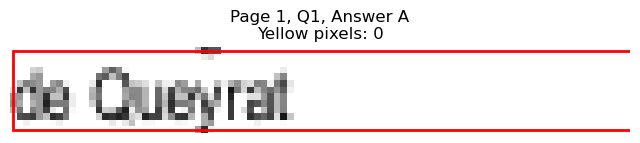

Page 1, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=161.4, y1=121.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 432
Page 1, Q1, B: Yellow percentage: 0.0%


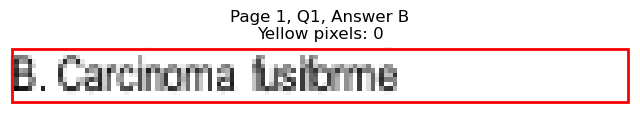

Page 1, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=173.6, y1=133.6
Page 1, Q1, C: Yellow pixels: 902
Page 1, Q1, C: Total non-white pixels: 1313
Page 1, Q1, C: Yellow percentage: 68.7%


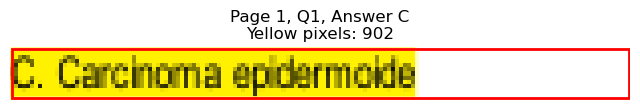

Page 1, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=398.0, y1=108.8
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 363
Page 1, Q1, D: Yellow percentage: 0.0%


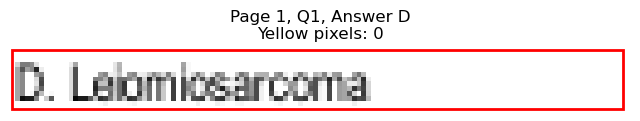

Page 1, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=406.3, y1=121.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 420
Page 1, Q1, E: Yellow percentage: 0.0%


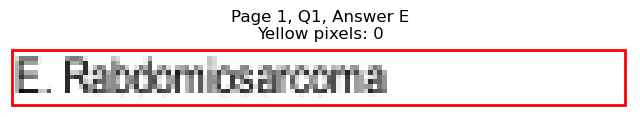


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=176.6, y1=181.6
Page 1, Q2, A: Yellow pixels: 690
Page 1, Q2, A: Total non-white pixels: 1209
Page 1, Q2, A: Yellow percentage: 57.1%


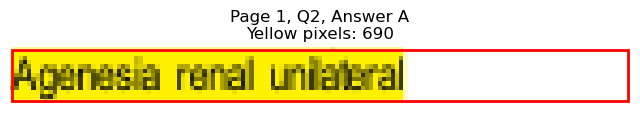

Page 1, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=148.7, y1=193.6
Page 1, Q2, B: Yellow pixels: 91
Page 1, Q2, B: Total non-white pixels: 496
Page 1, Q2, B: Yellow percentage: 18.3%


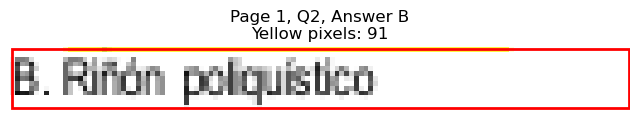

Page 1, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=175.8, y1=205.6
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 522
Page 1, Q2, C: Yellow percentage: 0.0%


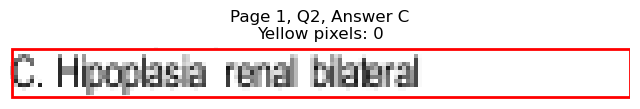

Page 1, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=384.6, y1=181.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 442
Page 1, Q2, D: Yellow percentage: 0.0%


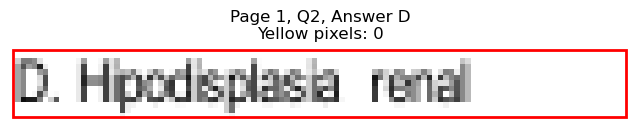

Page 1, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=400.3, y1=193.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 499
Page 1, Q2, E: Yellow percentage: 0.0%


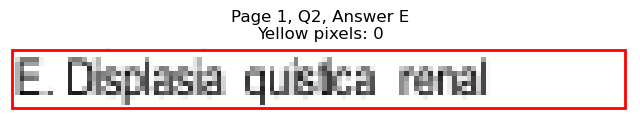


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=154.0, y1=253.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 353
Page 1, Q3, A: Yellow percentage: 0.0%


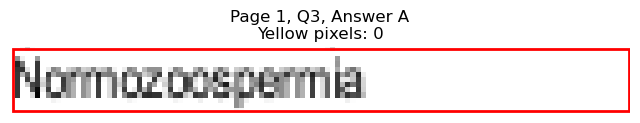

Page 1, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=151.0, y1=265.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 388
Page 1, Q3, B: Yellow percentage: 0.0%


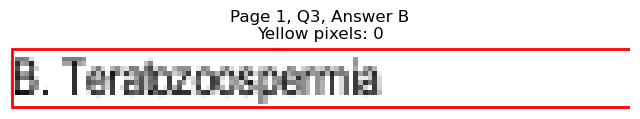

Page 1, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=147.2, y1=277.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 381
Page 1, Q3, C: Yellow percentage: 0.0%


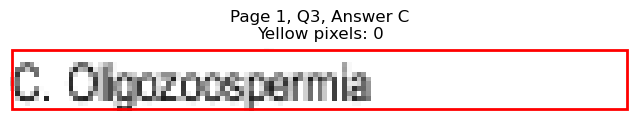

Page 1, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=405.6, y1=253.7
Page 1, Q3, D: Yellow pixels: 633
Page 1, Q3, D: Total non-white pixels: 1066
Page 1, Q3, D: Yellow percentage: 59.4%


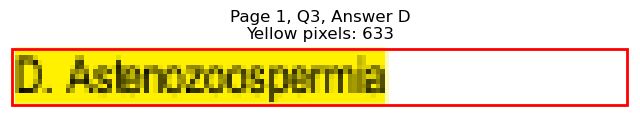

Page 1, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=401.8, y1=265.7
Page 1, Q3, E: Yellow pixels: 80
Page 1, Q3, E: Total non-white pixels: 456
Page 1, Q3, E: Yellow percentage: 17.5%


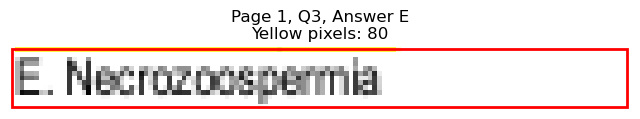


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=139.6, y0=302.5, x1=222.3, y1=314.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 397
Page 1, Q4, A: Yellow percentage: 0.0%


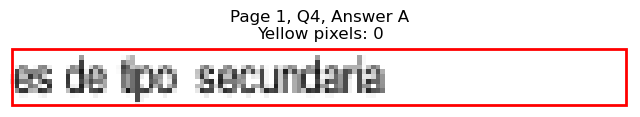

Page 1, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=136.0, y1=326.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 497
Page 1, Q4, B: Yellow percentage: 0.0%


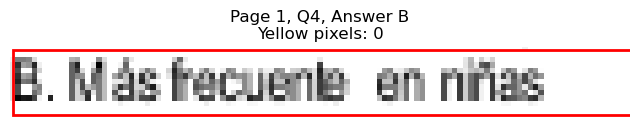

Page 1, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=190.1, y1=338.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 736
Page 1, Q4, C: Yellow percentage: 0.0%


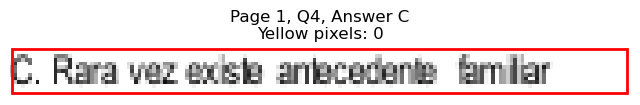

Page 1, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=466.3, y1=314.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 716
Page 1, Q4, D: Yellow percentage: 0.0%


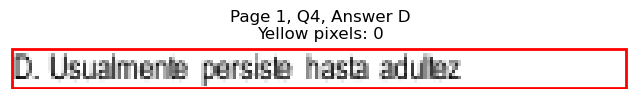

Page 1, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=409.3, y1=326.5
Page 1, Q4, E: Yellow pixels: 1255
Page 1, Q4, E: Total non-white pixels: 1794
Page 1, Q4, E: Yellow percentage: 70.0%


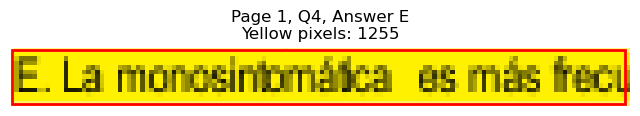


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=137.5, y1=386.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 278
Page 1, Q5, A: Yellow percentage: 0.0%


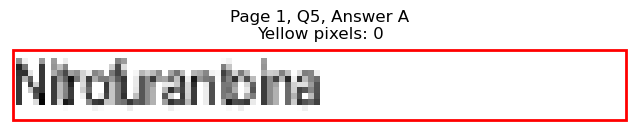

Page 1, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=173.5, y1=398.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 489
Page 1, Q5, B: Yellow percentage: 0.0%


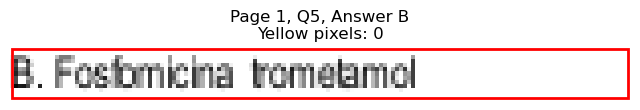

Page 1, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=134.5, y1=410.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 276
Page 1, Q5, C: Yellow percentage: 0.0%


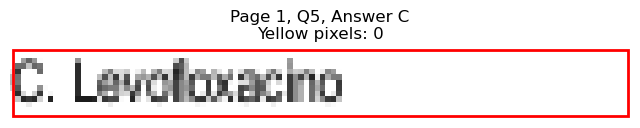

Page 1, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=422.2, y1=386.6
Page 1, Q5, D: Yellow pixels: 856
Page 1, Q5, D: Total non-white pixels: 1274
Page 1, Q5, D: Yellow percentage: 67.2%


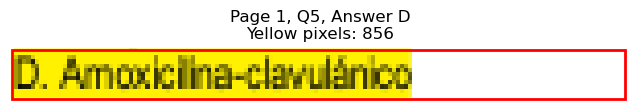

Page 1, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=413.9, y1=398.6
Page 1, Q5, E: Yellow pixels: 97
Page 1, Q5, E: Total non-white pixels: 558
Page 1, Q5, E: Yellow percentage: 17.4%


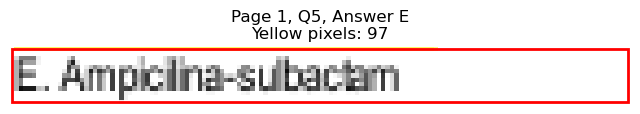


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=115.0, y1=446.6
Page 1, Q6, A: Yellow pixels: 230
Page 1, Q6, A: Total non-white pixels: 403
Page 1, Q6, A: Yellow percentage: 57.1%


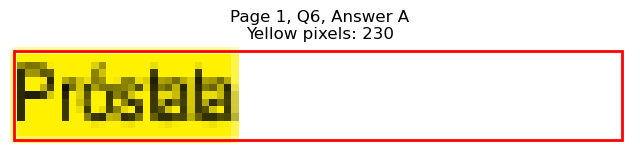

Page 1, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=105.3, y1=458.6
Page 1, Q6, B: Yellow pixels: 30
Page 1, Q6, B: Total non-white pixels: 200
Page 1, Q6, B: Yellow percentage: 15.0%


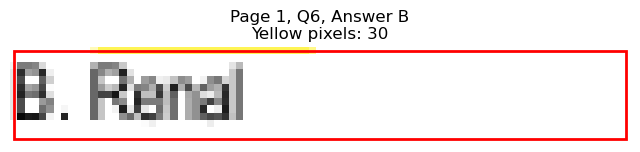

Page 1, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=122.5, y1=470.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 237
Page 1, Q6, C: Yellow percentage: 0.0%


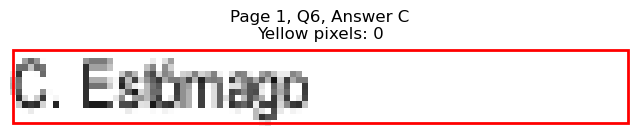

Page 1, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=371.8, y1=446.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 233
Page 1, Q6, D: Yellow percentage: 0.0%


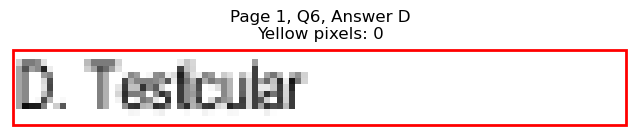

Page 1, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=364.3, y1=458.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 179
Page 1, Q6, E: Yellow percentage: 0.0%


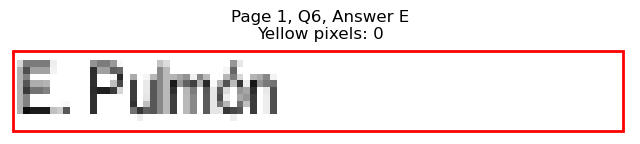


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=168.2, y1=507.4
Page 1, Q7, A: Yellow pixels: 1198
Page 1, Q7, A: Total non-white pixels: 1781
Page 1, Q7, A: Yellow percentage: 67.3%


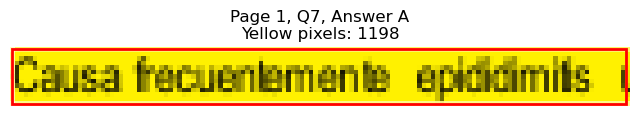

Page 1, Q7 - B: Detected box: x0=136.6, y0=507.4, x1=264.9, y1=519.4
Page 1, Q7, B: Yellow pixels: 114
Page 1, Q7, B: Total non-white pixels: 724
Page 1, Q7, B: Yellow percentage: 15.7%


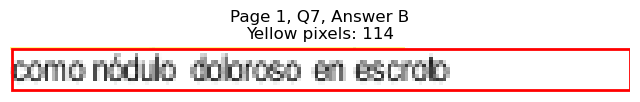

Page 1, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=170.5, y1=531.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 685
Page 1, Q7, C: Yellow percentage: 0.0%


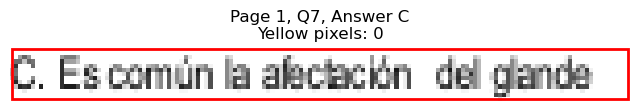

Page 1, Q7 - D: Detected box: x0=384.4, y0=495.4, x1=459.5, y1=507.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 627
Page 1, Q7, D: Yellow percentage: 0.0%


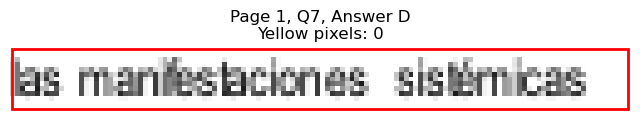

Page 1, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=488.7, y1=519.4
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 817
Page 1, Q7, E: Yellow percentage: 0.0%


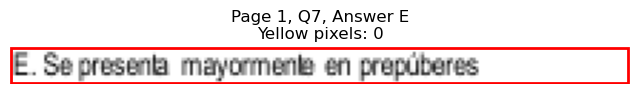


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=205.8, y1=591.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 563
Page 1, Q8, A: Yellow percentage: 0.0%


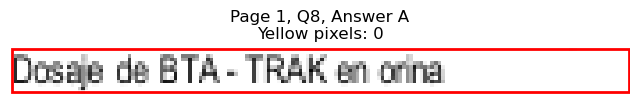

Page 1, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=157.7, y1=603.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 680
Page 1, Q8, B: Yellow percentage: 0.0%


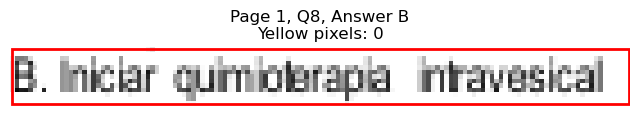

Page 1, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=161.5, y1=615.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 583
Page 1, Q8, C: Yellow percentage: 0.0%


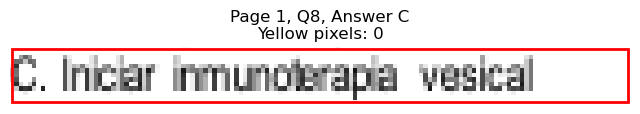

Page 1, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=468.7, y1=591.5
Page 1, Q8, D: Yellow pixels: 1302
Page 1, Q8, D: Total non-white pixels: 1885
Page 1, Q8, D: Yellow percentage: 69.1%


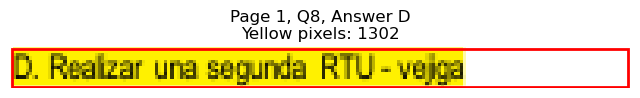

Page 1, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=410.0, y1=603.5
Page 1, Q8, E: Yellow pixels: 138
Page 1, Q8, E: Total non-white pixels: 742
Page 1, Q8, E: Yellow percentage: 18.6%


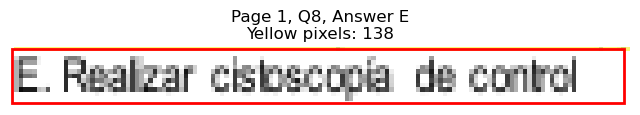


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=133.0, y1=675.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 238
Page 1, Q9, A: Yellow percentage: 0.0%


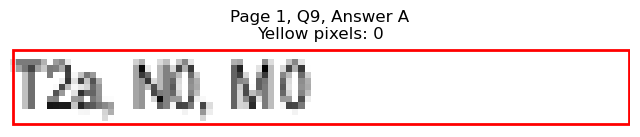

Page 1, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=132.2, y1=688.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 271
Page 1, Q9, B: Yellow percentage: 0.0%


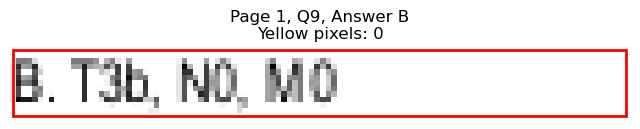

Page 1, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=133.1, y1=700.3
Page 1, Q9, C: Yellow pixels: 492
Page 1, Q9, C: Total non-white pixels: 780
Page 1, Q9, C: Yellow percentage: 63.1%


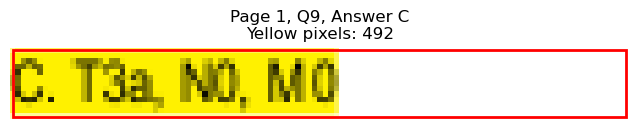

Page 1, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=384.5, y1=675.6
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 267
Page 1, Q9, D: Yellow percentage: 0.0%


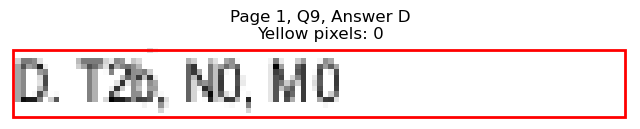

Page 1, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=383.7, y1=688.3
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 250
Page 1, Q9, E: Yellow percentage: 0.0%


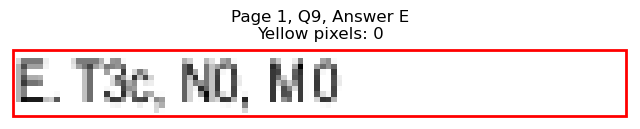


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=748.4, x1=132.2, y1=760.4
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 257
Page 1, Q10, A: Yellow percentage: 0.0%


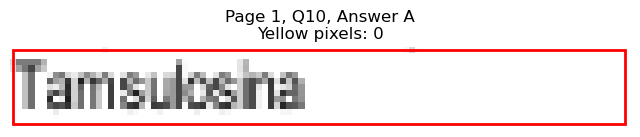

Page 1, Q10 - B: Detected box: x0=71.3, y0=760.4, x1=127.8, y1=772.4
Page 1, Q10, B: Yellow pixels: 464
Page 1, Q10, B: Total non-white pixels: 715
Page 1, Q10, B: Yellow percentage: 64.9%


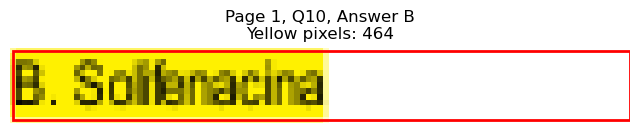

Page 1, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=122.5, y1=784.4
Page 1, Q10, C: Yellow pixels: 53
Page 1, Q10, C: Total non-white pixels: 282
Page 1, Q10, C: Yellow percentage: 18.8%


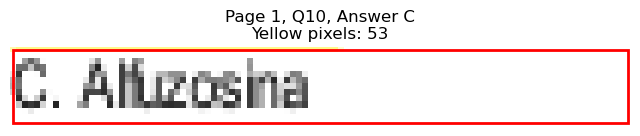

Page 1, Q10 - D: Detected box: x0=322.9, y0=748.4, x1=376.3, y1=760.4
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 242
Page 1, Q10, D: Yellow percentage: 0.0%


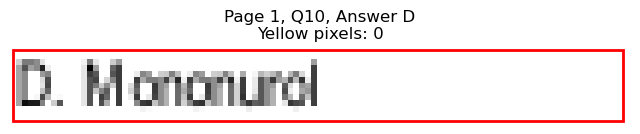

Page 1, Q10 - E: Detected box: x0=322.9, y0=760.4, x1=383.9, y1=772.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 309
Page 1, Q10, E: Yellow percentage: 0.0%


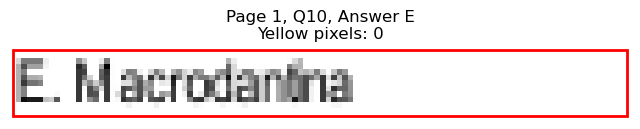


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=144.1, y0=96.8, x1=276.2, y1=108.8
Page 2, Q1, A: Yellow pixels: 71
Page 2, Q1, A: Total non-white pixels: 732
Page 2, Q1, A: Yellow percentage: 9.7%


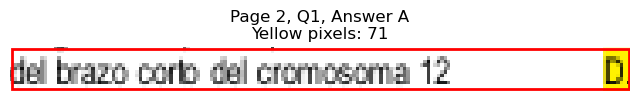

Page 2, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=241.7, y1=121.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 813
Page 2, Q1, B: Yellow percentage: 0.0%


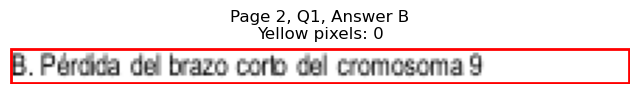

Page 2, Q1 - C: Detected box: x0=135.8, y0=121.5, x1=216.9, y1=133.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 389
Page 2, Q1, C: Yellow percentage: 0.0%


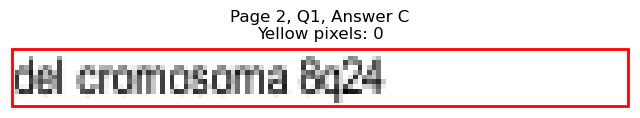

Page 2, Q1 - D: Detected box: x0=319.1, y0=96.8, x1=493.5, y1=108.8
Page 2, Q1, D: Yellow pixels: 1434
Page 2, Q1, D: Total non-white pixels: 2249
Page 2, Q1, D: Yellow percentage: 63.8%


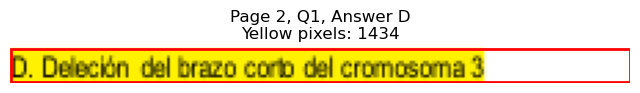

Page 2, Q1 - E: Detected box: x0=382.9, y0=109.5, x1=469.5, y1=121.6
Page 2, Q1, E: Yellow pixels: 109
Page 2, Q1, E: Total non-white pixels: 517
Page 2, Q1, E: Yellow percentage: 21.1%


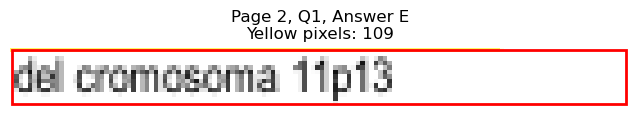


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=107.5, y1=193.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 138
Page 2, Q2, A: Yellow percentage: 0.0%


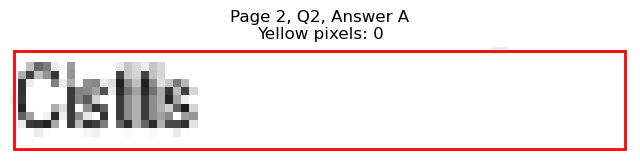

Page 2, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=136.7, y1=205.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 339
Page 2, Q2, B: Yellow percentage: 0.0%


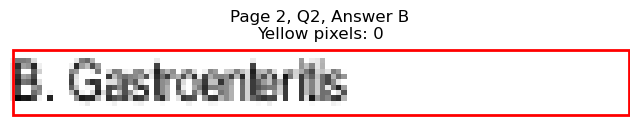

Page 2, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=125.5, y1=217.7
Page 2, Q2, C: Yellow pixels: 401
Page 2, Q2, C: Total non-white pixels: 689
Page 2, Q2, C: Yellow percentage: 58.2%


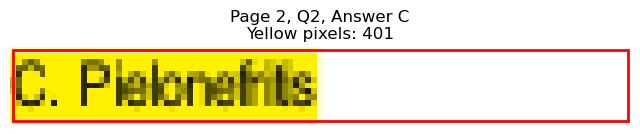

Page 2, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=374.0, y1=193.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 264
Page 2, Q2, D: Yellow percentage: 0.0%


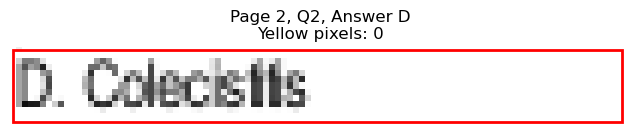

Page 2, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=362.8, y1=205.6
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 183
Page 2, Q2, E: Yellow percentage: 0.0%


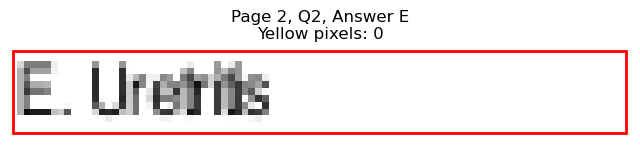


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=148.8, y1=289.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 334
Page 2, Q3, A: Yellow percentage: 0.0%


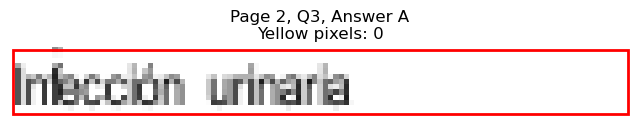

Page 2, Q3 - B: Detected box: x0=110.3, y0=289.7, x1=162.2, y1=301.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 276
Page 2, Q3, B: Yellow percentage: 0.0%


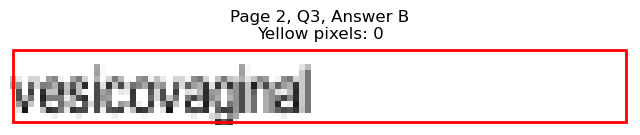

Page 2, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=163.8, y1=314.5
Page 2, Q3, C: Yellow pixels: 803
Page 2, Q3, C: Total non-white pixels: 1183
Page 2, Q3, C: Yellow percentage: 67.9%


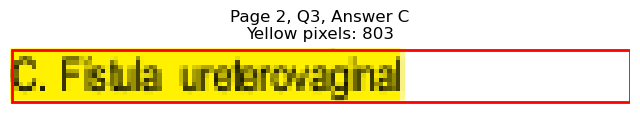

Page 2, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=409.3, y1=289.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 430
Page 2, Q3, D: Yellow percentage: 0.0%


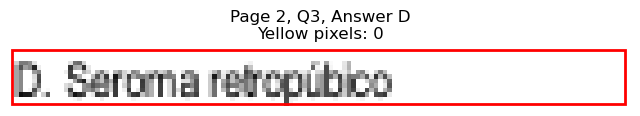

Page 2, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=426.5, y1=301.8
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 504
Page 2, Q3, E: Yellow percentage: 0.0%


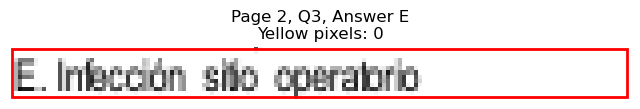


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=338.5, x1=190.0, y1=350.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 563
Page 2, Q4, A: Yellow percentage: 0.0%


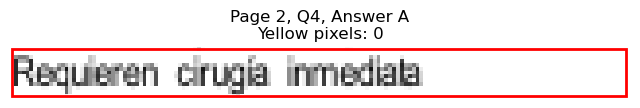

Page 2, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=228.2, y1=362.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 792
Page 2, Q4, B: Yellow percentage: 0.0%


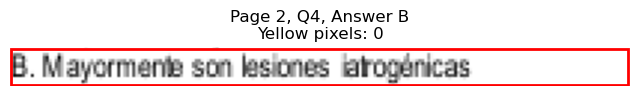

Page 2, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=138.2, y1=374.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 584
Page 2, Q4, C: Yellow percentage: 0.0%


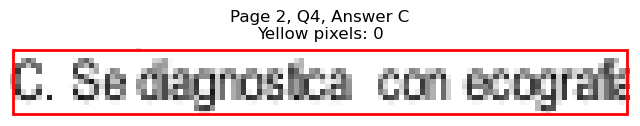

Page 2, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=473.2, y1=350.5
Page 2, Q4, D: Yellow pixels: 1325
Page 2, Q4, D: Total non-white pixels: 1937
Page 2, Q4, D: Yellow percentage: 68.4%


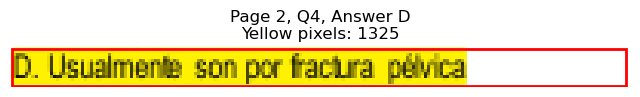

Page 2, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=464.8, y1=362.5
Page 2, Q4, E: Yellow pixels: 148
Page 2, Q4, E: Total non-white pixels: 838
Page 2, Q4, E: Yellow percentage: 17.7%


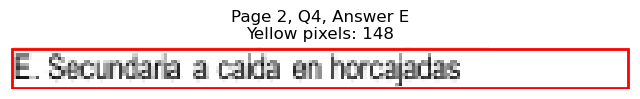


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=165.3, y1=410.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 651
Page 2, Q5, A: Yellow percentage: 0.0%


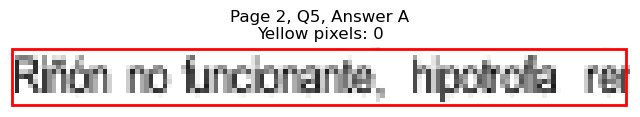

Page 2, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=193.7, y1=434.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 818
Page 2, Q5, B: Yellow percentage: 0.0%


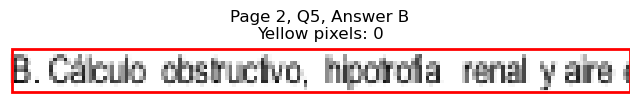

Page 2, Q5 - C: Detected box: x0=138.1, y0=446.6, x1=262.7, y1=458.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 638
Page 2, Q5, C: Yellow percentage: 0.0%


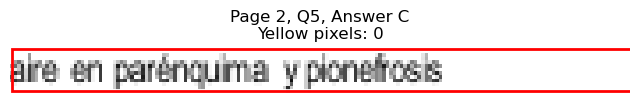

Page 2, Q5 - D: Detected box: x0=418.9, y0=398.5, x1=519.5, y1=410.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 483
Page 2, Q5, D: Yellow percentage: 0.0%


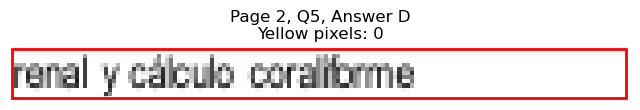

Page 2, Q5 - E: Detected box: x0=389.6, y0=410.5, x1=502.4, y1=422.6
Page 2, Q5, E: Yellow pixels: 920
Page 2, Q5, E: Total non-white pixels: 1456
Page 2, Q5, E: Yellow percentage: 63.2%


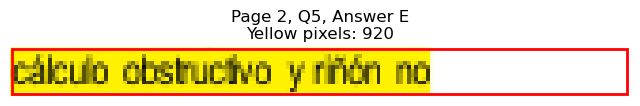


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=119.5, y1=507.4
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 334
Page 2, Q6, A: Yellow percentage: 0.0%


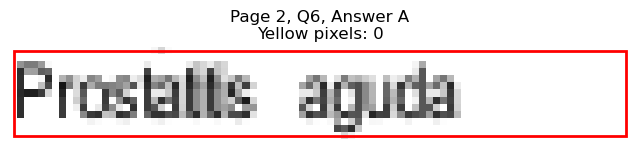

Page 2, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=125.5, y1=519.4
Page 2, Q6, B: Yellow pixels: 918
Page 2, Q6, B: Total non-white pixels: 1365
Page 2, Q6, B: Yellow percentage: 67.3%


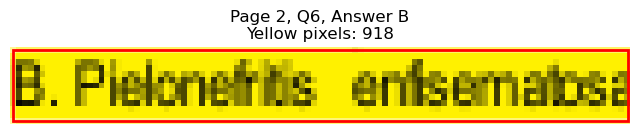

Page 2, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=184.7, y1=531.4
Page 2, Q6, C: Yellow pixels: 105
Page 2, Q6, C: Total non-white pixels: 663
Page 2, Q6, C: Yellow percentage: 15.8%


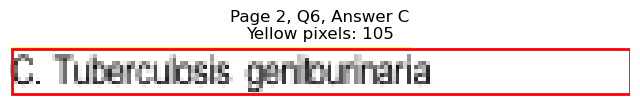

Page 2, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=402.5, y1=507.4
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 607
Page 2, Q6, D: Yellow percentage: 0.0%


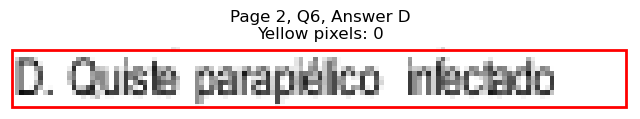

Page 2, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=391.4, y1=519.4
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 321
Page 2, Q6, E: Yellow percentage: 0.0%


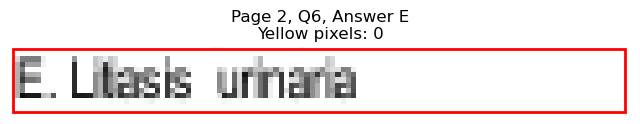


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=129.8, y0=567.5, x1=180.2, y1=579.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 283
Page 2, Q7, A: Yellow percentage: 0.0%


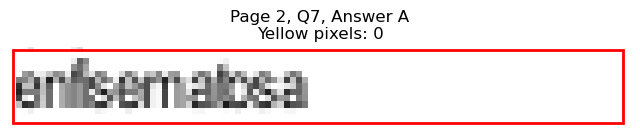

Page 2, Q7 - B: Detected box: x0=129.1, y0=579.4, x1=205.9, y1=591.5
Page 2, Q7, B: Yellow pixels: 651
Page 2, Q7, B: Total non-white pixels: 975
Page 2, Q7, B: Yellow percentage: 66.8%


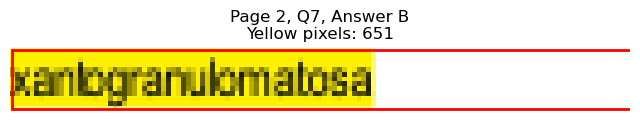

Page 2, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=184.7, y1=531.4
Page 2, Q7, C: Yellow pixels: 105
Page 2, Q7, C: Total non-white pixels: 663
Page 2, Q7, C: Yellow percentage: 15.8%


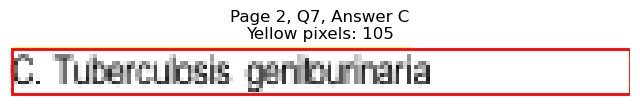

Page 2, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=431.8, y1=579.5
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 550
Page 2, Q7, D: Yellow percentage: 0.0%


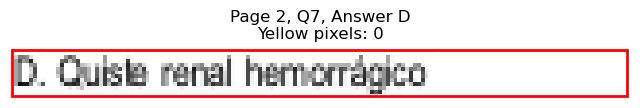

Page 2, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=391.3, y1=591.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 605
Page 2, Q7, E: Yellow percentage: 0.0%


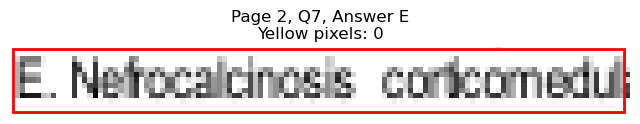


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=663.5, x1=132.2, y1=675.6
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 261
Page 2, Q8, A: Yellow percentage: 0.0%


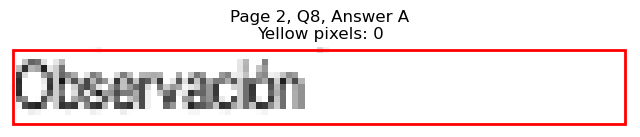

Page 2, Q8 - B: Detected box: x0=71.3, y0=676.3, x1=141.2, y1=688.3
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 294
Page 2, Q8, B: Yellow percentage: 0.0%


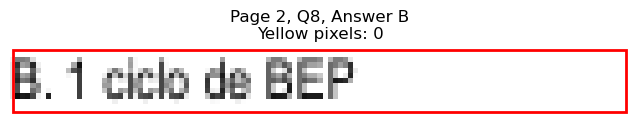

Page 2, Q8 - C: Detected box: x0=71.3, y0=688.3, x1=145.8, y1=700.3
Page 2, Q8, C: Yellow pixels: 618
Page 2, Q8, C: Total non-white pixels: 949
Page 2, Q8, C: Yellow percentage: 65.1%


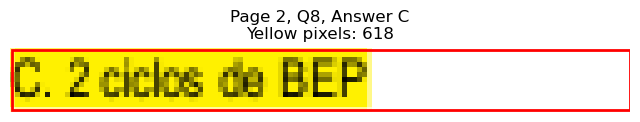

Page 2, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=396.6, y1=675.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 534
Page 2, Q8, D: Yellow percentage: 0.0%


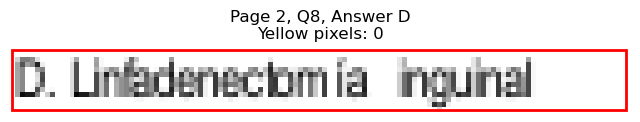

Page 2, Q8 - E: Detected box: x0=322.9, y0=676.3, x1=397.2, y1=688.3
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 325
Page 2, Q8, E: Yellow percentage: 0.0%


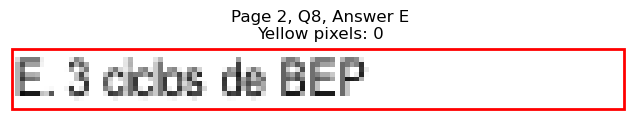


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=724.3, x1=133.7, y1=736.4
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 402
Page 2, Q9, A: Yellow percentage: 0.0%


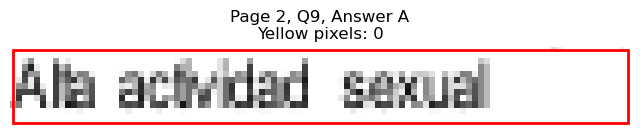

Page 2, Q9 - B: Detected box: x0=71.3, y0=736.4, x1=129.2, y1=748.4
Page 2, Q9, B: Yellow pixels: 968
Page 2, Q9, B: Total non-white pixels: 1417
Page 2, Q9, B: Yellow percentage: 68.3%


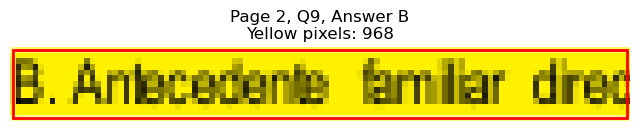

Page 2, Q9 - C: Detected box: x0=71.3, y0=748.4, x1=134.5, y1=760.4
Page 2, Q9, C: Yellow pixels: 113
Page 2, Q9, C: Total non-white pixels: 410
Page 2, Q9, C: Yellow percentage: 27.6%


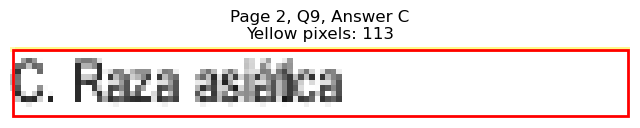

Page 2, Q9 - D: Detected box: x0=322.9, y0=724.3, x1=410.8, y1=736.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 423
Page 2, Q9, D: Yellow percentage: 0.0%


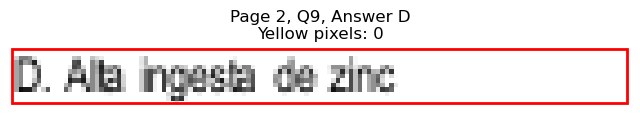

Page 2, Q9 - E: Detected box: x0=322.9, y0=736.4, x1=399.6, y1=748.4
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 435
Page 2, Q9, E: Yellow percentage: 0.0%


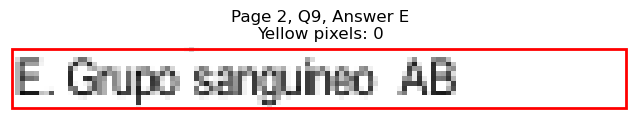


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=145.6, x1=207.2, y1=157.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 869
Page 3, Q1, A: Yellow percentage: 0.0%


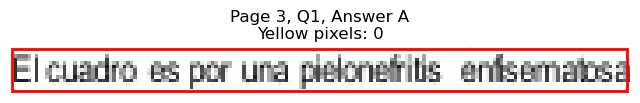

Page 3, Q1 - B: Detected box: x0=142.6, y0=157.6, x1=260.5, y1=169.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 540
Page 3, Q1, B: Yellow percentage: 0.0%


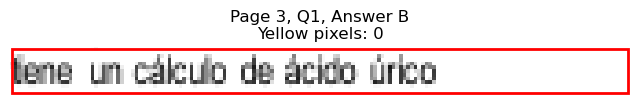

Page 3, Q1 - C: Detected box: x0=71.3, y0=169.6, x1=260.0, y1=181.6
Page 3, Q1, C: Yellow pixels: 1522
Page 3, Q1, C: Total non-white pixels: 2431
Page 3, Q1, C: Yellow percentage: 62.6%


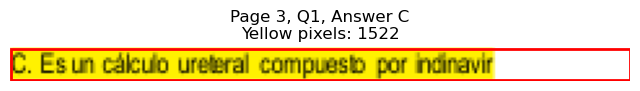

Page 3, Q1 - D: Detected box: x0=322.9, y0=145.6, x1=462.5, y1=157.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 695
Page 3, Q1, D: Yellow percentage: 0.0%


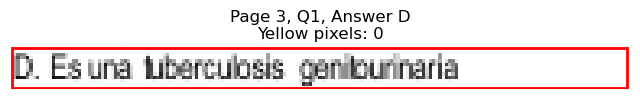

Page 3, Q1 - E: Detected box: x0=322.9, y0=157.6, x1=395.0, y1=169.6
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 611
Page 3, Q1, E: Yellow percentage: 0.0%


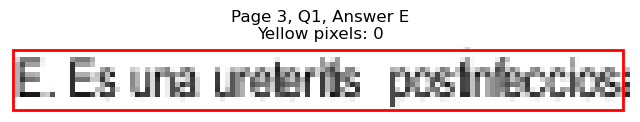


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=205.6, x1=123.2, y1=217.7
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 209
Page 3, Q2, A: Yellow percentage: 0.0%


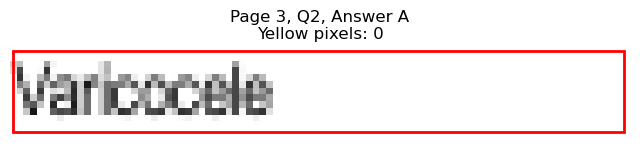

Page 3, Q2 - B: Detected box: x0=71.3, y0=217.6, x1=139.7, y1=229.7
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 347
Page 3, Q2, B: Yellow percentage: 0.0%


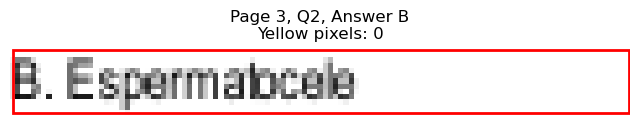

Page 3, Q2 - C: Detected box: x0=71.3, y0=229.6, x1=112.7, y1=241.7
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 196
Page 3, Q2, C: Yellow percentage: 0.0%


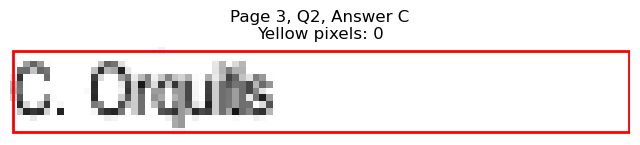

Page 3, Q2 - D: Detected box: x0=322.9, y0=205.6, x1=371.1, y1=217.7
Page 3, Q2, D: Yellow pixels: 362
Page 3, Q2, D: Total non-white pixels: 613
Page 3, Q2, D: Yellow percentage: 59.1%


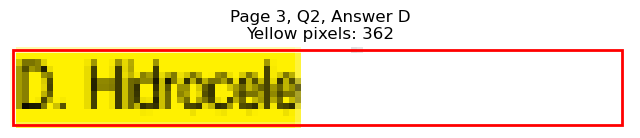

Page 3, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=376.3, y1=229.7
Page 3, Q2, E: Yellow pixels: 46
Page 3, Q2, E: Total non-white pixels: 337
Page 3, Q2, E: Yellow percentage: 13.6%


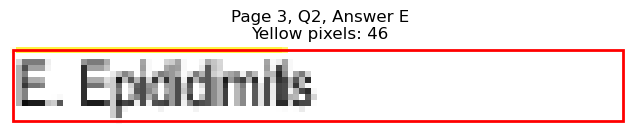


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=133.7, y1=277.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 484
Page 3, Q3, A: Yellow percentage: 0.0%


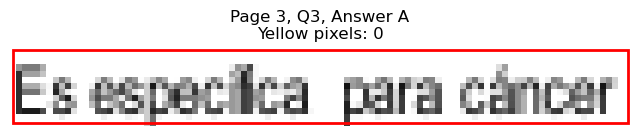

Page 3, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=169.7, y1=289.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 631
Page 3, Q3, B: Yellow percentage: 0.0%


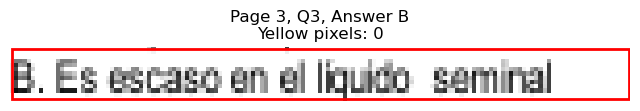

Page 3, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=165.3, y1=301.8
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 694
Page 3, Q3, C: Yellow percentage: 0.0%


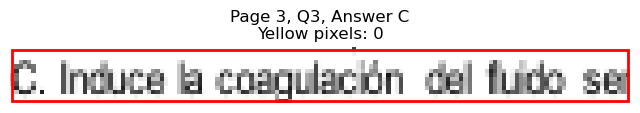

Page 3, Q3 - D: Detected box: x0=431.6, y0=265.7, x1=502.3, y1=277.7
Page 3, Q3, D: Yellow pixels: 554
Page 3, Q3, D: Total non-white pixels: 910
Page 3, Q3, D: Yellow percentage: 60.9%


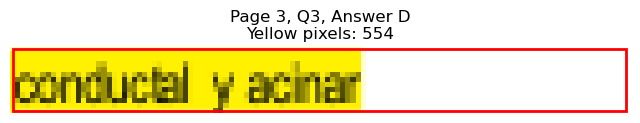

Page 3, Q3 - E: Detected box: x0=380.6, y0=289.7, x1=521.0, y1=301.8
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 667
Page 3, Q3, E: Yellow percentage: 0.0%


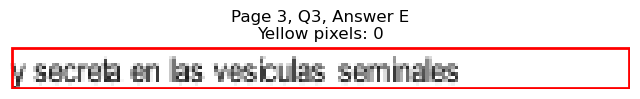


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=175.7, y1=338.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 702
Page 3, Q4, A: Yellow percentage: 0.0%


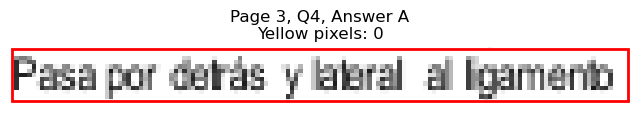

Page 3, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=160.7, y1=350.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 665
Page 3, Q4, B: Yellow percentage: 0.0%


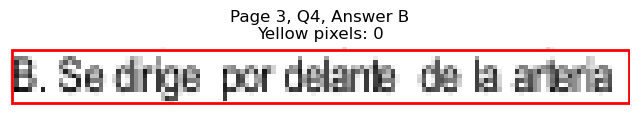

Page 3, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=174.2, y1=362.5
Page 3, Q4, C: Yellow pixels: 1406
Page 3, Q4, C: Total non-white pixels: 2002
Page 3, Q4, C: Yellow percentage: 70.2%


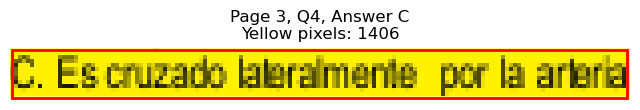

Page 3, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=494.0, y1=338.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 955
Page 3, Q4, D: Yellow percentage: 0.0%


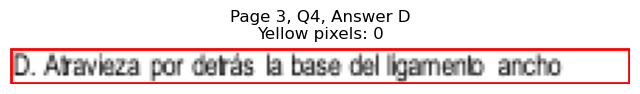

Page 3, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=516.6, y1=350.5
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 922
Page 3, Q4, E: Yellow percentage: 0.0%


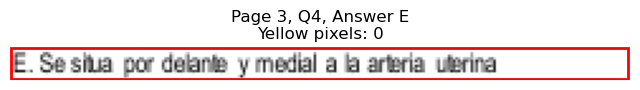


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=95.5, y1=398.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 51
Page 3, Q5, A: Yellow percentage: 0.0%


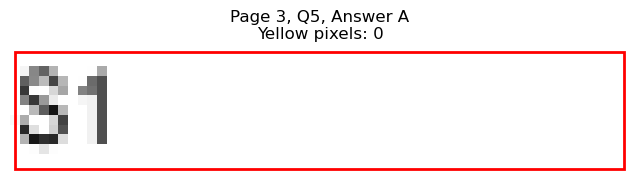

Page 3, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=94.7, y1=410.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 99
Page 3, Q5, B: Yellow percentage: 0.0%


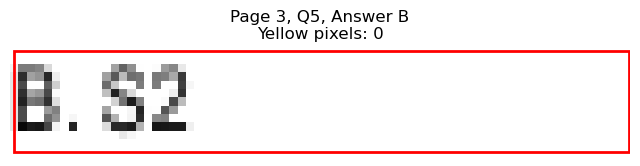

Page 3, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=95.5, y1=422.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 91
Page 3, Q5, C: Yellow percentage: 0.0%


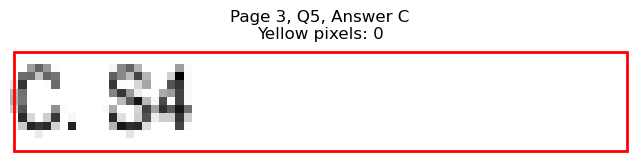

Page 3, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=347.0, y1=398.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 109
Page 3, Q5, D: Yellow percentage: 0.0%


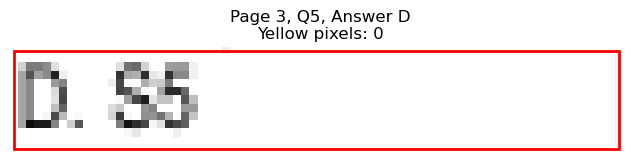

Page 3, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=346.3, y1=410.6
Page 3, Q5, E: Yellow pixels: 190
Page 3, Q5, E: Total non-white pixels: 286
Page 3, Q5, E: Yellow percentage: 66.4%


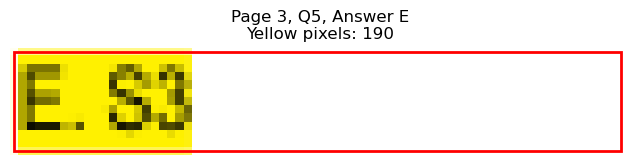


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=151.8, y1=507.4
Page 3, Q6, A: Yellow pixels: 605
Page 3, Q6, A: Total non-white pixels: 887
Page 3, Q6, A: Yellow percentage: 68.2%


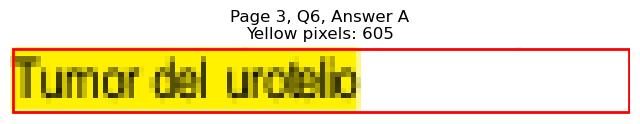

Page 3, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=130.7, y1=519.4
Page 3, Q6, B: Yellow pixels: 66
Page 3, Q6, B: Total non-white pixels: 358
Page 3, Q6, B: Yellow percentage: 18.4%


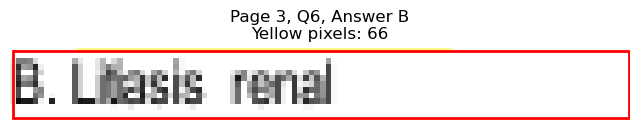

Page 3, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=175.7, y1=531.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 473
Page 3, Q6, C: Yellow percentage: 0.0%


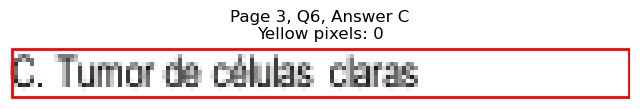

Page 3, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=383.0, y1=507.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 272
Page 3, Q6, D: Yellow percentage: 0.0%


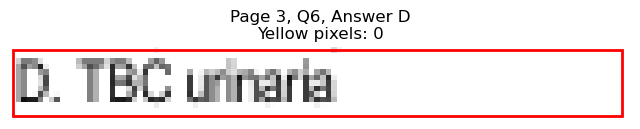

Page 3, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=377.0, y1=519.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 425
Page 3, Q6, E: Yellow percentage: 0.0%


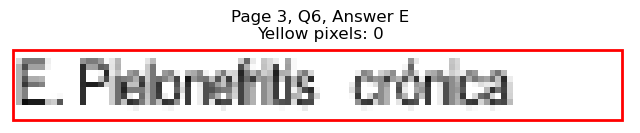


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=591.5, x1=154.0, y1=603.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 564
Page 3, Q7, A: Yellow percentage: 0.0%


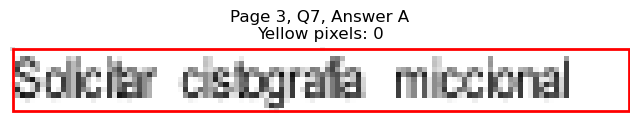

Page 3, Q7 - B: Detected box: x0=71.3, y0=603.5, x1=176.5, y1=615.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 520
Page 3, Q7, B: Yellow percentage: 0.0%


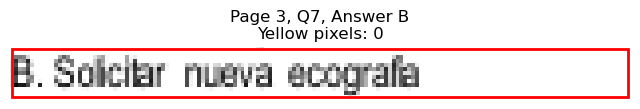

Page 3, Q7 - C: Detected box: x0=71.3, y0=615.5, x1=159.2, y1=627.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 421
Page 3, Q7, C: Yellow percentage: 0.0%


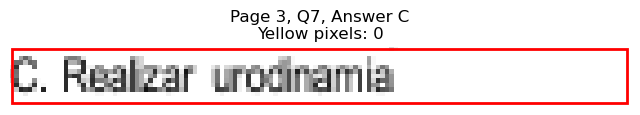

Page 3, Q7 - D: Detected box: x0=322.9, y0=591.5, x1=410.9, y1=603.5
Page 3, Q7, D: Yellow pixels: 770
Page 3, Q7, D: Total non-white pixels: 1133
Page 3, Q7, D: Yellow percentage: 68.0%


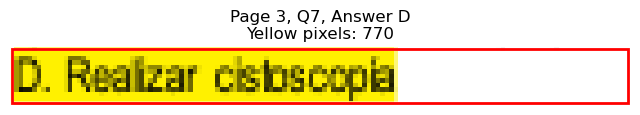

Page 3, Q7 - E: Detected box: x0=322.9, y0=603.5, x1=411.4, y1=615.5
Page 3, Q7, E: Yellow pixels: 85
Page 3, Q7, E: Total non-white pixels: 505
Page 3, Q7, E: Yellow percentage: 16.8%


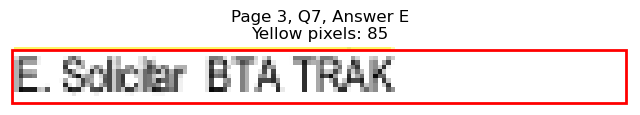


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=663.5, x1=128.5, y1=675.6
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 239
Page 3, Q8, A: Yellow percentage: 0.0%


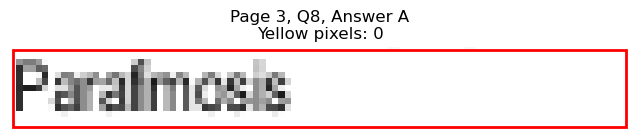

Page 3, Q8 - B: Detected box: x0=71.3, y0=676.3, x1=129.2, y1=688.3
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 306
Page 3, Q8, B: Yellow percentage: 0.0%


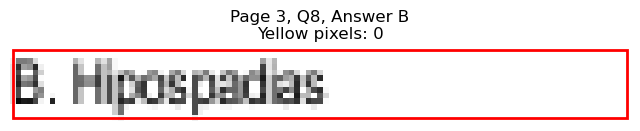

Page 3, Q8 - C: Detected box: x0=71.3, y0=688.3, x1=125.5, y1=700.3
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 269
Page 3, Q8, C: Yellow percentage: 0.0%


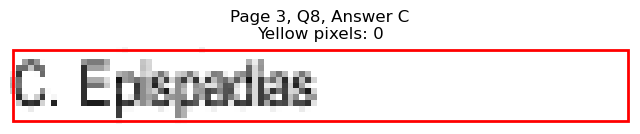

Page 3, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=376.3, y1=675.6
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 258
Page 3, Q8, D: Yellow percentage: 0.0%


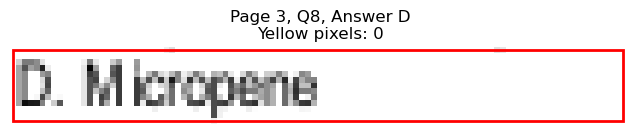

Page 3, Q8 - E: Detected box: x0=322.9, y0=676.3, x1=365.1, y1=688.3
Page 3, Q8, E: Yellow pixels: 326
Page 3, Q8, E: Total non-white pixels: 533
Page 3, Q8, E: Yellow percentage: 61.2%


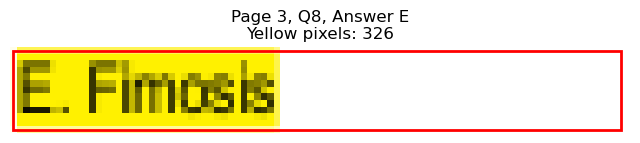


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=724.3, x1=203.6, y1=736.4
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 640
Page 3, Q9, A: Yellow percentage: 0.0%


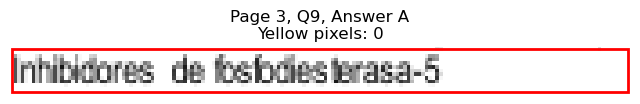

Page 3, Q9 - B: Detected box: x0=71.3, y0=736.4, x1=246.4, y1=748.4
Page 3, Q9, B: Yellow pixels: 1534
Page 3, Q9, B: Total non-white pixels: 2262
Page 3, Q9, B: Yellow percentage: 67.8%


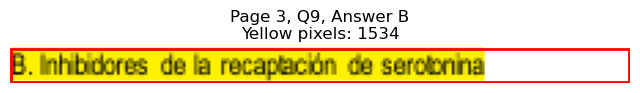

Page 3, Q9 - C: Detected box: x0=71.3, y0=748.4, x1=201.3, y1=760.4
Page 3, Q9, C: Yellow pixels: 172
Page 3, Q9, C: Total non-white pixels: 806
Page 3, Q9, C: Yellow percentage: 21.3%


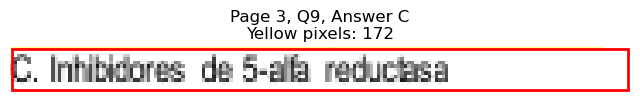

Page 3, Q9 - D: Detected box: x0=322.9, y0=724.3, x1=474.6, y1=736.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 747
Page 3, Q9, D: Yellow percentage: 0.0%


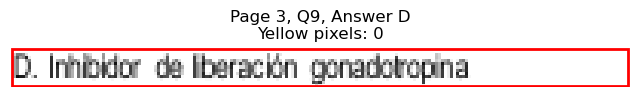

Page 3, Q9 - E: Detected box: x0=322.9, y0=736.4, x1=414.5, y1=748.4
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 682
Page 3, Q9, E: Yellow percentage: 0.0%


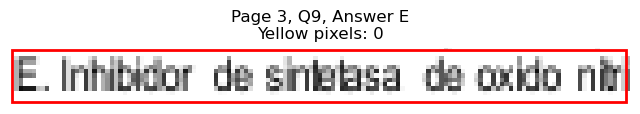


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=134.5, y1=133.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 489
Page 4, Q1, A: Yellow percentage: 0.0%


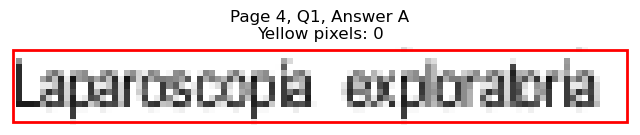

Page 4, Q1 - B: Detected box: x0=135.8, y0=133.5, x1=205.8, y1=145.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 368
Page 4, Q1, B: Yellow percentage: 0.0%


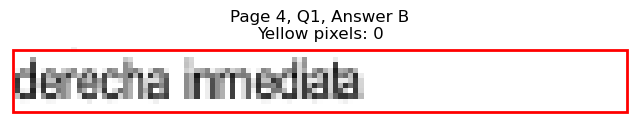

Page 4, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=181.1, y1=157.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 766
Page 4, Q1, C: Yellow percentage: 0.0%


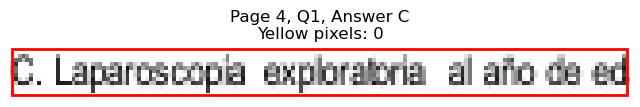

Page 4, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=479.2, y1=133.6
Page 4, Q1, D: Yellow pixels: 1378
Page 4, Q1, D: Total non-white pixels: 2015
Page 4, Q1, D: Yellow percentage: 68.4%


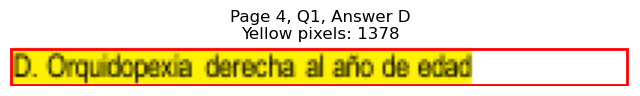

Page 4, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=384.5, y1=145.6
Page 4, Q1, E: Yellow pixels: 112
Page 4, Q1, E: Total non-white pixels: 681
Page 4, Q1, E: Yellow percentage: 16.4%


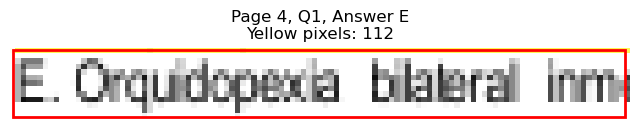


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=168.2, y1=193.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 563
Page 4, Q2, A: Yellow percentage: 0.0%


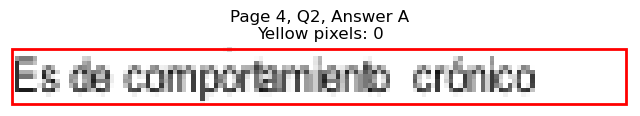

Page 4, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=148.7, y1=205.6
Page 4, Q2, B: Yellow pixels: 1015
Page 4, Q2, B: Total non-white pixels: 1599
Page 4, Q2, B: Yellow percentage: 63.5%


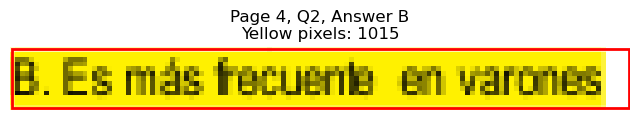

Page 4, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=212.5, y1=217.7
Page 4, Q2, C: Yellow pixels: 123
Page 4, Q2, C: Total non-white pixels: 745
Page 4, Q2, C: Yellow percentage: 16.5%


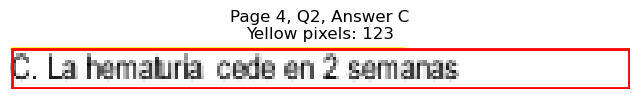

Page 4, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=396.5, y1=193.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 530
Page 4, Q2, D: Yellow percentage: 0.0%


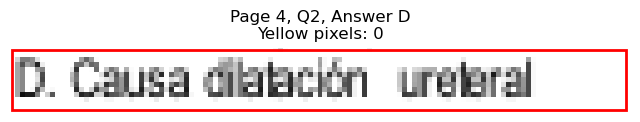

Page 4, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=453.5, y1=205.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 638
Page 4, Q2, E: Yellow percentage: 0.0%


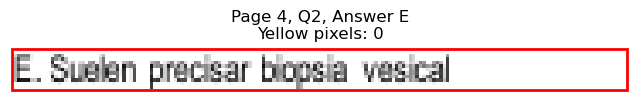


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=95.5, y1=277.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 60
Page 4, Q3, A: Yellow percentage: 0.0%


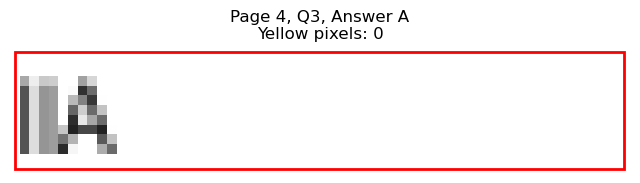

Page 4, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=96.9, y1=289.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 112
Page 4, Q3, B: Yellow percentage: 0.0%


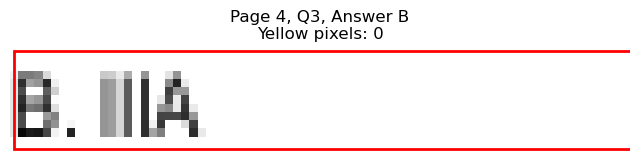

Page 4, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=97.8, y1=301.8
Page 4, Q3, C: Yellow pixels: 195
Page 4, Q3, C: Total non-white pixels: 325
Page 4, Q3, C: Yellow percentage: 60.0%


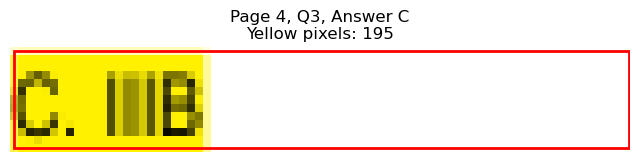

Page 4, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=349.3, y1=277.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 113
Page 4, Q3, D: Yellow percentage: 0.0%


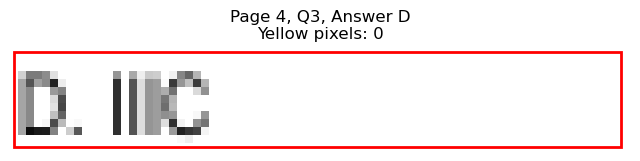

Page 4, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=346.3, y1=289.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 104
Page 4, Q3, E: Yellow percentage: 0.0%


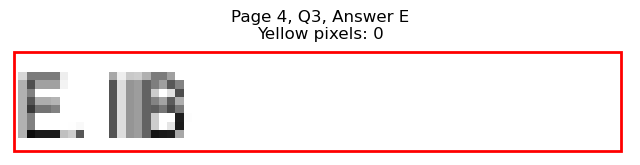


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=133.6, y0=326.5, x1=223.0, y1=338.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 466
Page 4, Q4, A: Yellow percentage: 0.0%


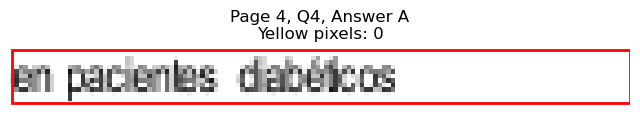

Page 4, Q4 - B: Detected box: x0=141.1, y0=338.5, x1=234.4, y1=350.5
Page 4, Q4, B: Yellow pixels: 810
Page 4, Q4, B: Total non-white pixels: 1196
Page 4, Q4, B: Yellow percentage: 67.7%


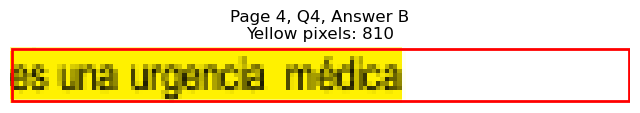

Page 4, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=146.5, y1=362.5
Page 4, Q4, C: Yellow pixels: 126
Page 4, Q4, C: Total non-white pixels: 686
Page 4, Q4, C: Yellow percentage: 18.4%


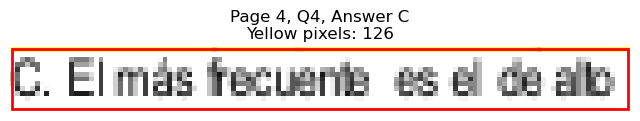

Page 4, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=420.7, y1=338.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 729
Page 4, Q4, D: Yellow percentage: 0.0%


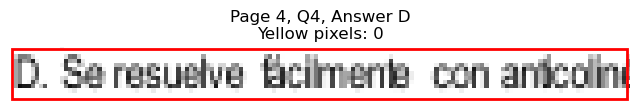

Page 4, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=425.0, y1=350.5
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 738
Page 4, Q4, E: Yellow percentage: 0.0%


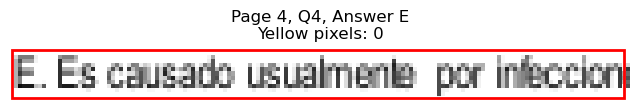


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=114.8, y0=422.5, x1=159.2, y1=434.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 231
Page 4, Q5, A: Yellow percentage: 0.0%


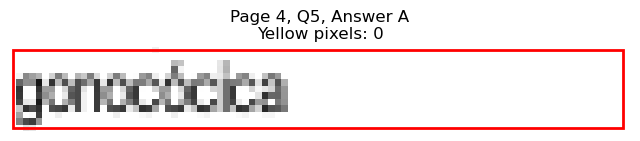

Page 4, Q5 - B: Detected box: x0=71.3, y0=434.6, x1=118.7, y1=446.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 379
Page 4, Q5, B: Yellow percentage: 0.0%


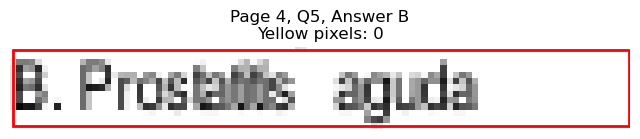

Page 4, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=170.6, y1=458.6
Page 4, Q5, C: Yellow pixels: 803
Page 4, Q5, C: Total non-white pixels: 1274
Page 4, Q5, C: Yellow percentage: 63.0%


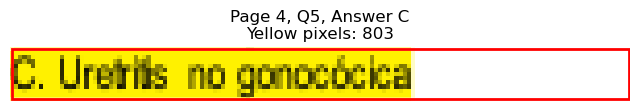

Page 4, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=392.1, y1=434.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 338
Page 4, Q5, D: Yellow percentage: 0.0%


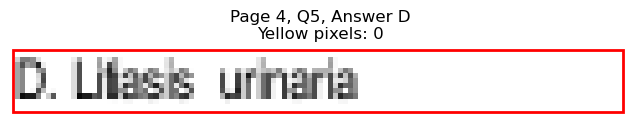

Page 4, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=386.0, y1=446.6
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 544
Page 4, Q5, E: Yellow percentage: 0.0%


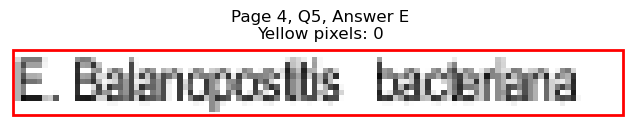


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=143.5, y1=495.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 293
Page 4, Q6, A: Yellow percentage: 0.0%


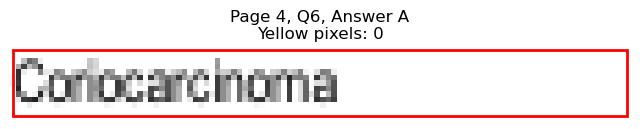

Page 4, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=144.2, y1=507.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 337
Page 4, Q6, B: Yellow percentage: 0.0%


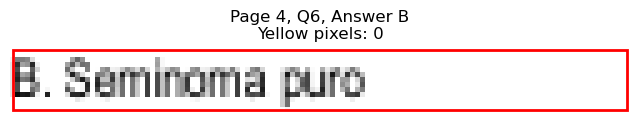

Page 4, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=175.7, y1=519.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 484
Page 4, Q6, C: Yellow percentage: 0.0%


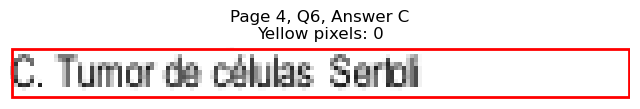

Page 4, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=404.0, y1=495.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 380
Page 4, Q6, D: Yellow percentage: 0.0%


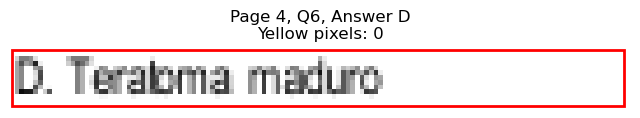

Page 4, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=421.4, y1=507.4
Page 4, Q6, E: Yellow pixels: 860
Page 4, Q6, E: Total non-white pixels: 1274
Page 4, Q6, E: Yellow percentage: 67.5%


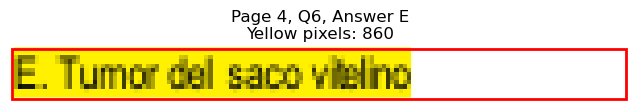


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=130.0, y1=567.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 231
Page 4, Q7, A: Yellow percentage: 0.0%


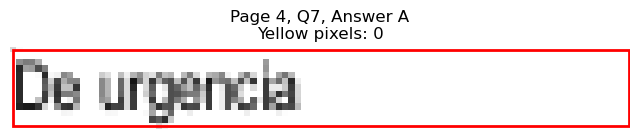

Page 4, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=104.5, y1=579.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 166
Page 4, Q7, B: Yellow percentage: 0.0%


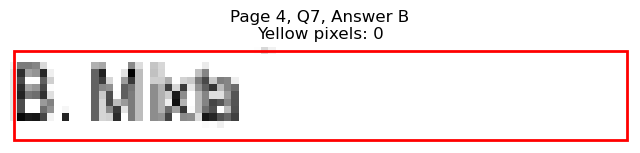

Page 4, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=137.5, y1=591.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 308
Page 4, Q7, C: Yellow percentage: 0.0%


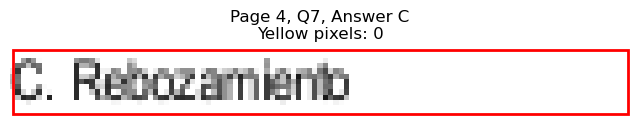

Page 4, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=375.5, y1=567.5
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 270
Page 4, Q7, D: Yellow percentage: 0.0%


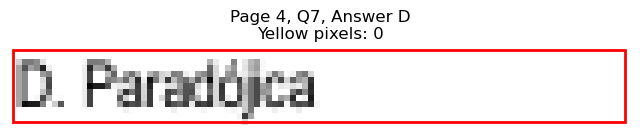

Page 4, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=380.9, y1=579.5
Page 4, Q7, E: Yellow pixels: 507
Page 4, Q7, E: Total non-white pixels: 741
Page 4, Q7, E: Yellow percentage: 68.4%


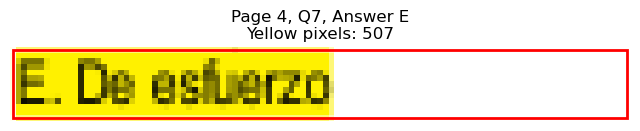


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=144.2, y1=651.6
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 294
Page 4, Q8, A: Yellow percentage: 0.0%


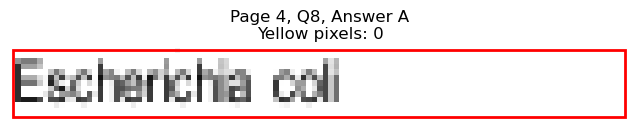

Page 4, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=151.7, y1=663.6
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 401
Page 4, Q8, B: Yellow percentage: 0.0%


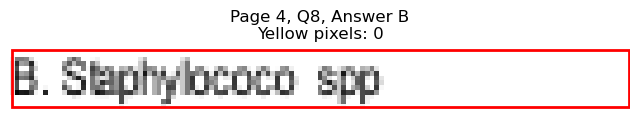

Page 4, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=137.6, y1=675.6
Page 4, Q8, C: Yellow pixels: 515
Page 4, Q8, C: Total non-white pixels: 847
Page 4, Q8, C: Yellow percentage: 60.8%


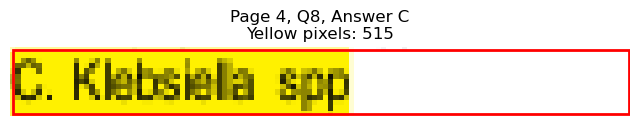

Page 4, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=410.1, y1=651.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 443
Page 4, Q8, D: Yellow percentage: 0.0%


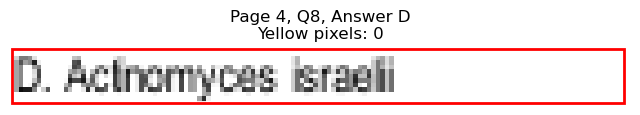

Page 4, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=392.0, y1=663.6
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 340
Page 4, Q8, E: Yellow percentage: 0.0%


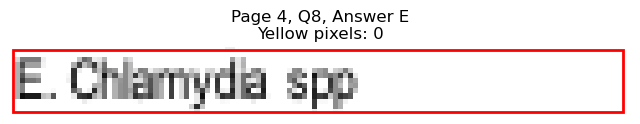


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=127.0, y1=712.3
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 236
Page 4, Q9, A: Yellow percentage: 0.0%


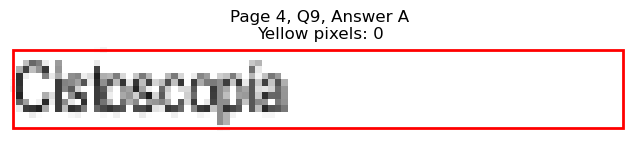

Page 4, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=118.7, y1=724.4
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 244
Page 4, Q9, B: Yellow percentage: 0.0%


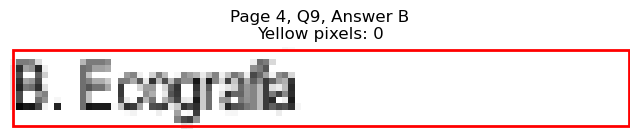

Page 4, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=122.5, y1=736.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 254
Page 4, Q9, C: Yellow percentage: 0.0%


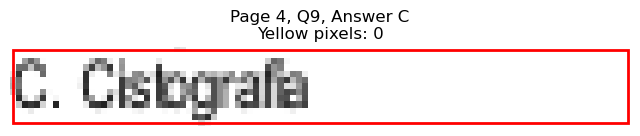

Page 4, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=378.5, y1=712.3
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 293
Page 4, Q9, D: Yellow percentage: 0.0%


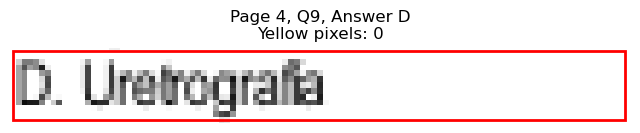

Page 4, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=373.4, y1=724.4
Page 4, Q9, E: Yellow pixels: 388
Page 4, Q9, E: Total non-white pixels: 676
Page 4, Q9, E: Yellow percentage: 57.4%


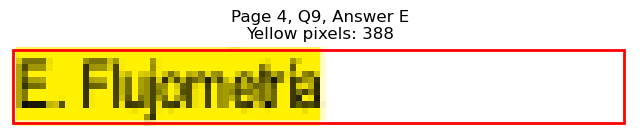


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=180.2, y1=108.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 472
Page 5, Q1, A: Yellow percentage: 0.0%


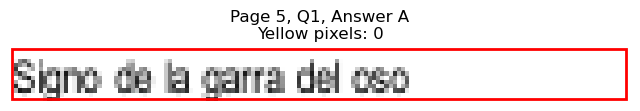

Page 5, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=133.1, y1=121.6
Page 5, Q1, B: Yellow pixels: 530
Page 5, Q1, B: Total non-white pixels: 780
Page 5, Q1, B: Yellow percentage: 67.9%


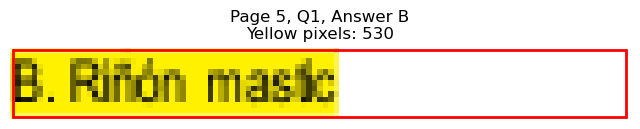

Page 5, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=141.2, y1=133.6
Page 5, Q1, C: Yellow pixels: 60
Page 5, Q1, C: Total non-white pixels: 379
Page 5, Q1, C: Yellow percentage: 15.8%


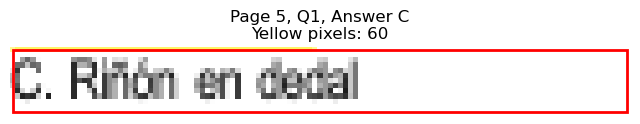

Page 5, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=436.3, y1=108.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 553
Page 5, Q1, D: Yellow percentage: 0.0%


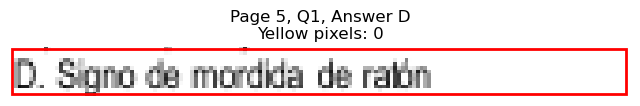

Page 5, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=422.0, y1=121.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 490
Page 5, Q1, E: Yellow percentage: 0.0%


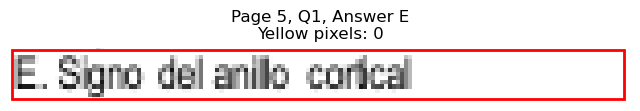


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=108.2, y1=169.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 113
Page 5, Q2, A: Yellow percentage: 0.0%


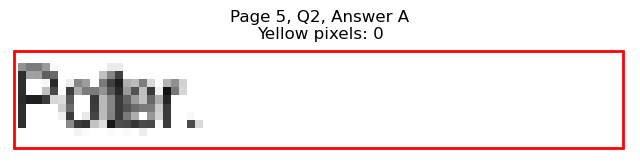

Page 5, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=125.5, y1=181.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 250
Page 5, Q2, B: Yellow percentage: 0.0%


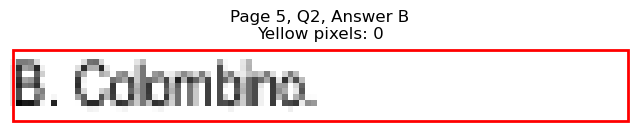

Page 5, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=108.3, y1=193.6
Page 5, Q2, C: Yellow pixels: 286
Page 5, Q2, C: Total non-white pixels: 455
Page 5, Q2, C: Yellow percentage: 62.9%


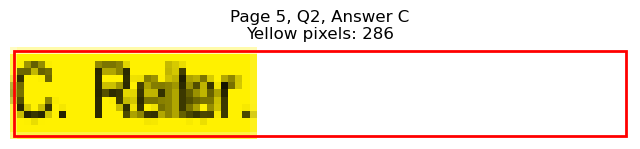

Page 5, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=362.8, y1=169.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 173
Page 5, Q2, D: Yellow percentage: 0.0%


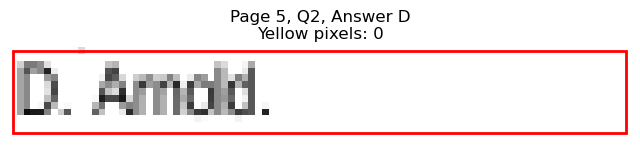

Page 5, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=368.1, y1=181.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 217
Page 5, Q2, E: Yellow percentage: 0.0%


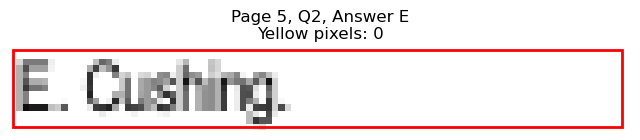


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=146.5, y1=265.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 324
Page 5, Q3, A: Yellow percentage: 0.0%


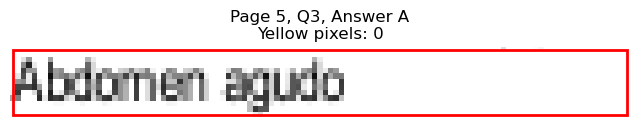

Page 5, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=183.2, y1=277.7
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 591
Page 5, Q3, B: Yellow percentage: 0.0%


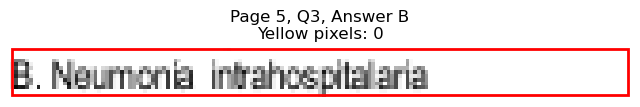

Page 5, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=122.5, y1=289.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 388
Page 5, Q3, C: Yellow percentage: 0.0%


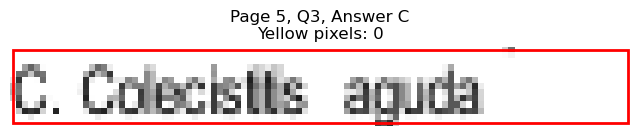

Page 5, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=378.5, y1=265.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 426
Page 5, Q3, D: Yellow percentage: 0.0%


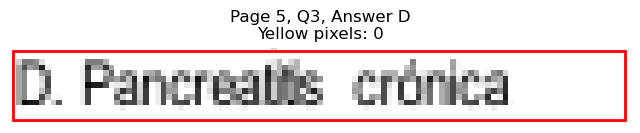

Page 5, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=425.9, y1=277.7
Page 5, Q3, E: Yellow pixels: 786
Page 5, Q3, E: Total non-white pixels: 1326
Page 5, Q3, E: Yellow percentage: 59.3%


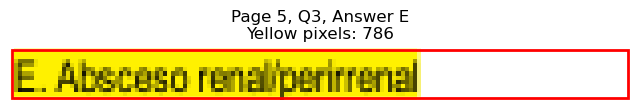


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=174.2, y1=362.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 429
Page 5, Q4, A: Yellow percentage: 0.0%


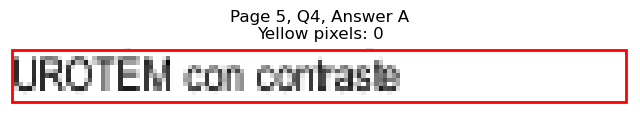

Page 5, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=145.0, y1=374.6
Page 5, Q4, B: Yellow pixels: 999
Page 5, Q4, B: Total non-white pixels: 1469
Page 5, Q4, B: Yellow percentage: 68.0%


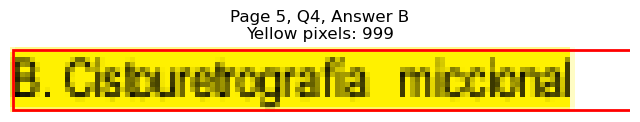

Page 5, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=118.0, y1=386.6
Page 5, Q4, C: Yellow pixels: 97
Page 5, Q4, C: Total non-white pixels: 507
Page 5, Q4, C: Yellow percentage: 19.1%


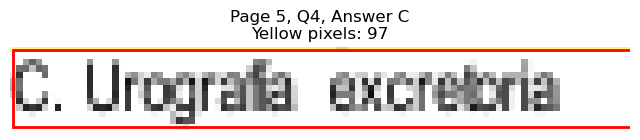

Page 5, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=401.9, y1=362.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 668
Page 5, Q4, D: Yellow percentage: 0.0%


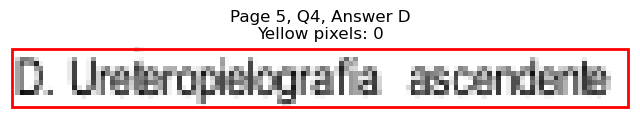

Page 5, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=398.8, y1=374.6
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 379
Page 5, Q4, E: Yellow percentage: 0.0%


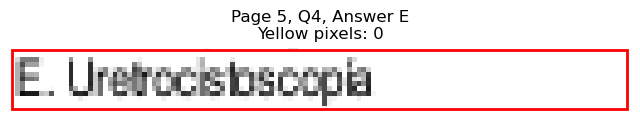


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=148.8, y1=446.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 337
Page 5, Q5, A: Yellow percentage: 0.0%


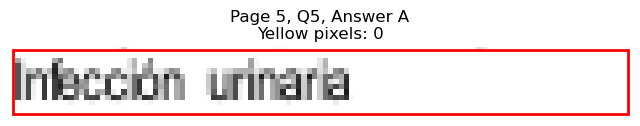

Page 5, Q5 - B: Detected box: x0=114.1, y0=446.6, x1=158.6, y1=458.6
Page 5, Q5, B: Yellow pixels: 323
Page 5, Q5, B: Total non-white pixels: 559
Page 5, Q5, B: Yellow percentage: 57.8%


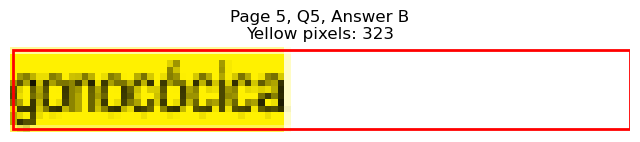

Page 5, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=161.6, y1=470.6
Page 5, Q5, C: Yellow pixels: 85
Page 5, Q5, C: Total non-white pixels: 515
Page 5, Q5, C: Yellow percentage: 16.5%


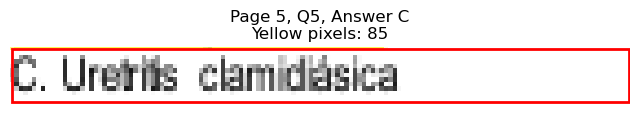

Page 5, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=395.0, y1=446.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 345
Page 5, Q5, D: Yellow percentage: 0.0%


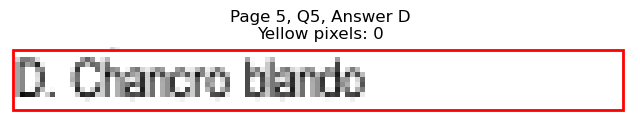

Page 5, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=370.3, y1=458.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 373
Page 5, Q5, E: Yellow percentage: 0.0%


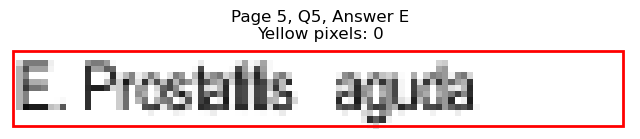


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=531.4, x1=184.7, y1=543.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 511
Page 5, Q6, A: Yellow percentage: 0.0%


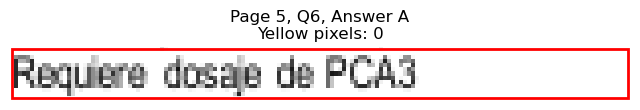

Page 5, Q6 - B: Detected box: x0=71.3, y0=543.4, x1=187.9, y1=555.5
Page 5, Q6, B: Yellow pixels: 1062
Page 5, Q6, B: Total non-white pixels: 1495
Page 5, Q6, B: Yellow percentage: 71.0%


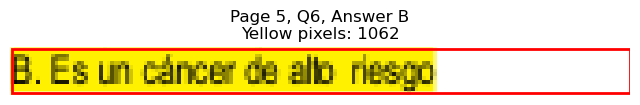

Page 5, Q6 - C: Detected box: x0=71.3, y0=555.4, x1=134.6, y1=567.5
Page 5, Q6, C: Yellow pixels: 113
Page 5, Q6, C: Total non-white pixels: 555
Page 5, Q6, C: Yellow percentage: 20.4%


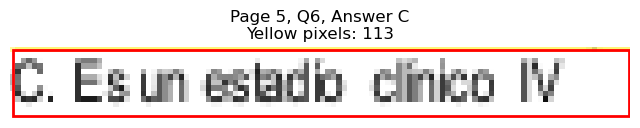

Page 5, Q6 - D: Detected box: x0=322.9, y0=531.4, x1=460.3, y1=543.5
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 684
Page 5, Q6, D: Yellow percentage: 0.0%


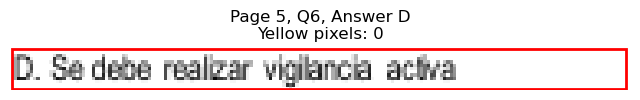

Page 5, Q6 - E: Detected box: x0=322.9, y0=543.4, x1=430.3, y1=555.5
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 544
Page 5, Q6, E: Yellow percentage: 0.0%


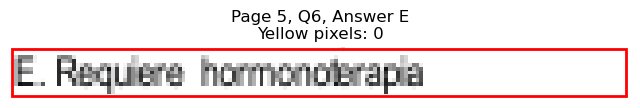


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=591.5, x1=145.1, y1=603.5
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 318
Page 5, Q7, A: Yellow percentage: 0.0%


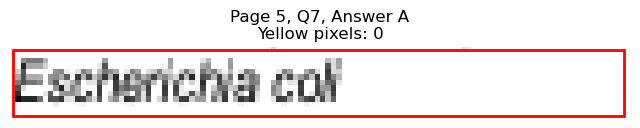

Page 5, Q7 - B: Detected box: x0=71.3, y0=603.5, x1=178.9, y1=615.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 539
Page 5, Q7, B: Yellow percentage: 0.0%


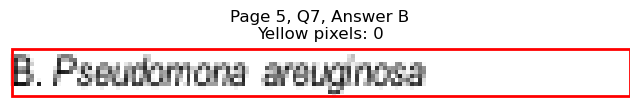

Page 5, Q7 - C: Detected box: x0=71.3, y0=615.5, x1=199.9, y1=627.5
Page 5, Q7, C: Yellow pixels: 1158
Page 5, Q7, C: Total non-white pixels: 1651
Page 5, Q7, C: Yellow percentage: 70.1%


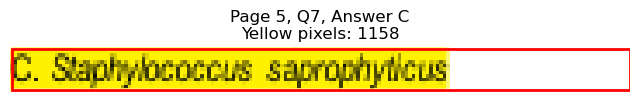

Page 5, Q7 - D: Detected box: x0=322.9, y0=591.5, x1=437.9, y1=603.5
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 586
Page 5, Q7, D: Yellow percentage: 0.0%


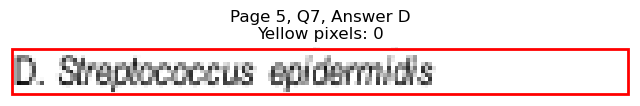

Page 5, Q7 - E: Detected box: x0=322.9, y0=603.5, x1=400.4, y1=615.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 372
Page 5, Q7, E: Yellow percentage: 0.0%


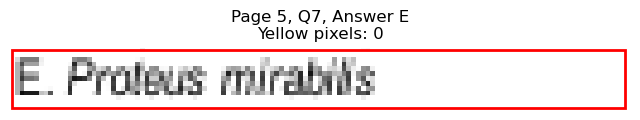


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=651.5, x1=183.3, y1=663.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 484
Page 5, Q8, A: Yellow percentage: 0.0%


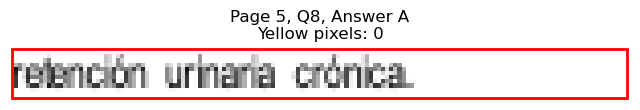

Page 5, Q8 - B: Detected box: x0=71.3, y0=663.5, x1=148.0, y1=675.6
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 609
Page 5, Q8, B: Yellow percentage: 0.0%


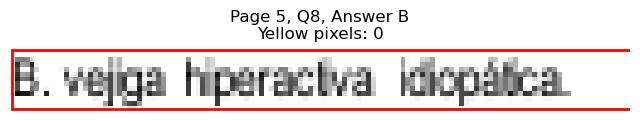

Page 5, Q8 - C: Detected box: x0=71.3, y0=676.3, x1=148.7, y1=688.3
Page 5, Q8, C: Yellow pixels: 973
Page 5, Q8, C: Total non-white pixels: 1599
Page 5, Q8, C: Yellow percentage: 60.9%


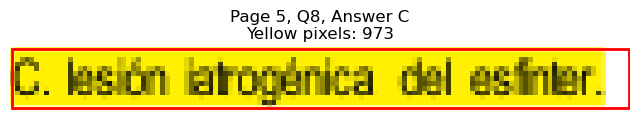

Page 5, Q8 - D: Detected box: x0=370.9, y0=651.5, x1=452.2, y1=663.6
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 409
Page 5, Q8, D: Yellow percentage: 0.0%


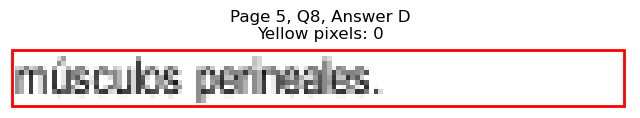

Page 5, Q8 - E: Detected box: x0=359.6, y0=663.5, x1=414.7, y1=675.6
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 302
Page 5, Q8, E: Yellow percentage: 0.0%


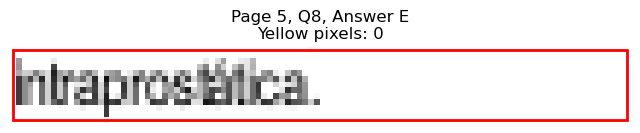


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=129.1, y0=736.4, x1=182.6, y1=748.4
Page 5, Q9, A: Yellow pixels: 463
Page 5, Q9, A: Total non-white pixels: 676
Page 5, Q9, A: Yellow percentage: 68.5%


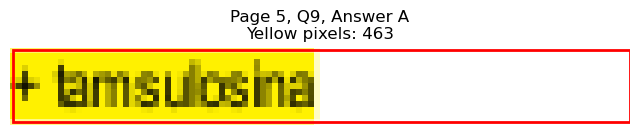

Page 5, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=180.3, y1=760.4
Page 5, Q9, B: Yellow pixels: 97
Page 5, Q9, B: Total non-white pixels: 597
Page 5, Q9, B: Yellow percentage: 16.2%


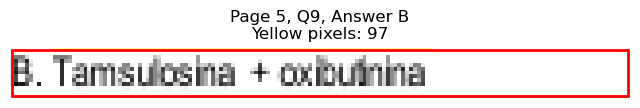

Page 5, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=125.5, y1=772.4
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 499
Page 5, Q9, C: Yellow percentage: 0.0%


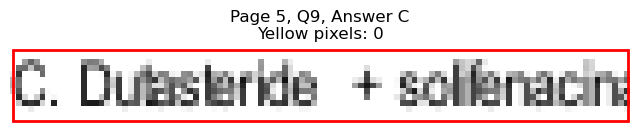

Page 5, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=376.3, y1=748.4
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 514
Page 5, Q9, D: Yellow percentage: 0.0%


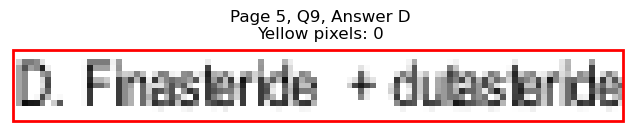

Page 5, Q9 - E: Detected box: x0=322.9, y0=748.4, x1=375.5, y1=760.4
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 498
Page 5, Q9, E: Yellow percentage: 0.0%


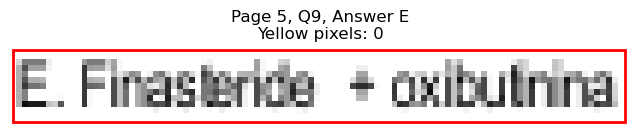


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=119.3, y0=96.8, x1=180.3, y1=108.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 276
Page 6, Q1, A: Yellow percentage: 0.0%


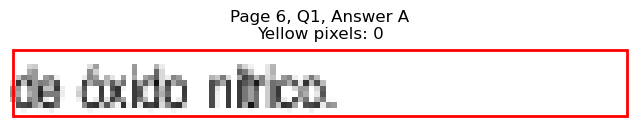

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=175.1, y1=121.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 500
Page 6, Q1, B: Yellow percentage: 0.0%


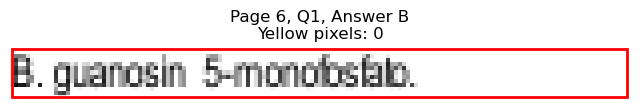

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=149.6, y1=133.6
Page 6, Q1, C: Yellow pixels: 671
Page 6, Q1, C: Total non-white pixels: 1001
Page 6, Q1, C: Yellow percentage: 67.0%


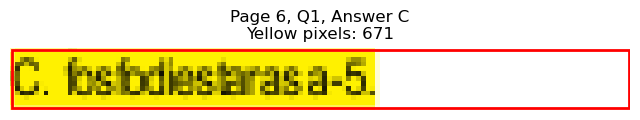

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=401.8, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 389
Page 6, Q1, D: Yellow percentage: 0.0%


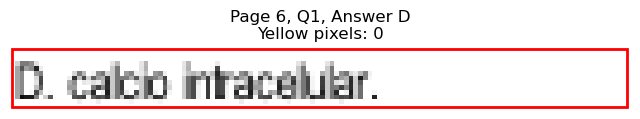

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=398.1, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 349
Page 6, Q1, E: Yellow percentage: 0.0%


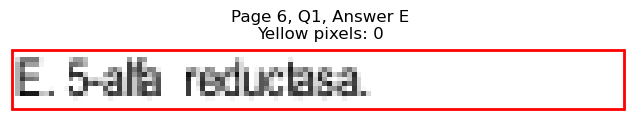


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=169.7, y0=157.6, x1=259.1, y1=169.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 442
Page 6, Q2, A: Yellow percentage: 0.0%


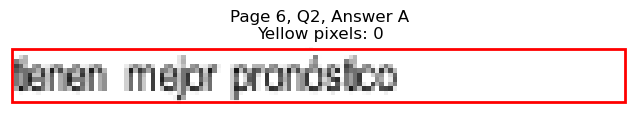

Page 6, Q2 - B: Detected box: x0=148.6, y0=169.6, x1=265.0, y1=181.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 554
Page 6, Q2, B: Yellow percentage: 0.0%


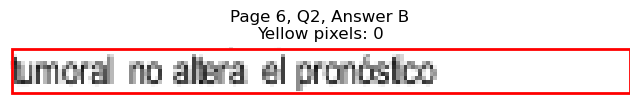

Page 6, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=255.2, y1=193.6
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 857
Page 6, Q2, C: Yellow percentage: 0.0%


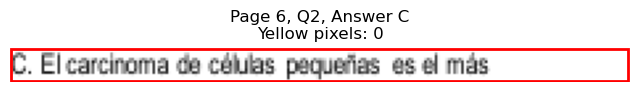

Page 6, Q2 - D: Detected box: x0=403.1, y0=157.6, x1=498.5, y1=169.6
Page 6, Q2, D: Yellow pixels: 749
Page 6, Q2, D: Total non-white pixels: 1222
Page 6, Q2, D: Yellow percentage: 61.3%


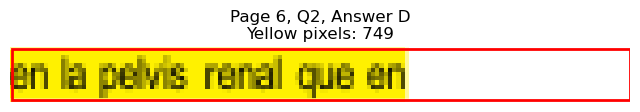

Page 6, Q2 - E: Detected box: x0=403.1, y0=181.6, x1=507.5, y1=193.6
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 501
Page 6, Q2, E: Yellow percentage: 0.0%


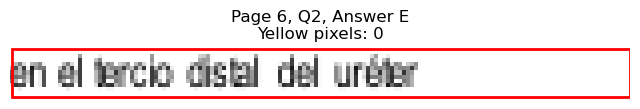


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=143.4, y1=265.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 299
Page 6, Q3, A: Yellow percentage: 0.0%


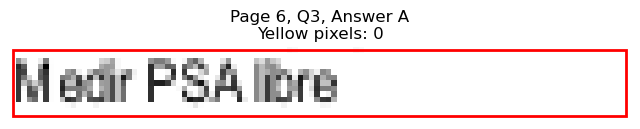

Page 6, Q3 - B: Detected box: x0=120.0, y0=265.7, x1=176.4, y1=277.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 257
Page 6, Q3, B: Yellow percentage: 0.0%


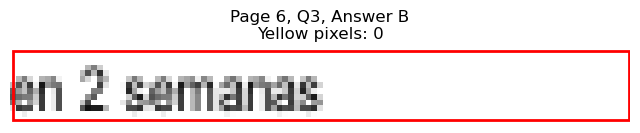

Page 6, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=202.0, y1=289.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 624
Page 6, Q3, C: Yellow percentage: 0.0%


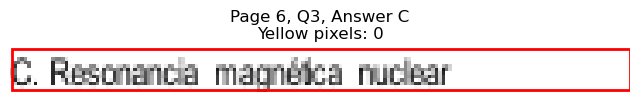

Page 6, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=401.9, y1=265.7
Page 6, Q3, D: Yellow pixels: 925
Page 6, Q3, D: Total non-white pixels: 1573
Page 6, Q3, D: Yellow percentage: 58.8%


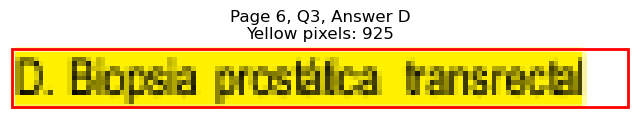

Page 6, Q3 - E: Detected box: x0=388.2, y0=265.7, x1=453.6, y1=277.7
Page 6, Q3, E: Yellow pixels: 54
Page 6, Q3, E: Total non-white pixels: 334
Page 6, Q3, E: Yellow percentage: 16.2%


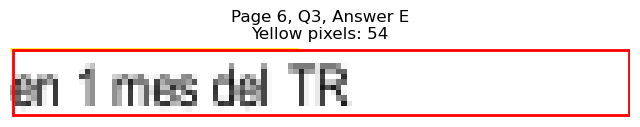


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=180.9, y1=338.5
Page 6, Q4, A: Yellow pixels: 1325
Page 6, Q4, A: Total non-white pixels: 1937
Page 6, Q4, A: Yellow percentage: 68.4%


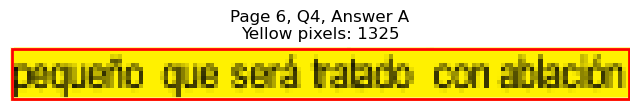

Page 6, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=178.0, y1=362.5
Page 6, Q4, B: Yellow pixels: 58
Page 6, Q4, B: Total non-white pixels: 700
Page 6, Q4, B: Yellow percentage: 8.3%


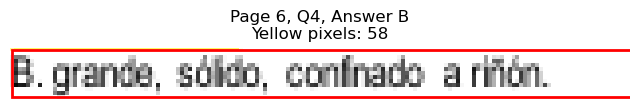

Page 6, Q4 - C: Detected box: x0=117.1, y0=362.5, x1=166.8, y1=374.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 463
Page 6, Q4, C: Yellow percentage: 0.0%


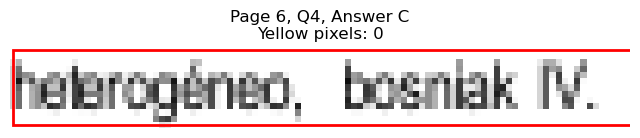

Page 6, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=443.8, y1=338.5
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 801
Page 6, Q4, D: Yellow percentage: 0.0%


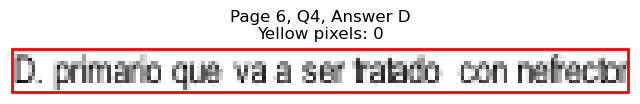

Page 6, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=443.0, y1=362.5
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 797
Page 6, Q4, E: Yellow percentage: 0.0%


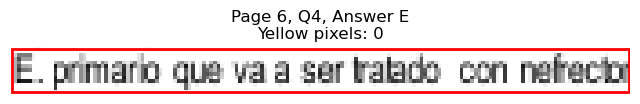


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=145.1, y1=446.6
Page 6, Q5, A: Yellow pixels: 423
Page 6, Q5, A: Total non-white pixels: 793
Page 6, Q5, A: Yellow percentage: 53.3%


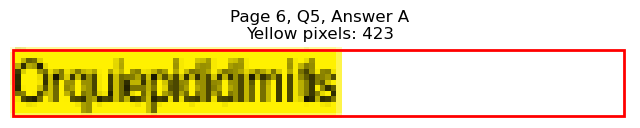

Page 6, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=142.7, y1=458.6
Page 6, Q5, B: Yellow pixels: 60
Page 6, Q5, B: Total non-white pixels: 402
Page 6, Q5, B: Yellow percentage: 14.9%


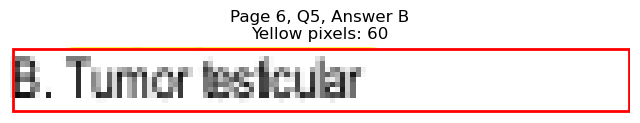

Page 6, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=147.2, y1=470.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 358
Page 6, Q5, C: Yellow percentage: 0.0%


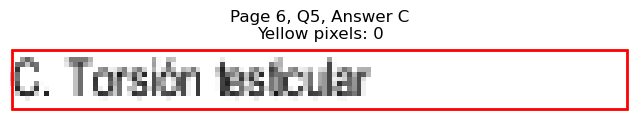

Page 6, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=391.3, y1=446.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 342
Page 6, Q5, D: Yellow percentage: 0.0%


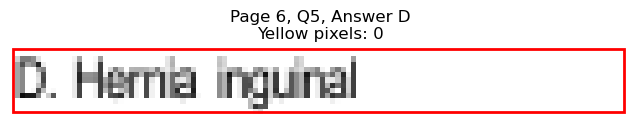

Page 6, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=409.4, y1=458.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 439
Page 6, Q5, E: Yellow percentage: 0.0%


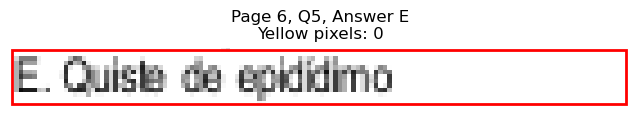


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=507.4, x1=251.7, y1=519.4
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 790
Page 6, Q6, A: Yellow percentage: 0.0%


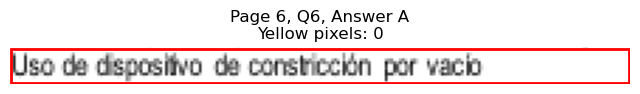

Page 6, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=194.5, y1=531.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 867
Page 6, Q6, B: Yellow percentage: 0.0%


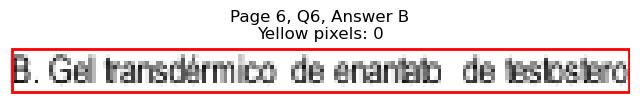

Page 6, Q6 - C: Detected box: x0=71.3, y0=531.4, x1=212.6, y1=543.5
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 710
Page 6, Q6, C: Yellow percentage: 0.0%


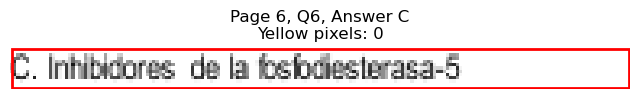

Page 6, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=428.8, y1=519.4
Page 6, Q6, D: Yellow pixels: 1404
Page 6, Q6, D: Total non-white pixels: 2041
Page 6, Q6, D: Yellow percentage: 68.8%


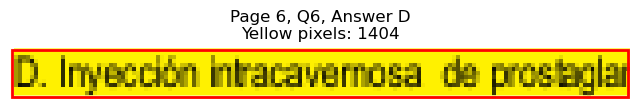

Page 6, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=485.1, y1=531.4
Page 6, Q6, E: Yellow pixels: 185
Page 6, Q6, E: Total non-white pixels: 982
Page 6, Q6, E: Yellow percentage: 18.8%


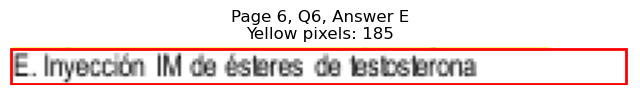


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=567.5, x1=194.5, y1=579.5
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 541
Page 6, Q7, A: Yellow percentage: 0.0%


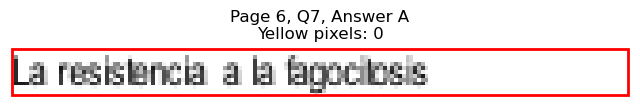

Page 6, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=219.4, y1=591.5
Page 6, Q7, B: Yellow pixels: 1286
Page 6, Q7, B: Total non-white pixels: 1911
Page 6, Q7, B: Yellow percentage: 67.3%


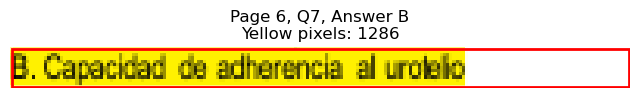

Page 6, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=163.7, y1=603.5
Page 6, Q7, C: Yellow pixels: 142
Page 6, Q7, C: Total non-white pixels: 818
Page 6, Q7, C: Yellow percentage: 17.4%


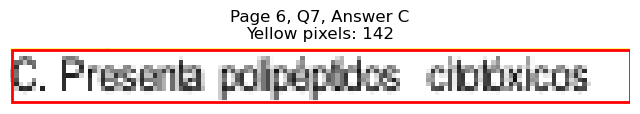

Page 6, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=469.3, y1=579.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 680
Page 6, Q7, D: Yellow percentage: 0.0%


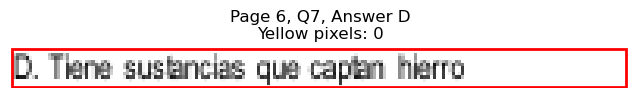

Page 6, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=462.5, y1=591.5
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 682
Page 6, Q7, E: Yellow percentage: 0.0%


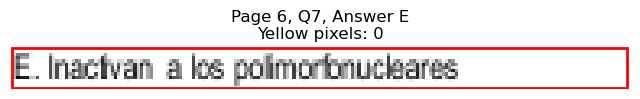


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=145.0, y1=651.6
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 315
Page 6, Q8, A: Yellow percentage: 0.0%


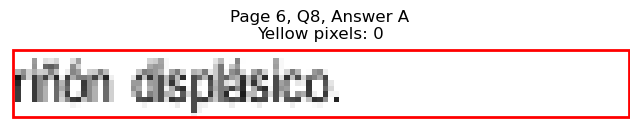

Page 6, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=157.7, y1=663.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 396
Page 6, Q8, B: Yellow percentage: 0.0%


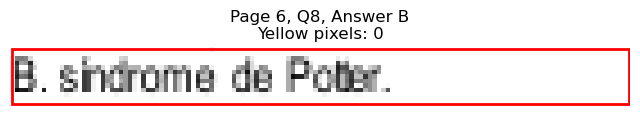

Page 6, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=146.6, y1=675.6
Page 6, Q8, C: Yellow pixels: 615
Page 6, Q8, C: Total non-white pixels: 962
Page 6, Q8, C: Yellow percentage: 63.9%


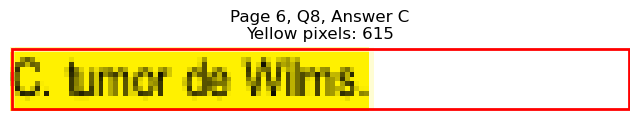

Page 6, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=404.0, y1=651.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 400
Page 6, Q8, D: Yellow percentage: 0.0%


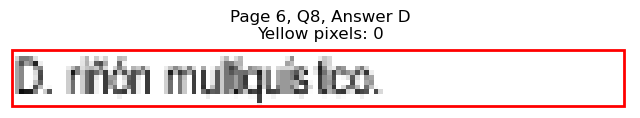

Page 6, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=397.3, y1=663.6
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 321
Page 6, Q8, E: Yellow percentage: 0.0%


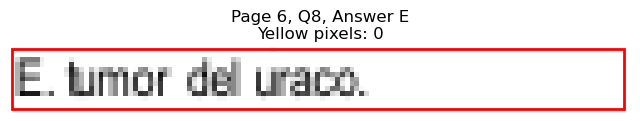


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=712.3, x1=127.0, y1=724.4
Page 6, Q9, A: Yellow pixels: 310
Page 6, Q9, A: Total non-white pixels: 560
Page 6, Q9, A: Yellow percentage: 55.4%


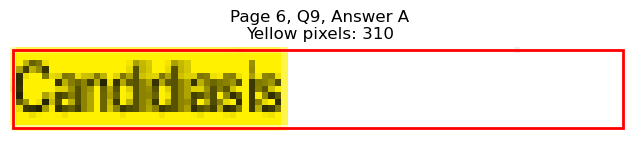

Page 6, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=148.8, y1=736.4
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 405
Page 6, Q9, B: Yellow percentage: 0.0%


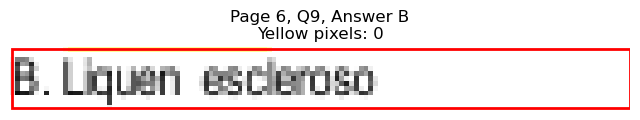

Page 6, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=132.3, y1=748.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 277
Page 6, Q9, C: Yellow percentage: 0.0%


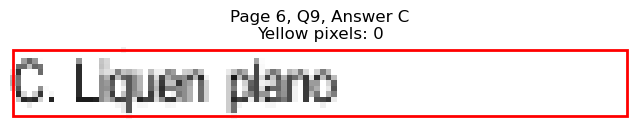

Page 6, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=378.5, y1=724.4
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 284
Page 6, Q9, D: Yellow percentage: 0.0%


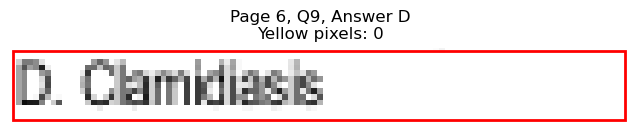

Page 6, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=377.9, y1=736.4
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 269
Page 6, Q9, E: Yellow percentage: 0.0%


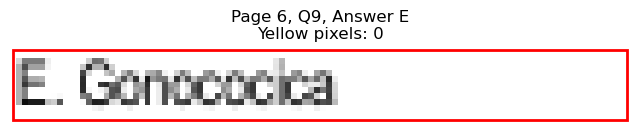


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=196.1, y1=108.8
Page 7, Q1, A: Yellow pixels: 856
Page 7, Q1, A: Total non-white pixels: 1458
Page 7, Q1, A: Yellow percentage: 58.7%


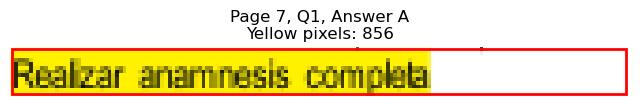

Page 7, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=150.2, y1=121.6
Page 7, Q1, B: Yellow pixels: 111
Page 7, Q1, B: Total non-white pixels: 741
Page 7, Q1, B: Yellow percentage: 15.0%


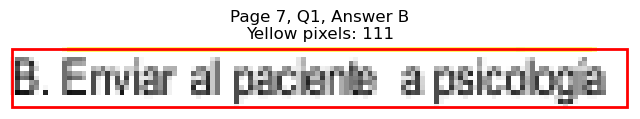

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=154.0, y1=133.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 596
Page 7, Q1, C: Yellow percentage: 0.0%


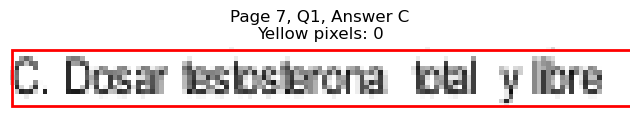

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=398.9, y1=108.8
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 610
Page 7, Q1, D: Yellow percentage: 0.0%


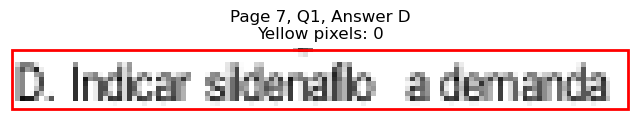

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=394.3, y1=121.6
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 490
Page 7, Q1, E: Yellow percentage: 0.0%


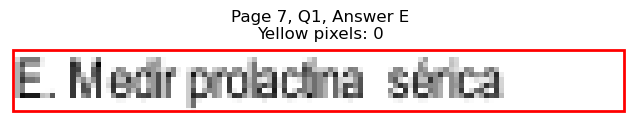


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=110.3, y0=181.6, x1=135.2, y1=193.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 136
Page 7, Q2, A: Yellow percentage: 0.0%


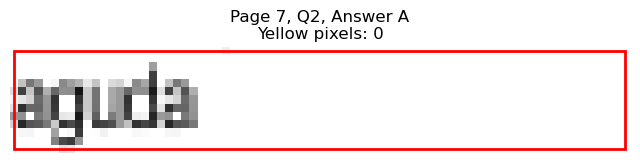

Page 7, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=139.7, y1=205.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 339
Page 7, Q2, B: Yellow percentage: 0.0%


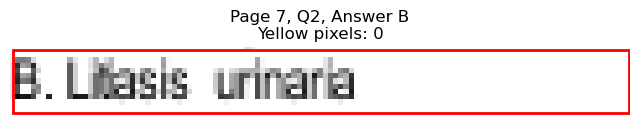

Page 7, Q2 - C: Detected box: x0=110.3, y0=205.6, x1=151.7, y1=217.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 222
Page 7, Q2, C: Yellow percentage: 0.0%


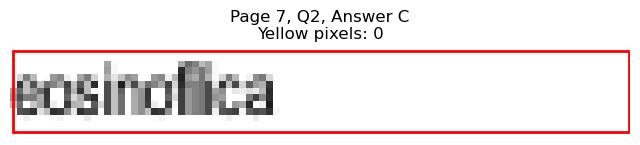

Page 7, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=377.0, y1=193.6
Page 7, Q2, D: Yellow pixels: 621
Page 7, Q2, D: Total non-white pixels: 1066
Page 7, Q2, D: Yellow percentage: 58.3%


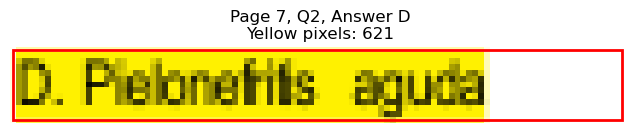

Page 7, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=424.3, y1=205.6
Page 7, Q2, E: Yellow pixels: 80
Page 7, Q2, E: Total non-white pixels: 607
Page 7, Q2, E: Yellow percentage: 13.2%


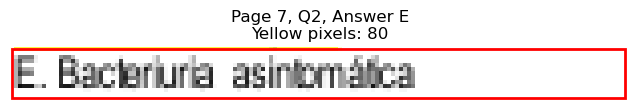


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=202.7, y1=265.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 542
Page 7, Q3, A: Yellow percentage: 0.0%


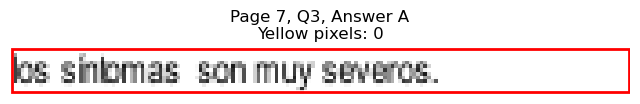

Page 7, Q3 - B: Detected box: x0=126.1, y0=265.7, x1=192.2, y1=277.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 340
Page 7, Q3, B: Yellow percentage: 0.0%


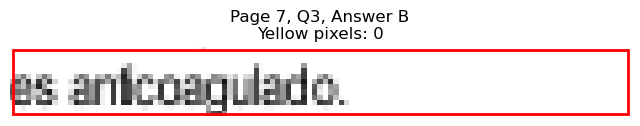

Page 7, Q3 - C: Detected box: x0=125.3, y0=277.7, x1=186.3, y1=289.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 319
Page 7, Q3, C: Yellow percentage: 0.0%


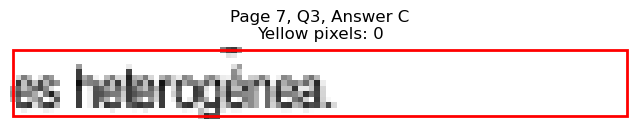

Page 7, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=452.1, y1=265.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 623
Page 7, Q3, D: Yellow percentage: 0.0%


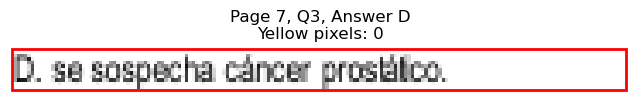

Page 7, Q3 - E: Detected box: x0=376.1, y0=265.7, x1=436.4, y1=277.7
Page 7, Q3, E: Yellow pixels: 467
Page 7, Q3, E: Total non-white pixels: 766
Page 7, Q3, E: Yellow percentage: 61.0%


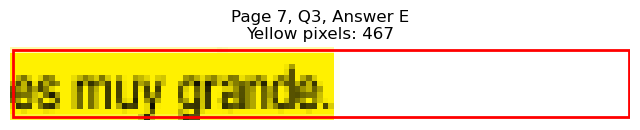


Page 7, Q3 - Selected Answer: E (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=148.7, y1=326.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 537
Page 7, Q4, A: Yellow percentage: 0.0%


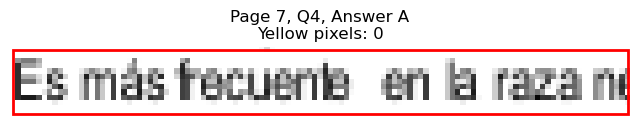

Page 7, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=178.0, y1=338.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 658
Page 7, Q4, B: Yellow percentage: 0.0%


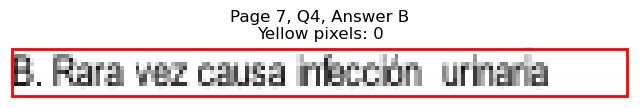

Page 7, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=225.4, y1=350.5
Page 7, Q4, C: Yellow pixels: 1381
Page 7, Q4, C: Total non-white pixels: 1989
Page 7, Q4, C: Yellow percentage: 69.4%


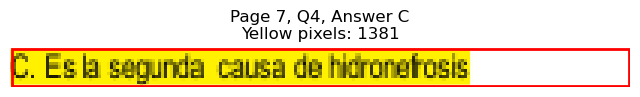

Page 7, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=479.0, y1=326.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 723
Page 7, Q4, D: Yellow percentage: 0.0%


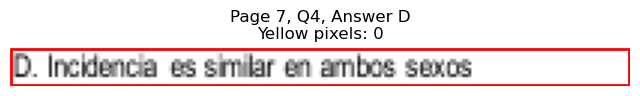

Page 7, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=456.5, y1=338.5
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 622
Page 7, Q4, E: Yellow percentage: 0.0%


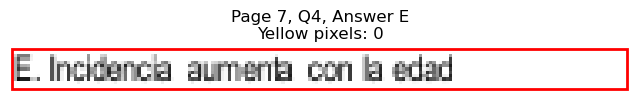


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=139.8, y1=386.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 299
Page 7, Q5, A: Yellow percentage: 0.0%


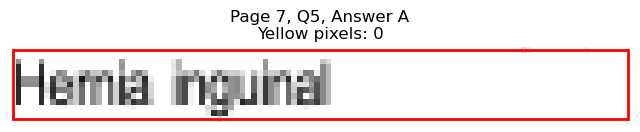

Page 7, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=134.5, y1=398.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 342
Page 7, Q5, B: Yellow percentage: 0.0%


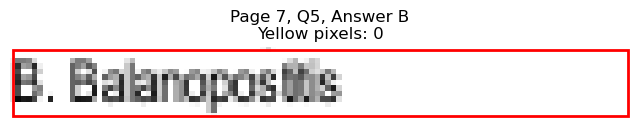

Page 7, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=143.5, y1=410.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 340
Page 7, Q5, C: Yellow percentage: 0.0%


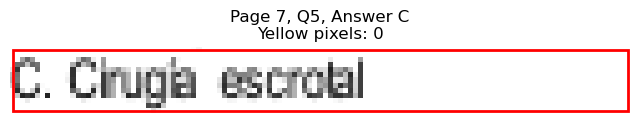

Page 7, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=381.6, y1=386.6
Page 7, Q5, D: Yellow pixels: 479
Page 7, Q5, D: Total non-white pixels: 754
Page 7, Q5, D: Yellow percentage: 63.5%


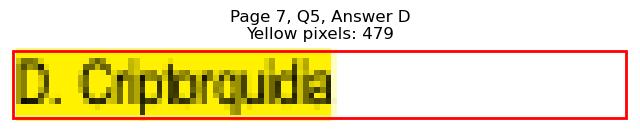

Page 7, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=399.5, y1=398.6
Page 7, Q5, E: Yellow pixels: 56
Page 7, Q5, E: Total non-white pixels: 430
Page 7, Q5, E: Yellow percentage: 13.0%


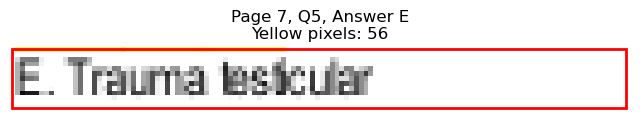


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=133.0, y1=458.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 289
Page 7, Q6, A: Yellow percentage: 0.0%


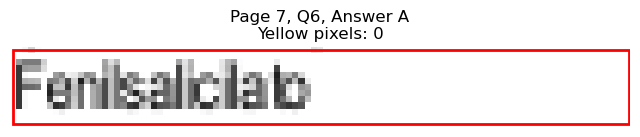

Page 7, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=195.2, y1=470.6
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 636
Page 7, Q6, B: Yellow percentage: 0.0%


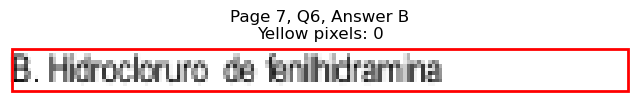

Page 7, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=146.5, y1=482.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 457
Page 7, Q6, C: Yellow percentage: 0.0%


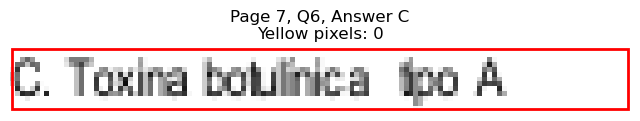

Page 7, Q6 - D: Detected box: x0=376.1, y0=446.6, x1=428.2, y1=458.6
Page 7, Q6, D: Yellow pixels: 384
Page 7, Q6, D: Total non-white pixels: 650
Page 7, Q6, D: Yellow percentage: 59.1%


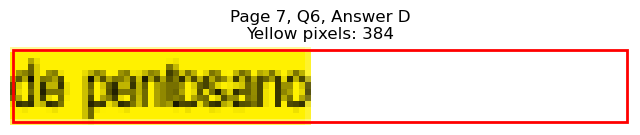

Page 7, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=392.1, y1=470.6
Page 7, Q6, E: Yellow pixels: 103
Page 7, Q6, E: Total non-white pixels: 467
Page 7, Q6, E: Yellow percentage: 22.1%


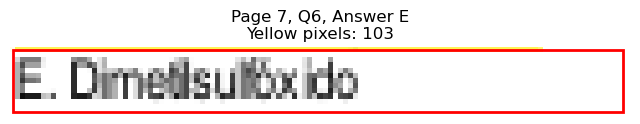


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=228.2, y1=519.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 714
Page 7, Q7, A: Yellow percentage: 0.0%


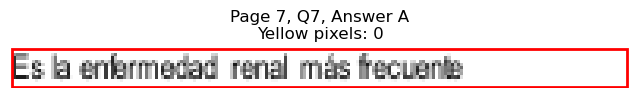

Page 7, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=236.7, y1=531.4
Page 7, Q7, B: Yellow pixels: 1430
Page 7, Q7, B: Total non-white pixels: 2132
Page 7, Q7, B: Yellow percentage: 67.1%


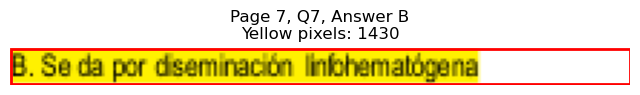

Page 7, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=163.0, y1=543.5
Page 7, Q7, C: Yellow pixels: 141
Page 7, Q7, C: Total non-white pixels: 760
Page 7, Q7, C: Yellow percentage: 18.6%


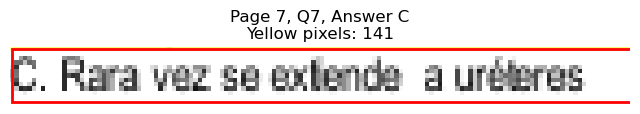

Page 7, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=504.5, y1=519.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 815
Page 7, Q7, D: Yellow percentage: 0.0%


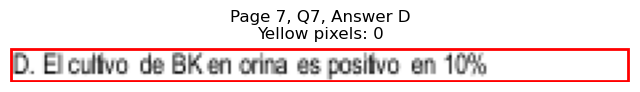

Page 7, Q7 - E: Detected box: x0=382.1, y0=519.4, x1=479.8, y1=531.4
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 510
Page 7, Q7, E: Yellow percentage: 0.0%


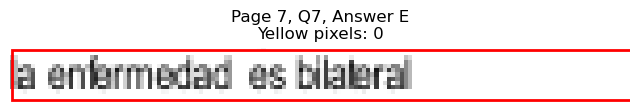


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=138.2, y1=579.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 260
Page 7, Q8, A: Yellow percentage: 0.0%


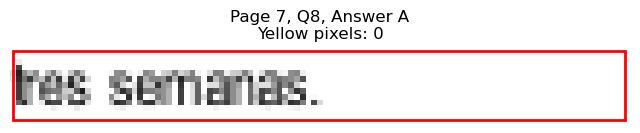

Page 7, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=122.5, y1=591.5
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 227
Page 7, Q8, B: Yellow percentage: 0.0%


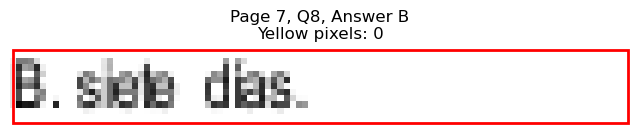

Page 7, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=124.7, y1=603.5
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 225
Page 7, Q8, C: Yellow percentage: 0.0%


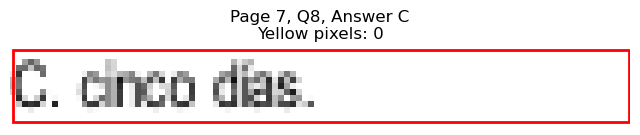

Page 7, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=389.1, y1=579.5
Page 7, Q8, D: Yellow pixels: 588
Page 7, Q8, D: Total non-white pixels: 845
Page 7, Q8, D: Yellow percentage: 69.6%


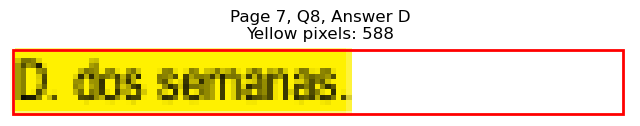

Page 7, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=369.5, y1=591.5
Page 7, Q8, E: Yellow pixels: 63
Page 7, Q8, E: Total non-white pixels: 258
Page 7, Q8, E: Yellow percentage: 24.4%


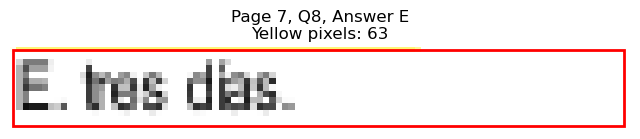


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=135.2, y1=639.6
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 296
Page 7, Q9, A: Yellow percentage: 0.0%


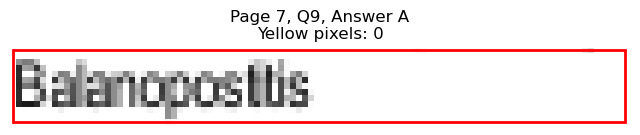

Page 7, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=159.2, y1=651.6
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 434
Page 7, Q9, B: Yellow percentage: 0.0%


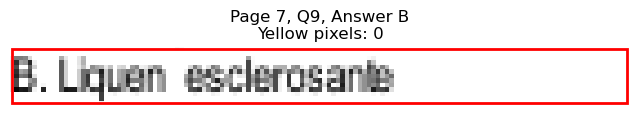

Page 7, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=121.0, y1=663.6
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 445
Page 7, Q9, C: Yellow percentage: 0.0%


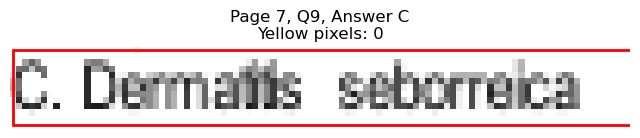

Page 7, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=422.9, y1=639.6
Page 7, Q9, D: Yellow pixels: 872
Page 7, Q9, D: Total non-white pixels: 1287
Page 7, Q9, D: Yellow percentage: 67.8%


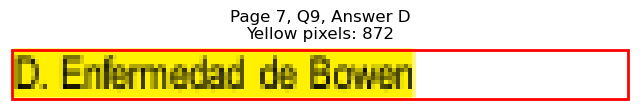

Page 7, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=383.8, y1=651.6
Page 7, Q9, E: Yellow pixels: 97
Page 7, Q9, E: Total non-white pixels: 379
Page 7, Q9, E: Yellow percentage: 25.6%


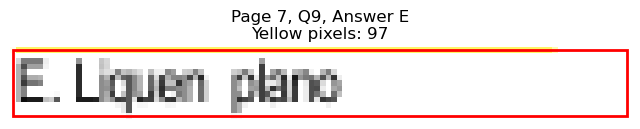


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=123.2, y1=712.3
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 204
Page 7, Q10, A: Yellow percentage: 0.0%


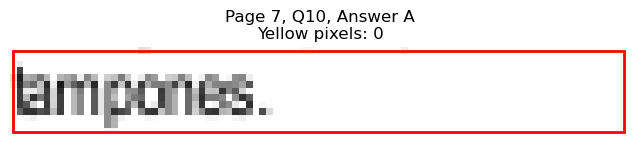

Page 7, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=131.5, y1=724.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 291
Page 7, Q10, B: Yellow percentage: 0.0%


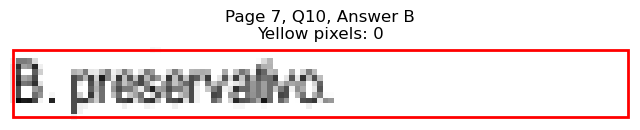

Page 7, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=136.8, y1=736.4
Page 7, Q10, C: Yellow pixels: 517
Page 7, Q10, C: Total non-white pixels: 832
Page 7, Q10, C: Yellow percentage: 62.1%


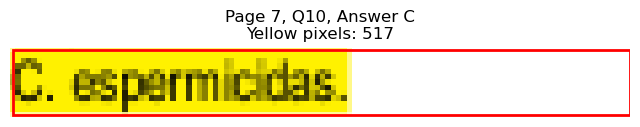

Page 7, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=386.8, y1=712.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 311
Page 7, Q10, D: Yellow percentage: 0.0%


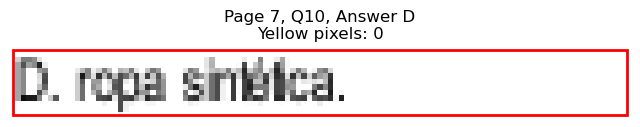

Page 7, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=386.8, y1=724.4
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 318
Page 7, Q10, E: Yellow percentage: 0.0%


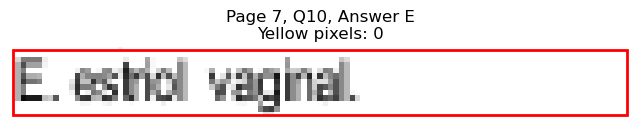


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=179.5, y1=108.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 723
Page 8, Q1, A: Yellow percentage: 0.0%


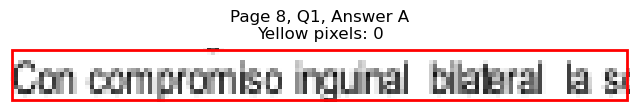

Page 8, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=244.9, y1=133.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 880
Page 8, Q1, B: Yellow percentage: 0.0%


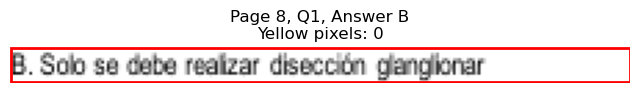

Page 8, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=276.9, y1=157.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 980
Page 8, Q1, C: Yellow percentage: 0.0%


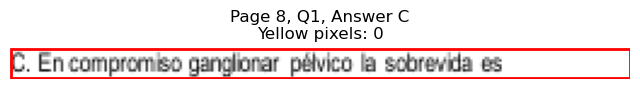

Page 8, Q1 - D: Detected box: x0=312.4, y0=96.8, x1=408.5, y1=108.8
Page 8, Q1, D: Yellow pixels: 1187
Page 8, Q1, D: Total non-white pixels: 1911
Page 8, Q1, D: Yellow percentage: 62.1%


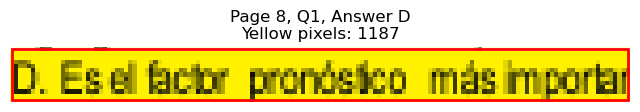

Page 8, Q1 - E: Detected box: x0=312.4, y0=121.5, x1=413.0, y1=133.6
Page 8, Q1, E: Yellow pixels: 35
Page 8, Q1, E: Total non-white pixels: 786
Page 8, Q1, E: Yellow percentage: 4.5%


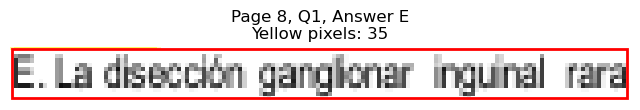


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=148.1, y1=205.6
Page 8, Q2, A: Yellow pixels: 526
Page 8, Q2, A: Total non-white pixels: 832
Page 8, Q2, A: Yellow percentage: 63.2%


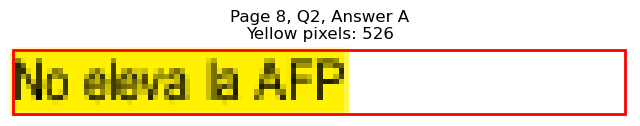

Page 8, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=160.7, y1=217.7
Page 8, Q2, B: Yellow pixels: 63
Page 8, Q2, B: Total non-white pixels: 696
Page 8, Q2, B: Yellow percentage: 9.1%


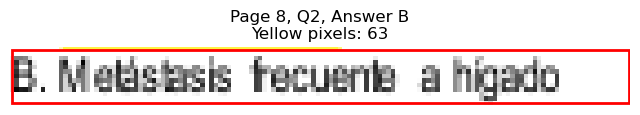

Page 8, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=184.0, y1=229.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 546
Page 8, Q2, C: Yellow percentage: 0.0%


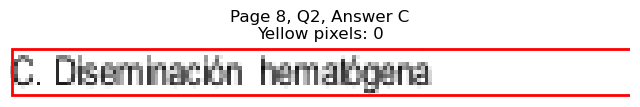

Page 8, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=403.3, y1=205.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 382
Page 8, Q2, D: Yellow percentage: 0.0%


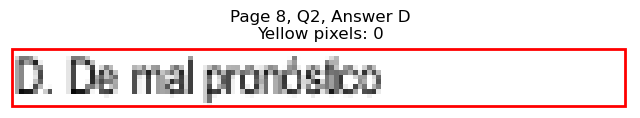

Page 8, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=387.5, y1=217.7
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 555
Page 8, Q2, E: Yellow percentage: 0.0%


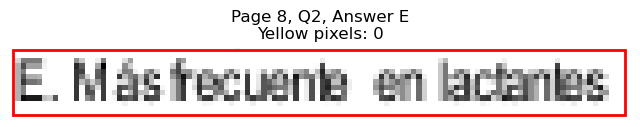


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=181.0, y1=265.7
Page 8, Q3, A: Yellow pixels: 1166
Page 8, Q3, A: Total non-white pixels: 1937
Page 8, Q3, A: Yellow percentage: 60.2%


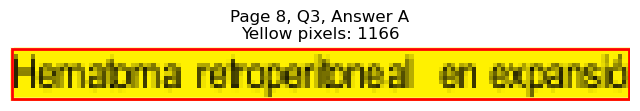

Page 8, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=235.0, y1=277.7
Page 8, Q3, B: Yellow pixels: 182
Page 8, Q3, B: Total non-white pixels: 967
Page 8, Q3, B: Yellow percentage: 18.8%


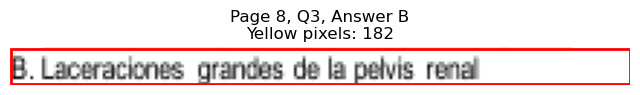

Page 8, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=264.2, y1=289.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 916
Page 8, Q3, C: Yellow percentage: 0.0%


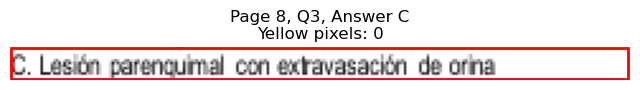

Page 8, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=446.0, y1=265.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 604
Page 8, Q3, D: Yellow percentage: 0.0%


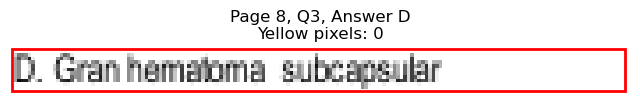

Page 8, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=380.8, y1=277.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 534
Page 8, Q3, E: Yellow percentage: 0.0%


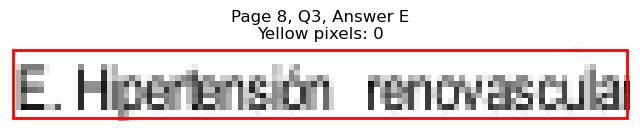


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=157.0, y1=362.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 372
Page 8, Q4, A: Yellow percentage: 0.0%


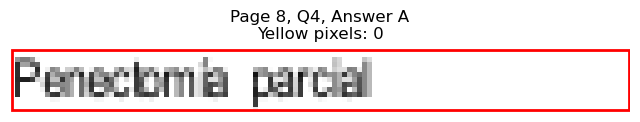

Page 8, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=127.7, y1=374.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 359
Page 8, Q4, B: Yellow percentage: 0.0%


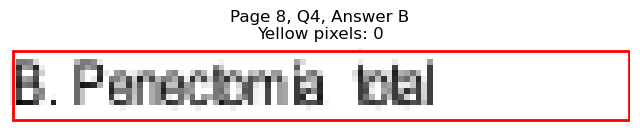

Page 8, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=193.8, y1=386.6
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 589
Page 8, Q4, C: Yellow percentage: 0.0%


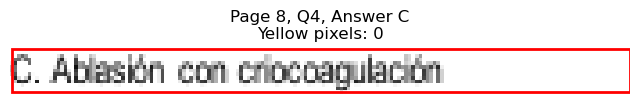

Page 8, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=434.2, y1=362.5
Page 8, Q4, D: Yellow pixels: 964
Page 8, Q4, D: Total non-white pixels: 1430
Page 8, Q4, D: Yellow percentage: 67.4%


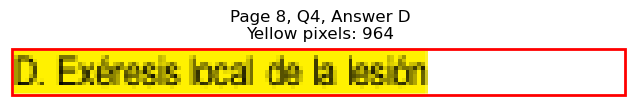

Page 8, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=386.0, y1=374.6
Page 8, Q4, E: Yellow pixels: 109
Page 8, Q4, E: Total non-white pixels: 632
Page 8, Q4, E: Yellow percentage: 17.2%


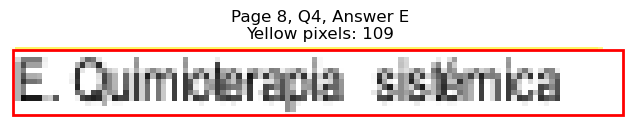


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=146.5, y1=422.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 308
Page 8, Q5, A: Yellow percentage: 0.0%


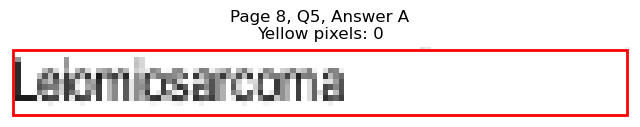

Page 8, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=139.7, y1=434.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 348
Page 8, Q5, B: Yellow percentage: 0.0%


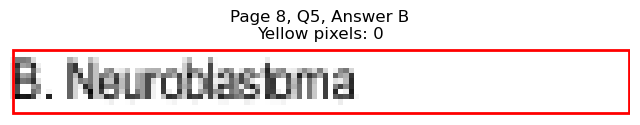

Page 8, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=155.5, y1=446.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 401
Page 8, Q5, C: Yellow percentage: 0.0%


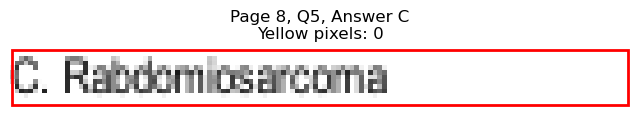

Page 8, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=389.1, y1=422.6
Page 8, Q5, D: Yellow pixels: 487
Page 8, Q5, D: Total non-white pixels: 845
Page 8, Q5, D: Yellow percentage: 57.6%


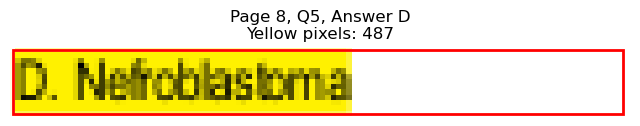

Page 8, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=380.0, y1=434.6
Page 8, Q5, E: Yellow pixels: 64
Page 8, Q5, E: Total non-white pixels: 337
Page 8, Q5, E: Yellow percentage: 19.0%


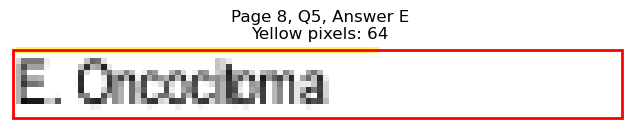


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=124.8, y1=507.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 237
Page 8, Q6, A: Yellow percentage: 0.0%


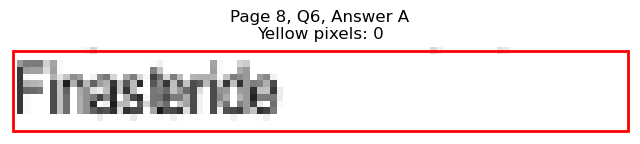

Page 8, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=131.6, y1=519.4
Page 8, Q6, B: Yellow pixels: 525
Page 8, Q6, B: Total non-white pixels: 767
Page 8, Q6, B: Yellow percentage: 68.4%


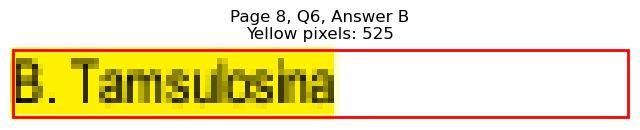

Page 8, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=124.7, y1=531.4
Page 8, Q6, C: Yellow pixels: 57
Page 8, Q6, C: Total non-white pixels: 313
Page 8, Q6, C: Yellow percentage: 18.2%


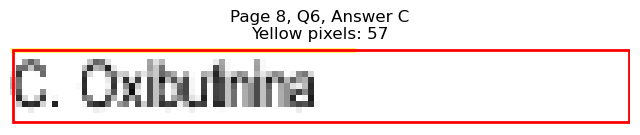

Page 8, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=380.0, y1=507.4
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 301
Page 8, Q6, D: Yellow percentage: 0.0%


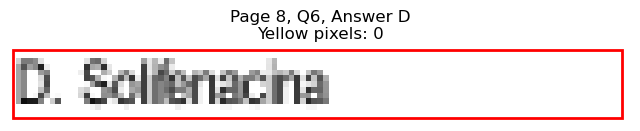

Page 8, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=376.3, y1=519.4
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 263
Page 8, Q6, E: Yellow percentage: 0.0%


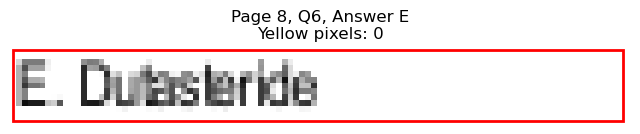


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=127.0, y1=591.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 222
Page 8, Q7, A: Yellow percentage: 0.0%


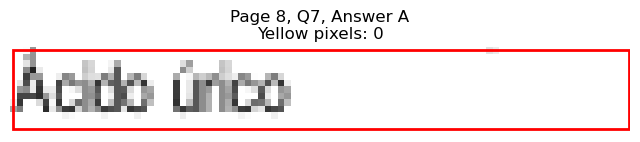

Page 8, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=149.6, y1=603.5
Page 8, Q7, B: Yellow pixels: 696
Page 8, Q7, B: Total non-white pixels: 1001
Page 8, Q7, B: Yellow percentage: 69.5%


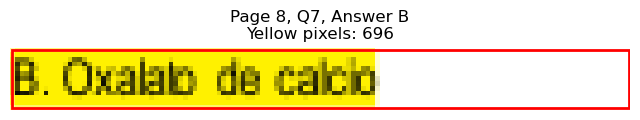

Page 8, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=187.0, y1=615.5
Page 8, Q7, C: Yellow pixels: 76
Page 8, Q7, C: Total non-white pixels: 638
Page 8, Q7, C: Yellow percentage: 11.9%


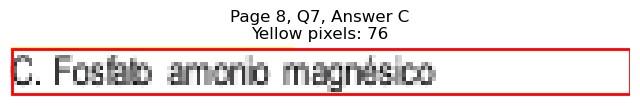

Page 8, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=360.5, y1=591.5
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 181
Page 8, Q7, D: Yellow percentage: 0.0%


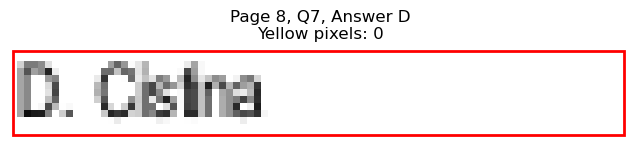

Page 8, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=362.0, y1=603.5
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 360
Page 8, Q7, E: Yellow percentage: 0.0%


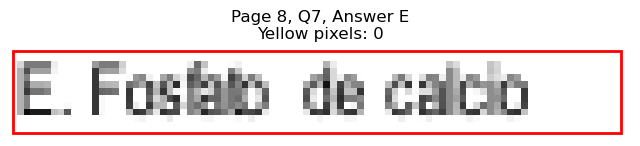


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=676.3, x1=141.3, y1=688.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 420
Page 8, Q8, A: Yellow percentage: 0.0%


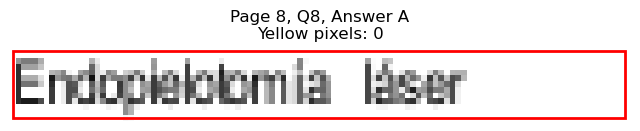

Page 8, Q8 - B: Detected box: x0=122.3, y0=688.3, x1=196.7, y1=700.3
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 386
Page 8, Q8, B: Yellow percentage: 0.0%


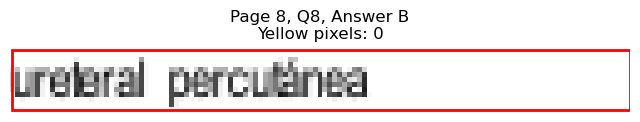

Page 8, Q8 - C: Detected box: x0=129.1, y0=700.3, x1=185.6, y1=712.3
Page 8, Q8, C: Yellow pixels: 415
Page 8, Q8, C: Total non-white pixels: 715
Page 8, Q8, C: Yellow percentage: 58.0%


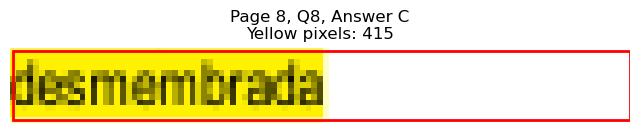

Page 8, Q8 - D: Detected box: x0=322.9, y0=676.3, x1=456.7, y1=688.3
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 657
Page 8, Q8, D: Yellow percentage: 0.0%


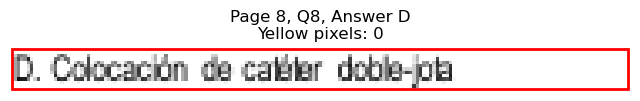

Page 8, Q8 - E: Detected box: x0=322.9, y0=688.3, x1=379.3, y1=700.3
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 541
Page 8, Q8, E: Yellow percentage: 0.0%


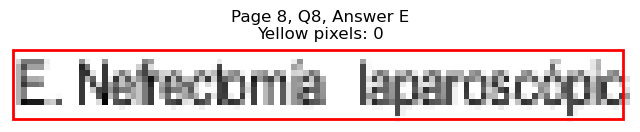


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=736.4, x1=219.3, y1=748.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 818
Page 8, Q9, A: Yellow percentage: 0.0%


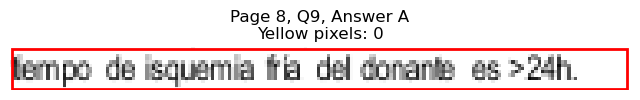

Page 8, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=157.0, y1=760.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 647
Page 8, Q9, B: Yellow percentage: 0.0%


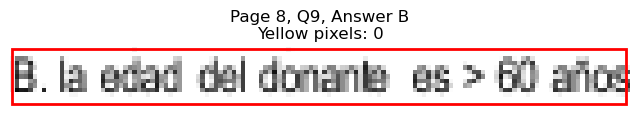

Page 8, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=247.7, y1=772.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 841
Page 8, Q9, C: Yellow percentage: 0.0%


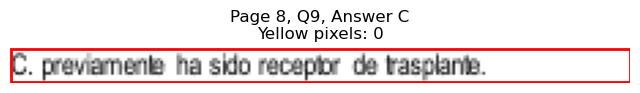

Page 8, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=507.0, y1=748.4
Page 8, Q9, D: Yellow pixels: 1691
Page 8, Q9, D: Total non-white pixels: 2379
Page 8, Q9, D: Yellow percentage: 71.1%


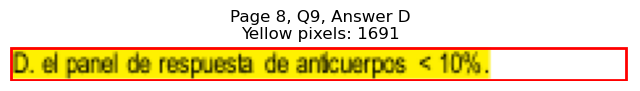

Page 8, Q9 - E: Detected box: x0=367.1, y0=748.4, x1=504.5, y1=760.4
Page 8, Q9, E: Yellow pixels: 137
Page 8, Q9, E: Total non-white pixels: 815
Page 8, Q9, E: Yellow percentage: 16.8%


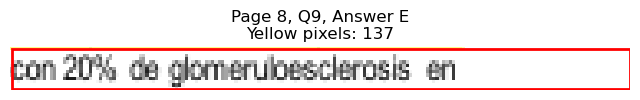


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=125.5, y1=108.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 234
Page 9, Q1, A: Yellow percentage: 0.0%


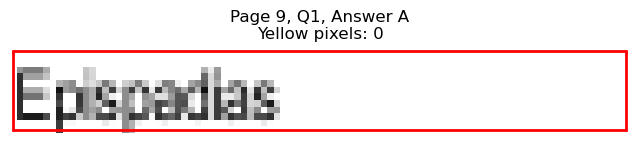

Page 9, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=124.0, y1=121.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 267
Page 9, Q1, B: Yellow percentage: 0.0%


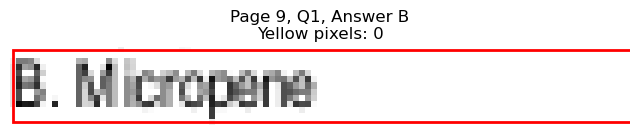

Page 9, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=130.0, y1=133.6
Page 9, Q1, C: Yellow pixels: 507
Page 9, Q1, C: Total non-white pixels: 741
Page 9, Q1, C: Yellow percentage: 68.4%


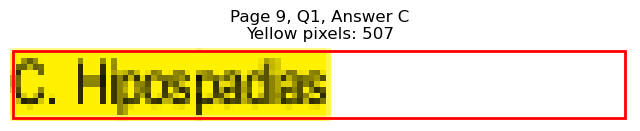

Page 9, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=365.8, y1=108.8
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 204
Page 9, Q1, D: Yellow percentage: 0.0%


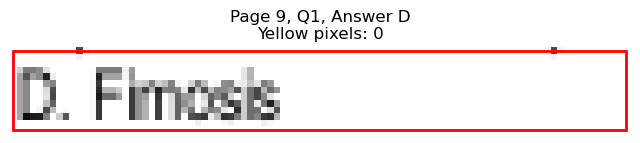

Page 9, Q1 - E: Detected box: x0=322.9, y0=362.5, x1=379.4, y1=374.6
Page 9, Q1, E: Yellow pixels: 484
Page 9, Q1, E: Total non-white pixels: 715
Page 9, Q1, E: Yellow percentage: 67.7%


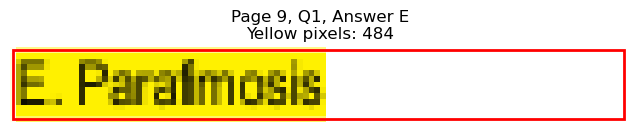


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=147.3, y1=193.6
Page 9, Q2, A: Yellow pixels: 479
Page 9, Q2, A: Total non-white pixels: 821
Page 9, Q2, A: Yellow percentage: 58.3%


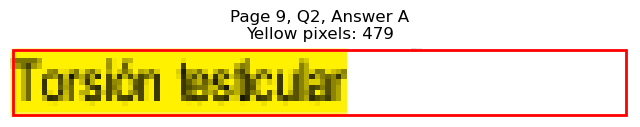

Page 9, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=122.5, y1=205.6
Page 9, Q2, B: Yellow pixels: 62
Page 9, Q2, B: Total non-white pixels: 308
Page 9, Q2, B: Yellow percentage: 20.1%


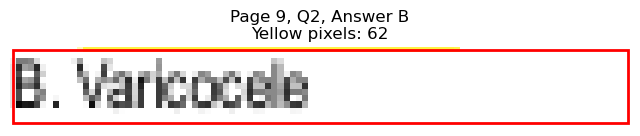

Page 9, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=142.8, y1=217.7
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 611
Page 9, Q2, C: Yellow percentage: 0.0%


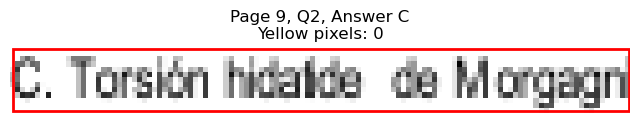

Page 9, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=371.0, y1=193.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 239
Page 9, Q2, D: Yellow percentage: 0.0%


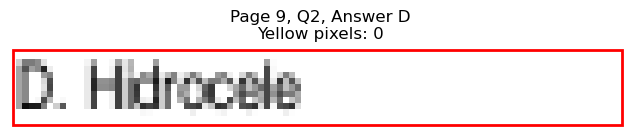

Page 9, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=390.5, y1=205.6
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 561
Page 9, Q2, E: Yellow percentage: 0.0%


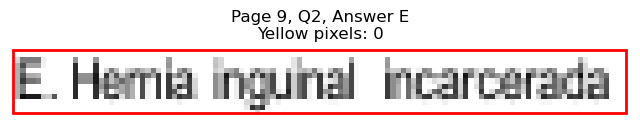


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=202.7, y1=277.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 595
Page 9, Q3, A: Yellow percentage: 0.0%


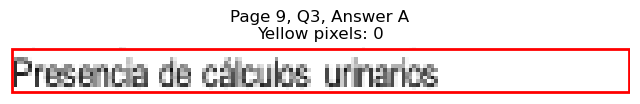

Page 9, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=216.4, y1=289.7
Page 9, Q3, B: Yellow pixels: 1113
Page 9, Q3, B: Total non-white pixels: 1871
Page 9, Q3, B: Yellow percentage: 59.5%


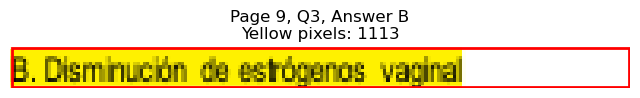

Page 9, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=196.8, y1=301.8
Page 9, Q3, C: Yellow pixels: 137
Page 9, Q3, C: Total non-white pixels: 728
Page 9, Q3, C: Yellow percentage: 18.8%


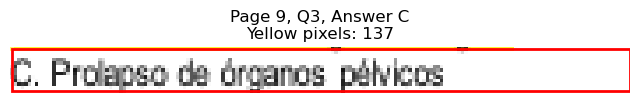

Page 9, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=454.3, y1=277.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 642
Page 9, Q3, D: Yellow percentage: 0.0%


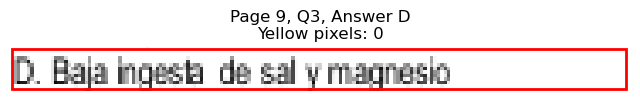

Page 9, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=466.3, y1=289.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 731
Page 9, Q3, E: Yellow percentage: 0.0%


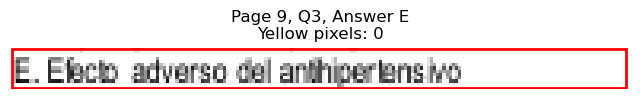


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=122.5, y1=362.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 192
Page 9, Q4, A: Yellow percentage: 0.0%


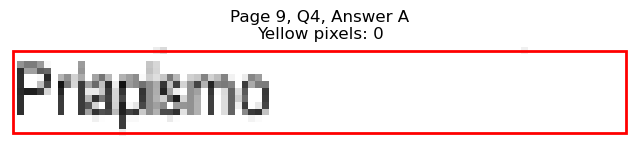

Page 9, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=114.2, y1=374.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 227
Page 9, Q4, B: Yellow percentage: 0.0%


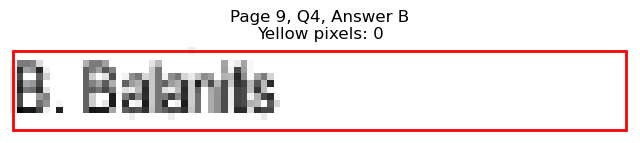

Page 9, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=114.2, y1=386.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 180
Page 9, Q4, C: Yellow percentage: 0.0%


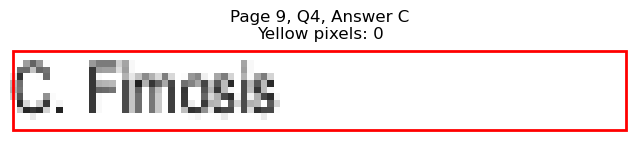

Page 9, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=362.0, y1=362.5
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 189
Page 9, Q4, D: Yellow percentage: 0.0%


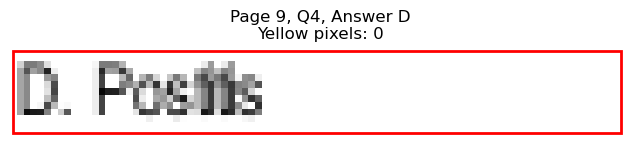

Page 9, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=379.4, y1=374.6
Page 9, Q4, E: Yellow pixels: 484
Page 9, Q4, E: Total non-white pixels: 715
Page 9, Q4, E: Yellow percentage: 67.7%


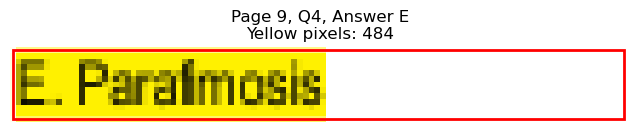


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=153.2, y1=422.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 380
Page 9, Q5, A: Yellow percentage: 0.0%


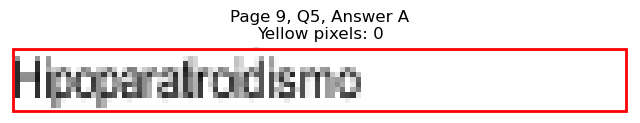

Page 9, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=157.0, y1=434.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 406
Page 9, Q5, B: Yellow percentage: 0.0%


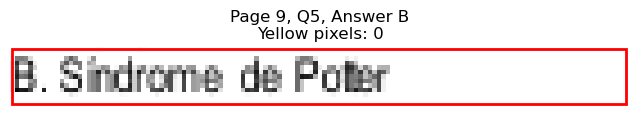

Page 9, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=150.3, y1=446.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 400
Page 9, Q5, C: Yellow percentage: 0.0%


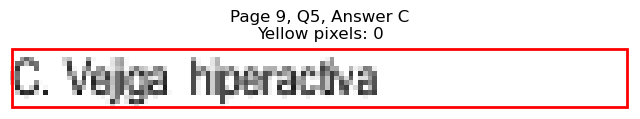

Page 9, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=418.4, y1=422.6
Page 9, Q5, D: Yellow pixels: 738
Page 9, Q5, D: Total non-white pixels: 1235
Page 9, Q5, D: Yellow percentage: 59.8%


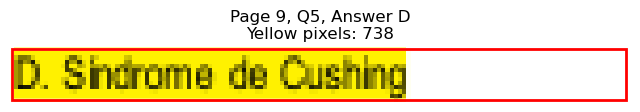

Page 9, Q5 - E: Detected box: x0=362.6, y0=422.5, x1=416.0, y1=434.6
Page 9, Q5, E: Yellow pixels: 54
Page 9, Q5, E: Total non-white pixels: 342
Page 9, Q5, E: Yellow percentage: 15.8%


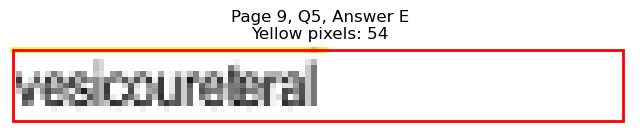


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=135.3, y1=495.4
Page 9, Q6, A: Yellow pixels: 435
Page 9, Q6, A: Total non-white pixels: 663
Page 9, Q6, A: Yellow percentage: 65.6%


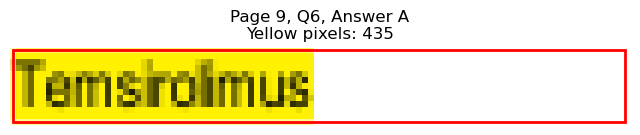

Page 9, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=114.3, y1=507.4
Page 9, Q6, B: Yellow pixels: 50
Page 9, Q6, B: Total non-white pixels: 269
Page 9, Q6, B: Yellow percentage: 18.6%


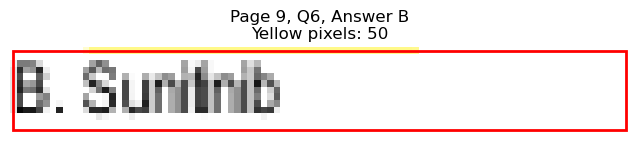

Page 9, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=118.7, y1=519.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 301
Page 9, Q6, C: Yellow percentage: 0.0%


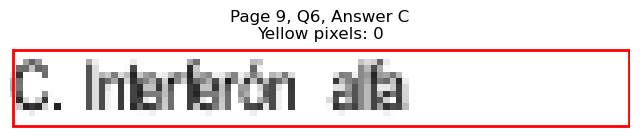

Page 9, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=377.8, y1=495.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 299
Page 9, Q6, D: Yellow percentage: 0.0%


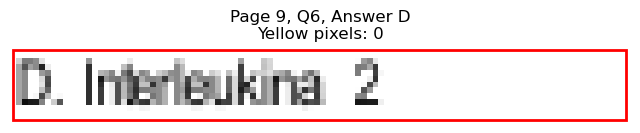

Page 9, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=386.8, y1=507.4
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 317
Page 9, Q6, E: Yellow percentage: 0.0%


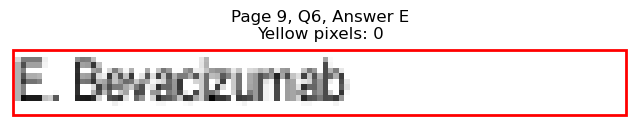


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=128.5, y1=555.5
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 208
Page 9, Q7, A: Yellow percentage: 0.0%


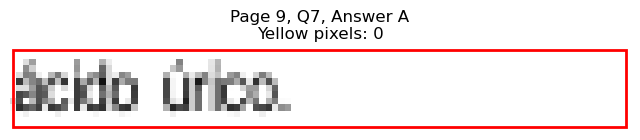

Page 9, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=149.6, y1=567.5
Page 9, Q7, B: Yellow pixels: 708
Page 9, Q7, B: Total non-white pixels: 1001
Page 9, Q7, B: Yellow percentage: 70.7%


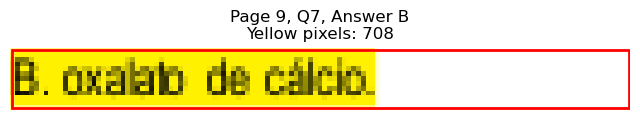

Page 9, Q7 - C: Detected box: x0=110.3, y0=567.5, x1=198.2, y1=579.5
Page 9, Q7, C: Yellow pixels: 37
Page 9, Q7, C: Total non-white pixels: 476
Page 9, Q7, C: Yellow percentage: 7.8%


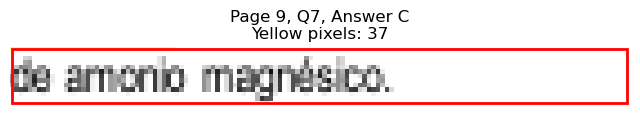

Page 9, Q7 - D: Detected box: x0=361.9, y0=543.4, x1=399.5, y1=555.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 178
Page 9, Q7, D: Yellow percentage: 0.0%


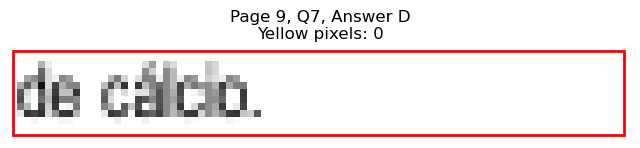

Page 9, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=360.5, y1=567.5
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 169
Page 9, Q7, E: Yellow percentage: 0.0%


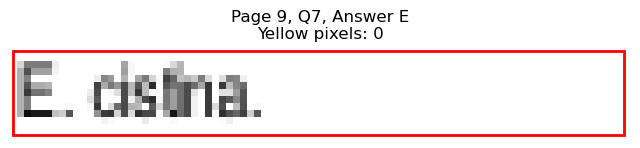


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=127.0, y1=627.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 211
Page 9, Q8, A: Yellow percentage: 0.0%


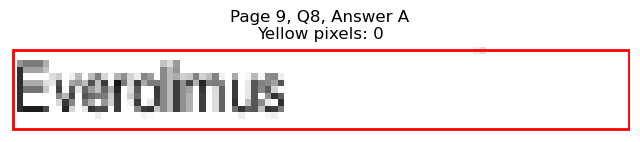

Page 9, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=130.0, y1=639.6
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 308
Page 9, Q8, B: Yellow percentage: 0.0%


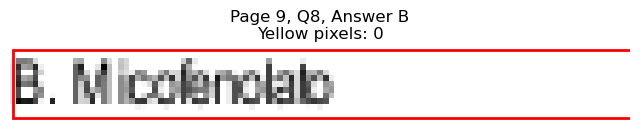

Page 9, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=125.5, y1=651.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 253
Page 9, Q8, C: Yellow percentage: 0.0%


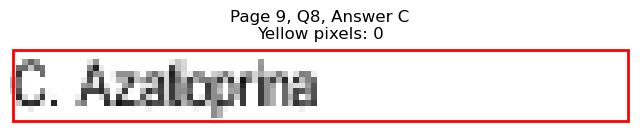

Page 9, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=374.0, y1=627.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 275
Page 9, Q8, D: Yellow percentage: 0.0%


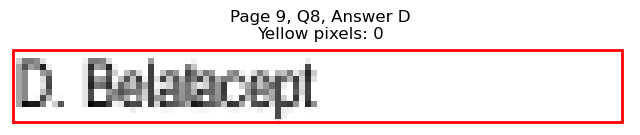

Page 9, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=380.9, y1=639.6
Page 9, Q8, E: Yellow pixels: 486
Page 9, Q8, E: Total non-white pixels: 741
Page 9, Q8, E: Yellow percentage: 65.6%


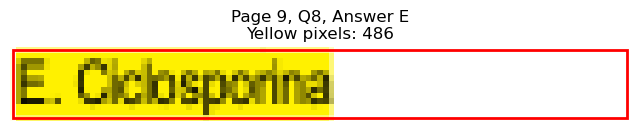


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.6, y0=676.3, x1=239.7, y1=688.3
Page 9, Q9, A: Yellow pixels: 1204
Page 9, Q9, A: Total non-white pixels: 2028
Page 9, Q9, A: Yellow percentage: 59.4%


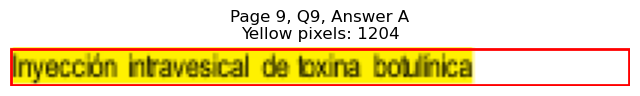

Page 9, Q9 - B: Detected box: x0=71.3, y0=688.3, x1=125.5, y1=700.3
Page 9, Q9, B: Yellow pixels: 1
Page 9, Q9, B: Total non-white pixels: 614
Page 9, Q9, B: Yellow percentage: 0.2%


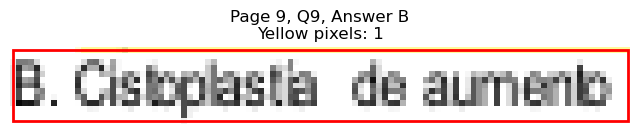

Page 9, Q9 - C: Detected box: x0=71.3, y0=700.3, x1=176.5, y1=712.3
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 745
Page 9, Q9, C: Yellow percentage: 0.0%


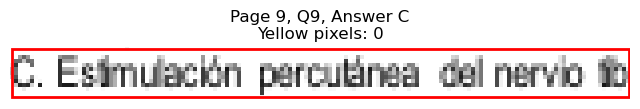

Page 9, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=401.0, y1=688.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 505
Page 9, Q9, D: Yellow percentage: 0.0%


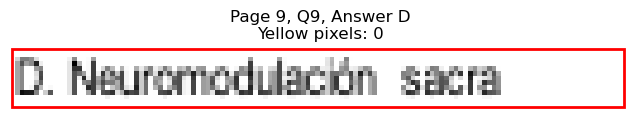

Page 9, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=446.2, y1=700.3
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 595
Page 9, Q9, E: Yellow percentage: 0.0%


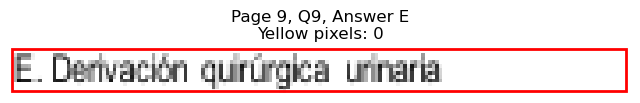


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.6, y0=736.4, x1=207.4, y1=748.4
Page 9, Q10, A: Yellow pixels: 1104
Page 9, Q10, A: Total non-white pixels: 1599
Page 9, Q10, A: Yellow percentage: 69.0%


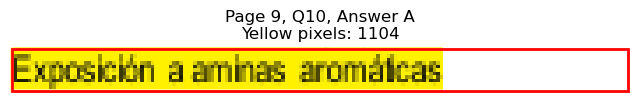

Page 9, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=207.2, y1=760.4
Page 9, Q10, B: Yellow pixels: 122
Page 9, Q10, B: Total non-white pixels: 812
Page 9, Q10, B: Yellow percentage: 15.0%


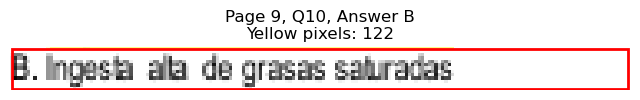

Page 9, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=183.9, y1=772.4
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 509
Page 9, Q10, C: Yellow percentage: 0.0%


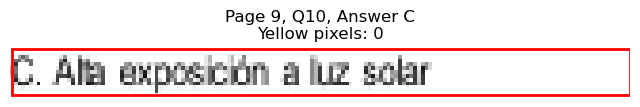

Page 9, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=412.3, y1=748.4
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 440
Page 9, Q10, D: Yellow percentage: 0.0%


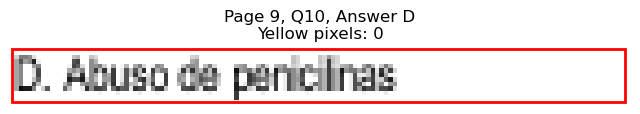

Page 9, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=427.3, y1=760.4
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 507
Page 9, Q10, E: Yellow percentage: 0.0%


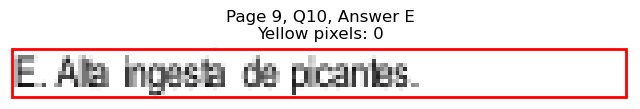


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=154.1, y1=108.8
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 542
Page 10, Q1, A: Yellow percentage: 0.0%


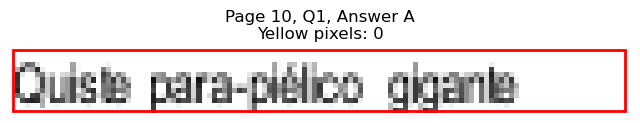

Page 10, Q1 - B: Detected box: x0=111.1, y0=109.5, x1=164.5, y1=121.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 278
Page 10, Q1, B: Yellow percentage: 0.0%


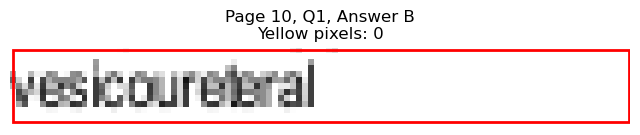

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=175.7, y1=133.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 478
Page 10, Q1, C: Yellow percentage: 0.0%


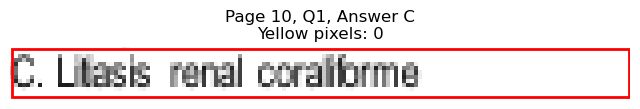

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=455.2, y1=108.8
Page 10, Q1, D: Yellow pixels: 1027
Page 10, Q1, D: Total non-white pixels: 1703
Page 10, Q1, D: Yellow percentage: 60.3%


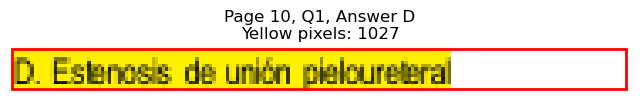

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=440.8, y1=121.6
Page 10, Q1, E: Yellow pixels: 130
Page 10, Q1, E: Total non-white pixels: 708
Page 10, Q1, E: Yellow percentage: 18.4%


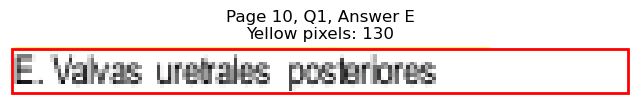


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=193.9, y1=169.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 581
Page 10, Q2, A: Yellow percentage: 0.0%


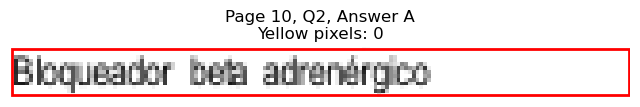

Page 10, Q2 - B: Detected box: x0=129.8, y0=169.6, x1=216.3, y1=181.6
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 443
Page 10, Q2, B: Yellow percentage: 0.0%


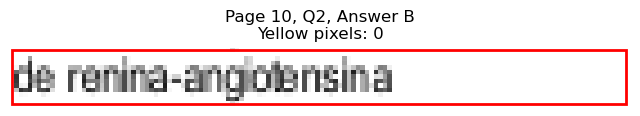

Page 10, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=181.1, y1=193.6
Page 10, Q2, C: Yellow pixels: 880
Page 10, Q2, C: Total non-white pixels: 1405
Page 10, Q2, C: Yellow percentage: 62.6%


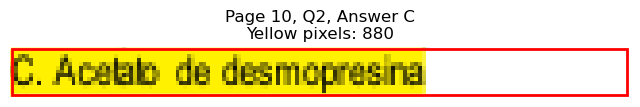

Page 10, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=382.3, y1=169.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 505
Page 10, Q2, D: Yellow percentage: 0.0%


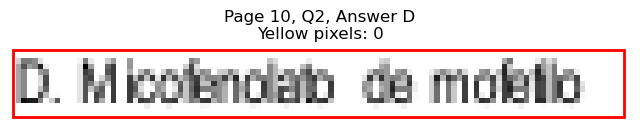

Page 10, Q2 - E: Detected box: x0=361.1, y0=169.6, x1=401.0, y1=181.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 205
Page 10, Q2, E: Yellow percentage: 0.0%


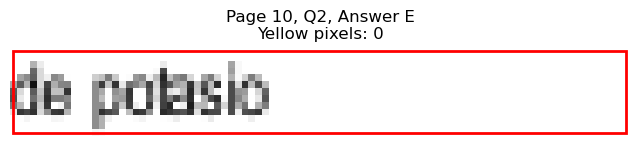


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=94.7, y1=241.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 48
Page 10, Q3, A: Yellow percentage: 0.0%


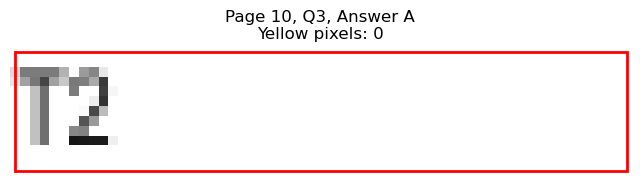

Page 10, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=94.0, y1=253.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 88
Page 10, Q3, B: Yellow percentage: 0.0%


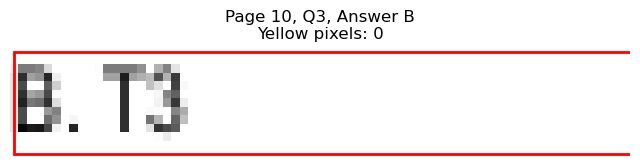

Page 10, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=94.7, y1=265.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 83
Page 10, Q3, C: Yellow percentage: 0.0%


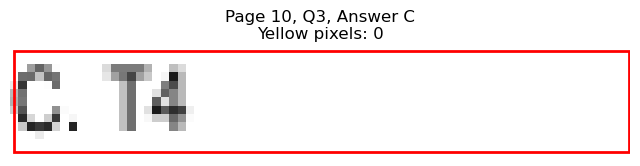

Page 10, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=346.3, y1=241.7
Page 10, Q3, D: Yellow pixels: 184
Page 10, Q3, D: Total non-white pixels: 286
Page 10, Q3, D: Yellow percentage: 64.3%


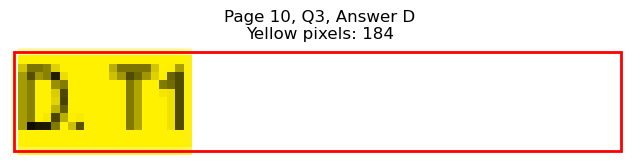

Page 10, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=345.5, y1=253.7
Page 10, Q3, E: Yellow pixels: 21
Page 10, Q3, E: Total non-white pixels: 110
Page 10, Q3, E: Yellow percentage: 19.1%


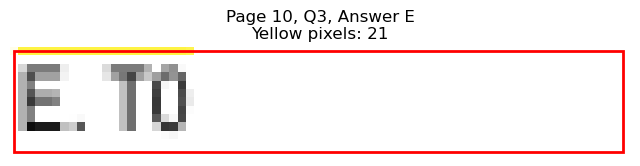


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=130.0, y1=314.5
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 464
Page 10, Q4, A: Yellow percentage: 0.0%


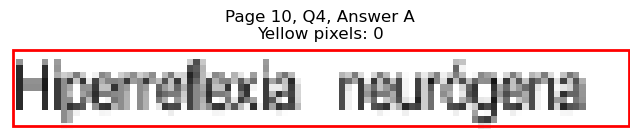

Page 10, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=129.2, y1=326.5
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 538
Page 10, Q4, B: Yellow percentage: 0.0%


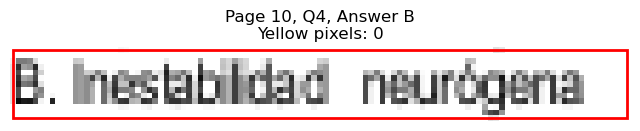

Page 10, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=136.0, y1=338.5
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 518
Page 10, Q4, C: Yellow percentage: 0.0%


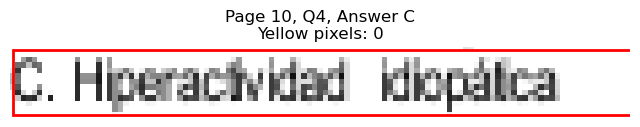

Page 10, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=381.5, y1=314.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 510
Page 10, Q4, D: Yellow percentage: 0.0%


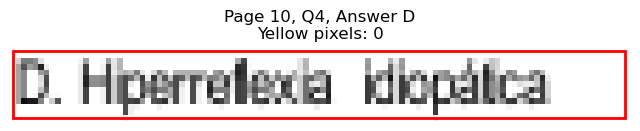

Page 10, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=386.8, y1=326.5
Page 10, Q4, E: Yellow pixels: 934
Page 10, Q4, E: Total non-white pixels: 1404
Page 10, Q4, E: Yellow percentage: 66.5%


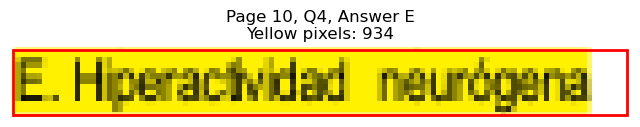


Page 10, Q4 - Selected Answer: E (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=189.4, y1=410.6
Page 10, Q5, A: Yellow pixels: 931
Page 10, Q5, A: Total non-white pixels: 1365
Page 10, Q5, A: Yellow percentage: 68.2%


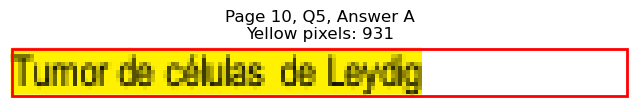

Page 10, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=142.7, y1=422.6
Page 10, Q5, B: Yellow pixels: 104
Page 10, Q5, B: Total non-white pixels: 445
Page 10, Q5, B: Yellow percentage: 23.4%


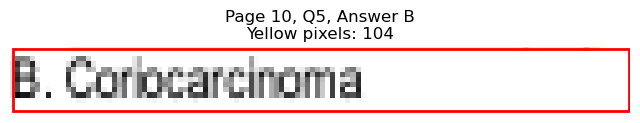

Page 10, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=157.0, y1=434.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 434
Page 10, Q5, C: Yellow percentage: 0.0%


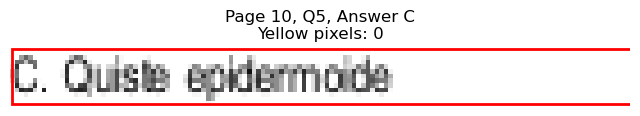

Page 10, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=452.7, y1=410.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 628
Page 10, Q5, D: Yellow percentage: 0.0%


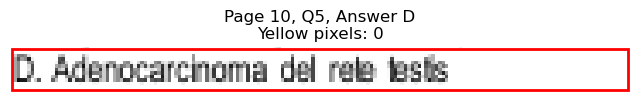

Page 10, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=400.3, y1=422.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 361
Page 10, Q5, E: Yellow percentage: 0.0%


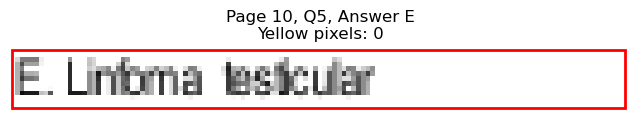


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=168.2, y1=470.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 425
Page 10, Q6, A: Yellow percentage: 0.0%


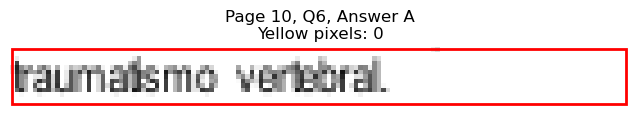

Page 10, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=197.4, y1=482.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 591
Page 10, Q6, B: Yellow percentage: 0.0%


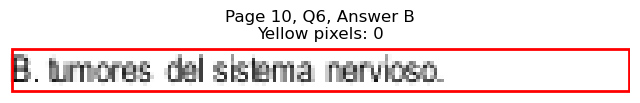

Page 10, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=163.7, y1=495.4
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 431
Page 10, Q6, C: Yellow percentage: 0.0%


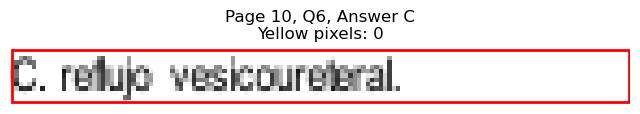

Page 10, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=428.9, y1=470.6
Page 10, Q6, D: Yellow pixels: 849
Page 10, Q6, D: Total non-white pixels: 1365
Page 10, Q6, D: Yellow percentage: 62.2%


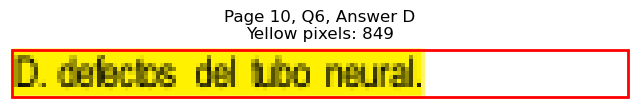

Page 10, Q6 - E: Detected box: x0=359.7, y0=470.6, x1=395.8, y1=482.6
Page 10, Q6, E: Yellow pixels: 68
Page 10, Q6, E: Total non-white pixels: 240
Page 10, Q6, E: Yellow percentage: 28.3%


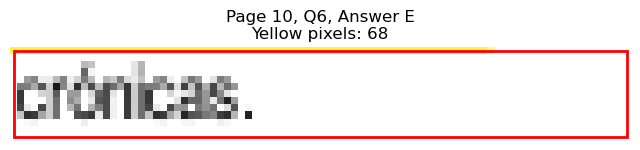


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=129.1, y0=531.4, x1=241.8, y1=543.5
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 487
Page 10, Q7, A: Yellow percentage: 0.0%


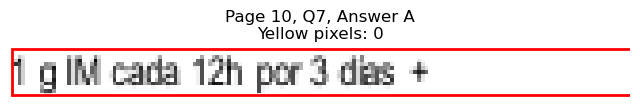

Page 10, Q7 - B: Detected box: x0=128.3, y0=555.4, x1=270.3, y1=567.5
Page 10, Q7, B: Yellow pixels: 1277
Page 10, Q7, B: Total non-white pixels: 1833
Page 10, Q7, B: Yellow percentage: 69.7%


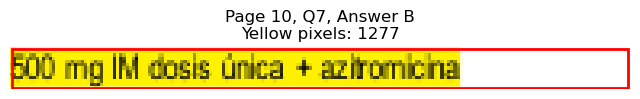

Page 10, Q7 - C: Detected box: x0=139.6, y0=579.4, x1=268.7, y1=591.5
Page 10, Q7, C: Yellow pixels: 3
Page 10, Q7, C: Total non-white pixels: 579
Page 10, Q7, C: Yellow percentage: 0.5%


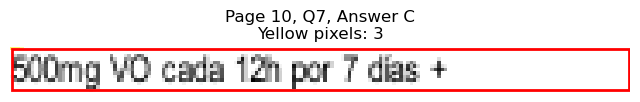

Page 10, Q7 - D: Detected box: x0=388.9, y0=531.4, x1=488.1, y1=543.5
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 452
Page 10, Q7, D: Yellow percentage: 0.0%


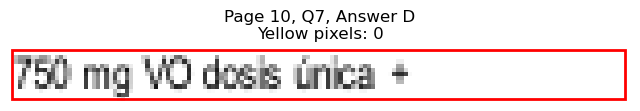

Page 10, Q7 - E: Detected box: x0=388.1, y0=555.4, x1=521.1, y1=567.5
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 584
Page 10, Q7, E: Yellow percentage: 0.0%


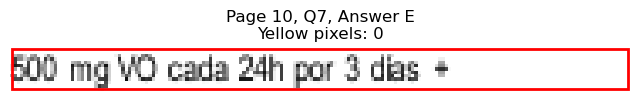


Page 10, Q7 - Selected Answer: B (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=651.5, x1=119.5, y1=663.6
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 182
Page 10, Q8, A: Yellow percentage: 0.0%


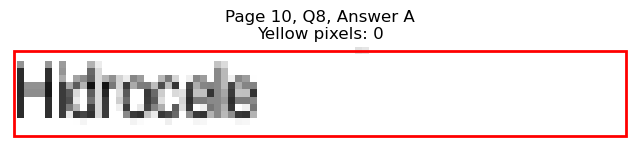

Page 10, Q8 - B: Detected box: x0=71.3, y0=663.5, x1=145.7, y1=675.6
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 381
Page 10, Q8, B: Yellow percentage: 0.0%


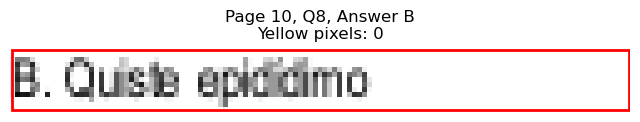

Page 10, Q8 - C: Detected box: x0=71.3, y0=676.3, x1=123.2, y1=688.3
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 239
Page 10, Q8, C: Yellow percentage: 0.0%


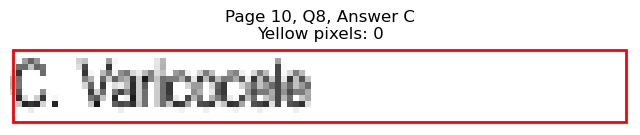

Page 10, Q8 - D: Detected box: x0=322.9, y0=651.5, x1=395.1, y1=663.6
Page 10, Q8, D: Yellow pixels: 631
Page 10, Q8, D: Total non-white pixels: 923
Page 10, Q8, D: Yellow percentage: 68.4%


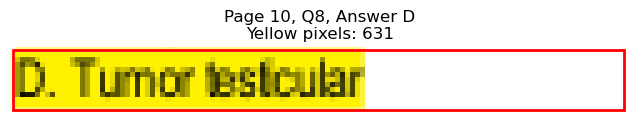

Page 10, Q8 - E: Detected box: x0=322.9, y0=663.5, x1=395.8, y1=675.6
Page 10, Q8, E: Yellow pixels: 70
Page 10, Q8, E: Total non-white pixels: 472
Page 10, Q8, E: Yellow percentage: 14.8%


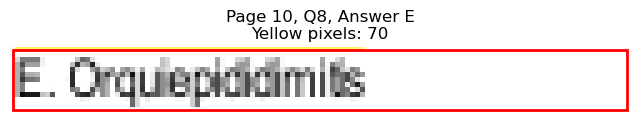


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=736.4, x1=172.1, y1=748.4
Page 10, Q9, A: Yellow pixels: 754
Page 10, Q9, A: Total non-white pixels: 1144
Page 10, Q9, A: Yellow percentage: 65.9%


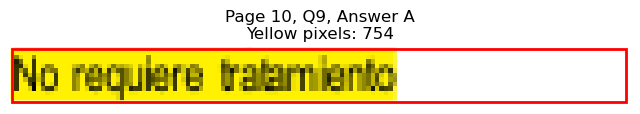

Page 10, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=133.0, y1=760.4
Page 10, Q9, B: Yellow pixels: 86
Page 10, Q9, B: Total non-white pixels: 559
Page 10, Q9, B: Yellow percentage: 15.4%


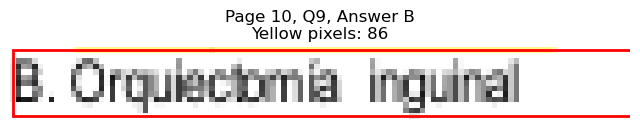

Page 10, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=147.2, y1=772.4
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 641
Page 10, Q9, C: Yellow percentage: 0.0%


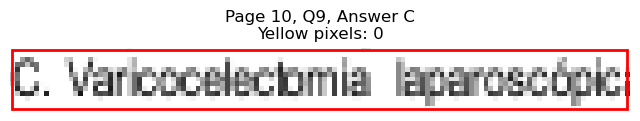

Page 10, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=420.5, y1=748.4
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 482
Page 10, Q9, D: Yellow percentage: 0.0%


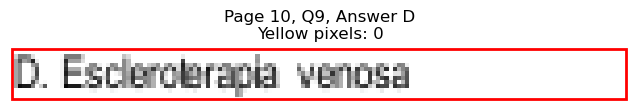

Page 10, Q9 - E: Detected box: x0=322.9, y0=748.4, x1=398.0, y1=760.4
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 371
Page 10, Q9, E: Yellow percentage: 0.0%


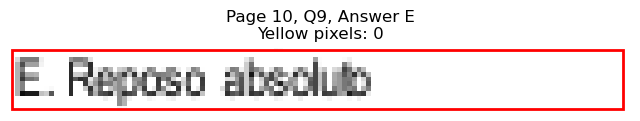


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)





Page 11: Found 7 questions
Page 11, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=117.3, y1=108.8
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 183
Page 11, Q1, A: Yellow percentage: 0.0%


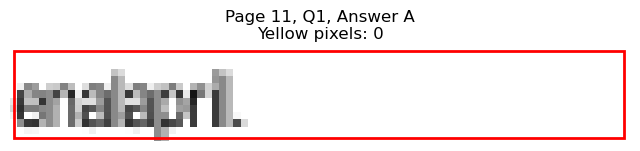

Page 11, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=127.0, y1=121.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 265
Page 11, Q1, B: Yellow percentage: 0.0%


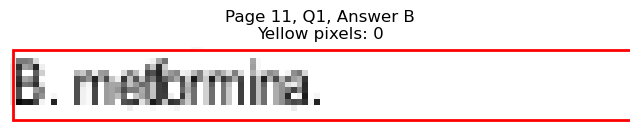

Page 11, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=112.8, y1=133.6
Page 11, Q1, C: Yellow pixels: 357
Page 11, Q1, C: Total non-white pixels: 520
Page 11, Q1, C: Yellow percentage: 68.7%


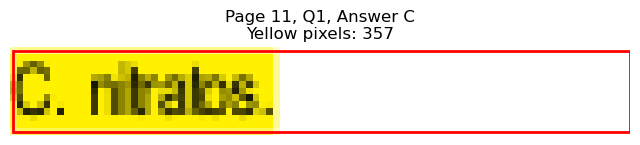

Page 11, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=371.8, y1=108.8
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 245
Page 11, Q1, D: Yellow percentage: 0.0%


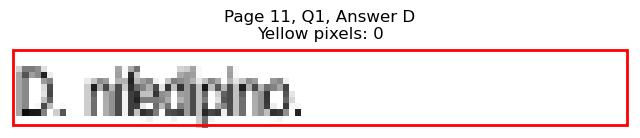

Page 11, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=377.0, y1=121.6
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 284
Page 11, Q1, E: Yellow percentage: 0.0%


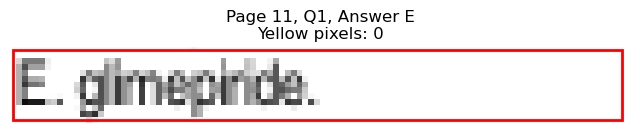


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=131.5, y1=181.6
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 255
Page 11, Q2, A: Yellow percentage: 0.0%


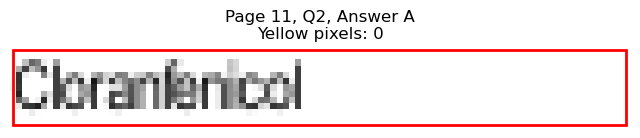

Page 11, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=133.8, y1=193.6
Page 11, Q2, B: Yellow pixels: 486
Page 11, Q2, B: Total non-white pixels: 793
Page 11, Q2, B: Yellow percentage: 61.3%


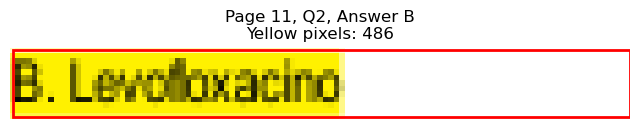

Page 11, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=127.0, y1=205.6
Page 11, Q2, C: Yellow pixels: 60
Page 11, Q2, C: Total non-white pixels: 321
Page 11, Q2, C: Yellow percentage: 18.7%


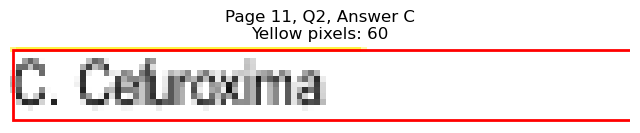

Page 11, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=389.0, y1=181.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 346
Page 11, Q2, D: Yellow percentage: 0.0%


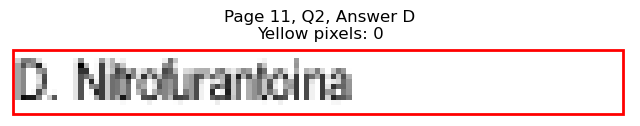

Page 11, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=377.8, y1=193.6
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 262
Page 11, Q2, E: Yellow percentage: 0.0%


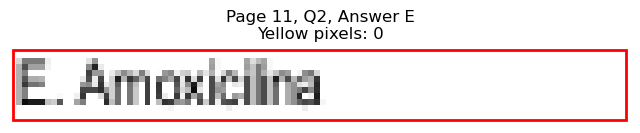


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=119.5, y1=265.7
Page 11, Q3, A: Yellow pixels: 486
Page 11, Q3, A: Total non-white pixels: 832
Page 11, Q3, A: Yellow percentage: 58.4%


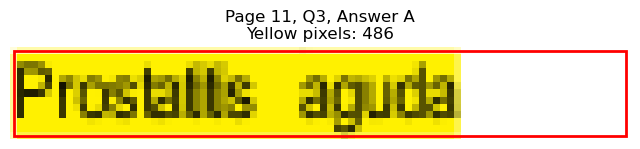

Page 11, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=125.5, y1=277.7
Page 11, Q3, B: Yellow pixels: 63
Page 11, Q3, B: Total non-white pixels: 492
Page 11, Q3, B: Yellow percentage: 12.8%


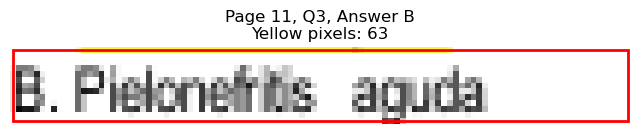

Page 11, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=112.0, y1=289.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 176
Page 11, Q3, C: Yellow percentage: 0.0%


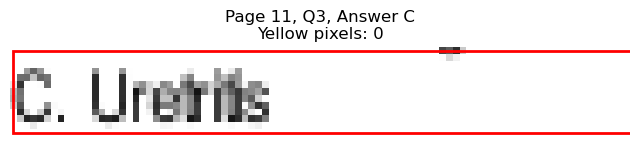

Page 11, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=396.5, y1=265.7
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 399
Page 11, Q3, D: Yellow percentage: 0.0%


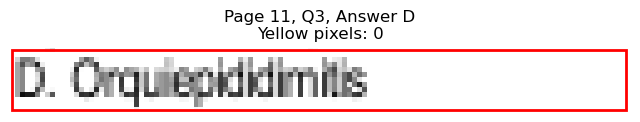

Page 11, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=371.8, y1=277.7
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 400
Page 11, Q3, E: Yellow percentage: 0.0%


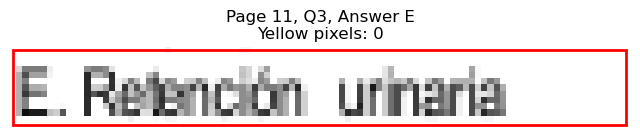


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=137.6, y1=326.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 303
Page 11, Q4, A: Yellow percentage: 0.0%


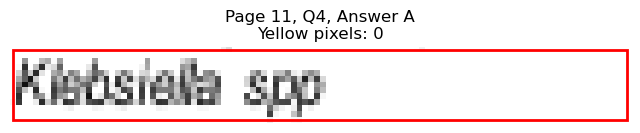

Page 11, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=148.8, y1=338.5
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 372
Page 11, Q4, B: Yellow percentage: 0.0%


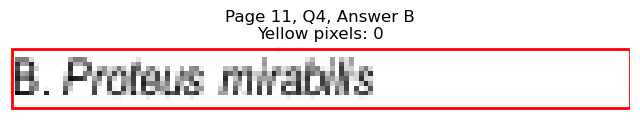

Page 11, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=150.3, y1=350.5
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 375
Page 11, Q4, C: Yellow percentage: 0.0%


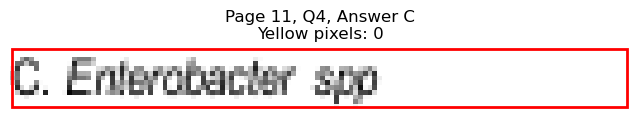

Page 11, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=393.6, y1=326.5
Page 11, Q4, D: Yellow pixels: 604
Page 11, Q4, D: Total non-white pixels: 911
Page 11, Q4, D: Yellow percentage: 66.3%


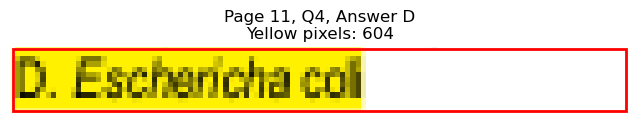

Page 11, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=385.4, y1=338.5
Page 11, Q4, E: Yellow pixels: 68
Page 11, Q4, E: Total non-white pixels: 516
Page 11, Q4, E: Yellow percentage: 13.2%


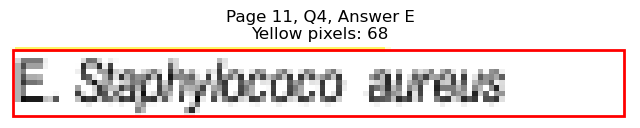


Page 11, Q4 - Selected Answer: D (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=134.5, y1=386.6
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 243
Page 11, Q5, A: Yellow percentage: 0.0%


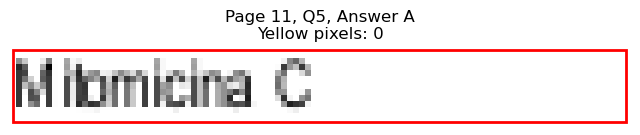

Page 11, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=130.0, y1=398.6
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 304
Page 11, Q5, B: Yellow percentage: 0.0%


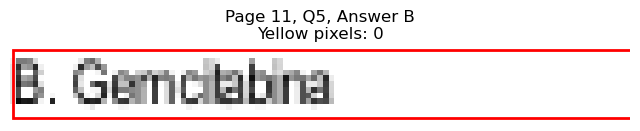

Page 11, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=115.8, y1=410.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 208
Page 11, Q5, C: Yellow percentage: 0.0%


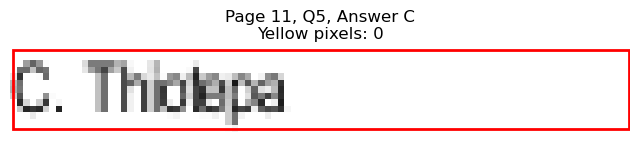

Page 11, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=428.2, y1=386.6
Page 11, Q5, D: Yellow pixels: 895
Page 11, Q5, D: Total non-white pixels: 1356
Page 11, Q5, D: Yellow percentage: 66.0%


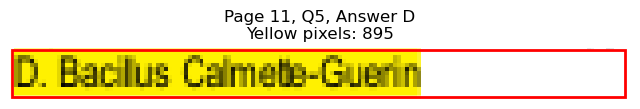

Page 11, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=383.8, y1=398.6
Page 11, Q5, E: Yellow pixels: 103
Page 11, Q5, E: Total non-white pixels: 402
Page 11, Q5, E: Yellow percentage: 25.6%


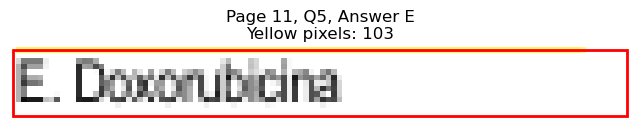


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=156.3, y1=446.6
Page 11, Q6, A: Yellow pixels: 554
Page 11, Q6, A: Total non-white pixels: 938
Page 11, Q6, A: Yellow percentage: 59.1%


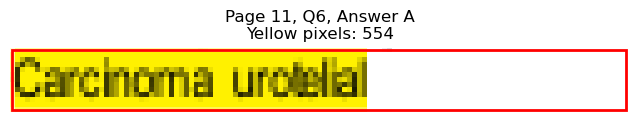

Page 11, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=213.4, y1=458.6
Page 11, Q6, B: Yellow pixels: 71
Page 11, Q6, B: Total non-white pixels: 756
Page 11, Q6, B: Yellow percentage: 9.4%


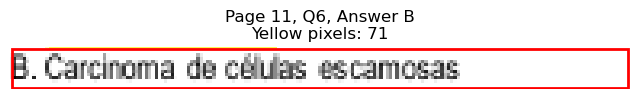

Page 11, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=148.0, y1=470.6
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 363
Page 11, Q6, C: Yellow percentage: 0.0%


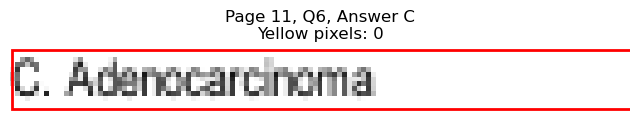

Page 11, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=443.7, y1=446.6
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 587
Page 11, Q6, D: Yellow percentage: 0.0%


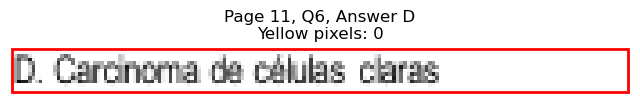

Page 11, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=397.3, y1=458.6
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 348
Page 11, Q6, E: Yellow percentage: 0.0%


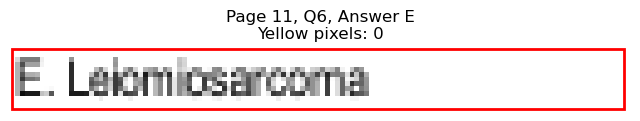


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=212.7, y1=531.4
Page 11, Q7, A: Yellow pixels: 1117
Page 11, Q7, A: Total non-white pixels: 1677
Page 11, Q7, A: Yellow percentage: 66.6%


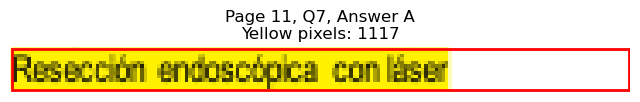

Page 11, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=154.8, y1=543.5
Page 11, Q7, B: Yellow pixels: 122
Page 11, Q7, B: Total non-white pixels: 685
Page 11, Q7, B: Yellow percentage: 17.8%


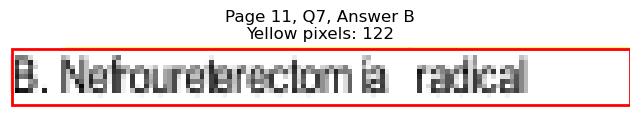

Page 11, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=205.0, y1=555.5
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 675
Page 11, Q7, C: Yellow percentage: 0.0%


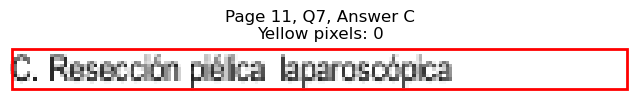

Page 11, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=386.8, y1=531.4
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 582
Page 11, Q7, D: Yellow percentage: 0.0%


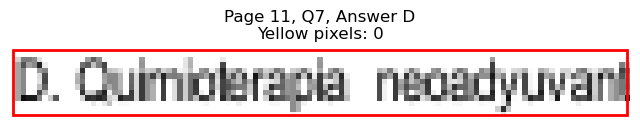

Page 11, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=371.0, y1=543.5
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 496
Page 11, Q7, E: Yellow percentage: 0.0%


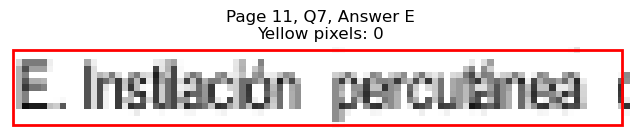


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el tipo histológico más frecuente del...
1   Neonato varón en quien se reporta cordón umbil...
2   Espermatograma: concentración de espermatozoid...
3   ¿Cuál de las siguientes alternativas es una ca...
4   ¿Cuál de los siguientes antibióticos no es aco...
..                                                ...
95  Varón de 32 años, desde hace 12 horas disuria,...
96  ¿Cuál es el gérmen que más frecuentemente caus...
97  ¿Cuál es el medicamento utilizado como inmunot...
98  ¿Cuál es el tipo histológico más frecuente del...
99  Mujer de 61 años, monorrena, con diagnóstico d...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                        option_B  \
0              Eritroplasia de Queyrat             Carcinoma fusiforme   
1            Agenesia renal unilateral              Riñón poliquístico   
2                      Normozoospermia                Teratozoospermia   
3   Generalmente es de tipo secundaria          Más frecuente en niñas   
4                      Nitrofurantoina          Fosfomicina trometamol   
..                                 ...                             ...   
95                   Prostatitis aguda             Pielonefritis aguda   
96                      Klebsiella spp               Proteus mirabilis   
97                        Mitomicina C                     Gemcitabina   
98                 Carcinoma urotelial  Carcinoma de células escamosas   
99     Resección endoscópica con láser      Nefroureterectomía radical   

                                option_C                           option_D  \
0                  Carcinoma epidermoide                     Leiomiosarcoma   
1             Hipoplasia renal bilateral                Hipodisplasia renal   
2                        Oligozoospermia                   Astenozoospermia   
3   Rara vez existe antecedente familiar  Usualmente persiste hasta adultez   
4                          Levofloxacino            Amoxicilina-clavulánico   
..                                   ...                                ...   
95                             Uretritis                  Orquiepididimitis   
96                      Enterobacter spp                    Eschericha coli   
97                              Thiotepa           Bacillus Calmette-Guerin   
98                        Adenocarcinoma        Carcinoma de células claras   
99       Resección piélica laparoscópica         Quimioterapia neoadyuvante   

                               option_E  
0                       Rabdomiosarcoma  
1              Displasia quística renal  
2                       Necrozoospermia  
3   La monosintomática es más frecuente  
4                  Ampicilina-sulbactam  
..                                  ...  
95                   Retención urinaria  
96                  Staphylococo aureus  
97                         Doxorubicina  
98                       Leiomiosarcoma  
99        Instilación percutánea de BCG  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál es el tipo histológico más frecuente del...   
1   Neonato varón en quien se reporta cordón umbil...   
2   Espermatograma: concentración de espermatozoid...   
3   ¿Cuál de las siguientes alternativas es una ca...   
4   ¿Cuál de los siguientes antibióticos no es aco...   
..                                                ...   
95  Varón de 32 años, desde hace 12 horas disuria,...   
96  ¿Cuál es el gérmen que más frecuentemente caus...   
97  ¿Cuál es el medicamento utilizado como inmunot...   
98  ¿Cuál es el tipo histológico más frecuente del...   
99  Mujer de 61 años, monorrena, con diagnóstico d...   

                              option_A                        option_B  \
0              Eritroplasia de Queyrat             Carcinoma fusiforme   
1            Agenesia renal unilateral              Riñón poliquístico   
2                      Normozoospermia                Teratozoospermia   
3   Generalmente es de tipo secundaria          Más frecuente en niñas   
4                      Nitrofurantoina          Fosfomicina trometamol   
..                                 ...                             ...   
95                   Prostatitis aguda             Pielonefritis aguda   
96                      Klebsiella spp               Proteus mirabilis   
97                        Mitomicina C                     Gemcitabina   
98                 Carcinoma urotelial  Carcinoma de células escamosas   
99     Resección endoscópica con láser      Nefroureterectomía radical   

                                option_C                           option_D  \
0                  Carcinoma epidermoide                     Leiomiosarcoma   
1             Hipoplasia renal bilateral                Hipodisplasia renal   
2                        Oligozoospermia                   Astenozoospermia   
3   Rara vez existe antecedente familiar  Usualmente persiste hasta adultez   
4                          Levofloxacino            Amoxicilina-clavulánico   
..                                   ...                                ...   
95                             Uretritis                  Orquiepididimitis   
96                      Enterobacter spp                    Eschericha coli   
97                              Thiotepa           Bacillus Calmette-Guerin   
98                        Adenocarcinoma        Carcinoma de células claras   
99       Resección piélica laparoscópica         Quimioterapia neoadyuvante   

                               option_E correct_answer  
0                       Rabdomiosarcoma              C  
1              Displasia quística renal              A  
2                       Necrozoospermia              D  
3   La monosintomática es más frecuente              E  
4                  Ampicilina-sulbactam              D  
..                                  ...            ...  
95                   Retención urinaria              A  
96                  Staphylococo aureus              D  
97                         Doxorubicina              D  
98                       Leiomiosarcoma              A  
99        Instilación percutánea de BCG              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/UROLOGIA.csv
